In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
!pip install --upgrade --no-cache-dir gdown
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

In [2]:
!gdown 1sQuB_MUaUfJATF3S3jXxR_OnChyhAS7V

Downloading...
From (original): https://drive.google.com/uc?id=1sQuB_MUaUfJATF3S3jXxR_OnChyhAS7V
From (redirected): https://drive.google.com/uc?id=1sQuB_MUaUfJATF3S3jXxR_OnChyhAS7V&confirm=t&uuid=005909a5-4d67-4142-8b57-017af32d1f56
To: /content/dataset_model.zip
100% 409M/409M [00:07<00:00, 53.2MB/s]


In [3]:
import os
import zipfile
with zipfile.ZipFile("/content/dataset_model.zip", "r") as zip_ref:
  print("Unzipping file...")
  zip_ref.extractall("dataset_model")

Unzipping file...


In [4]:
import os
import random
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

# Define paths
root_dir = "/content/dataset_model/dataset_model"  # Replace with the path to your dataset
output_dir = "augmented_data"  # Replace with the path where you want to save the augmented dataset

# Augmentation transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(translate=(0.1, 0.1), degrees=0)
])

# Define a function to augment the images
def augment_images(class_dir, target_count):
    images = os.listdir(class_dir)
    num_existing_images = len(images)

    for i in range(target_count - num_existing_images):
        img_name = random.choice(images)
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)

        # Apply augmentation
        augmented_img = augmentation_transforms(img)

        # Save augmented image
        new_img_name = f"aug_{i}_{img_name}"
        augmented_img.save(os.path.join(class_dir, new_img_name))

# Augment each class folder
for class_folder in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_folder)
    if os.path.isdir(class_dir):
        current_count = len(os.listdir(class_dir))
        if current_count < 458:
            augment_images(class_dir, 458)

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
!pip install --upgrade --no-cache-dir gdown
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

In [6]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


In [7]:
def predict_mask(image_path, model, device, size=(512, 512)):
    """ Reading image """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR) ## (512, 512, 3)
    image = cv2.resize(image, size)
    x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
    x = x/255.0
    x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
    x = x.astype(np.float32)
    x = torch.from_numpy(x)
    x = x.to(device)

    with torch.no_grad():
        """ Prediction """
        pred_y = model(x)
        pred_y = torch.sigmoid(pred_y)
        pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
        pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
        pred_y = pred_y > 0.5
        pred_y = np.array(pred_y, dtype=np.uint8)
        pred_y = pred_y*255
        mask = np.expand_dims(pred_y, axis=-1)    ## (512, 512, 1)
        mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

In [8]:
!gdown 1v_wlT2xKvx7TEYbBervu8I6UxpAZ3SsA

Downloading...
From (original): https://drive.google.com/uc?id=1v_wlT2xKvx7TEYbBervu8I6UxpAZ3SsA
From (redirected): https://drive.google.com/uc?id=1v_wlT2xKvx7TEYbBervu8I6UxpAZ3SsA&confirm=t&uuid=2934ff35-c7ac-404e-85fd-ff4534ee616e
To: /content/checkpoint.pth
100% 124M/124M [00:01<00:00, 63.7MB/s]


In [9]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = build_unet()
model = model.to(device)
checkpoint_path = '/content/checkpoint.pth'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

<ipython-input-10-9a874fd257c9>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

In [11]:
import os
import zipfile
with zipfile.ZipFile("/content/dataset_model.zip", "r") as zip_ref:
  print("Unzipping file...")
  zip_ref.extractall("dataset_model")

Unzipping file...


In [12]:
os.makedirs("module_funcs")

In [13]:
%%writefile module_funcs/data_setup.py
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)
  class_names = train_data.classes
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Writing module_funcs/data_setup.py


In [14]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset
])

In [15]:
import os
import shutil
from sklearn.model_selection import train_test_split
from pathlib import Path

In [16]:
data_dir = '/content/dataset_model/dataset_model'
train_dir = 'train_dataset'
test_dir = 'test_dataset'

# The ratio for splitting the data (e.g., 80% training, 20% testing)
test_size = 0.2

In [17]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [18]:
for class_folder in os.listdir(data_dir):
    # Path to the current class folder
    class_folder_path = os.path.join(data_dir, class_folder)

    # List all files in the current class folder
    all_files = os.listdir(class_folder_path)

    # Split files into train and test sets
    train_files, test_files = train_test_split(all_files, test_size=test_size, random_state=42)

    # Create class subfolders in train and test directories
    os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)

    # Move the train files to the train directory
    for file in train_files:
        shutil.move(os.path.join(class_folder_path, file), os.path.join(train_dir, class_folder, file))

    # Move the test files to the test directory
    for file in test_files:
        shutil.move(os.path.join(class_folder_path, file), os.path.join(test_dir, class_folder, file))

In [19]:
for dir_path in [train_dir, test_dir]:
    print(f'\nDirectory: {dir_path}')
    for class_folder in os.listdir(dir_path):
        class_folder_path = os.path.join(dir_path, class_folder)
        print(f'{class_folder}: {len(os.listdir(class_folder_path))} images')


Directory: train_dataset
stage2: 366 images
stage1: 366 images
stage0: 366 images
stage3: 366 images

Directory: test_dataset
stage2: 92 images
stage1: 92 images
stage0: 92 images
stage3: 92 images


In [20]:
original_folder = '/content/train_dataset'  # Path to the folder with the 4 subfolders
new_folder = 'new_train_dataset'  # Path to the new folder you want to create

# Step 1: Create the new folder structure
if not os.path.exists(new_folder):
    os.makedirs(new_folder)

# Copy the subfolder structure
subfolders = [f.path for f in os.scandir(original_folder) if f.is_dir()]
for subfolder in subfolders:
    new_subfolder = os.path.join(new_folder, os.path.basename(subfolder))
    os.makedirs(new_subfolder, exist_ok=True)

# Step 2: Process images and save them in the new folder
for subfolder in subfolders:
    new_subfolder = os.path.join(new_folder, os.path.basename(subfolder))
    for filename in os.listdir(subfolder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Modify as needed
            original_image_path = os.path.join(subfolder, filename)
            print(f"Processing image: {original_image_path}")  # Debug message

            try:
                output_image = predict_mask(original_image_path , model = model , device = device)
                output_image = Image.fromarray(output_image)
                if output_image is not None:
                    output_image_path = os.path.join(new_subfolder, filename)
                    output_image.save(output_image_path)
                    print(f"Saved processed image to: {output_image_path}")  # Debug message
                else:
                    print(f"Failed to process image: {original_image_path}")  # Debug message
            except Exception as e:
                print(f"Error saving image {original_image_path}: {e}")  # Debug message

print("Processing completed successfully!")

Processing image: /content/train_dataset/stage2/138_F_GA26_BW680_PA35_DG3_PF2_D2_S04_4.jpg
Saved processed image to: new_train_dataset/stage2/138_F_GA26_BW680_PA35_DG3_PF2_D2_S04_4.jpg
Processing image: /content/train_dataset/stage2/031_M_GA25_BW910_PA35_DG3_PF0_D1_S04_7.jpg
Saved processed image to: new_train_dataset/stage2/031_M_GA25_BW910_PA35_DG3_PF0_D1_S04_7.jpg
Processing image: /content/train_dataset/stage2/066_F_GA26_BW810_PA40_DG3_PF0_D1_S05_12.jpg
Saved processed image to: new_train_dataset/stage2/066_F_GA26_BW810_PA40_DG3_PF0_D1_S05_12.jpg
Processing image: /content/train_dataset/stage2/051_F_GA24_BW600_PA42_DG3_PF0_D1_S03_12.jpg
Saved processed image to: new_train_dataset/stage2/051_F_GA24_BW600_PA42_DG3_PF0_D1_S03_12.jpg
Processing image: /content/train_dataset/stage2/179_F_GA26_BW720_PA37_DG3_PF0_D3_S02_5.jpg
Saved processed image to: new_train_dataset/stage2/179_F_GA26_BW720_PA37_DG3_PF0_D3_S02_5.jpg
Processing image: /content/train_dataset/stage2/066_F_GA26_BW810_PA36_D

In [21]:
original_folder = '/content/test_dataset'  # Path to the folder with the 4 subfolders
new_folder = 'new_test_dataset'  # Path to the new folder you want to create

# Step 1: Create the new folder structure
if not os.path.exists(new_folder):
    os.makedirs(new_folder)

# Copy the subfolder structure
subfolders = [f.path for f in os.scandir(original_folder) if f.is_dir()]
for subfolder in subfolders:
    new_subfolder = os.path.join(new_folder, os.path.basename(subfolder))
    os.makedirs(new_subfolder, exist_ok=True)

# Step 2: Process images and save them in the new folder
for subfolder in subfolders:
    new_subfolder = os.path.join(new_folder, os.path.basename(subfolder))
    for filename in os.listdir(subfolder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Modify as needed
            original_image_path = os.path.join(subfolder, filename)
            print(f"Processing image: {original_image_path}")  # Debug message

            try:
                output_image = predict_mask(original_image_path , model = model , device = device)
                output_image = Image.fromarray(output_image)
                if output_image is not None:
                    output_image_path = os.path.join(new_subfolder, filename)
                    output_image.save(output_image_path)
                    print(f"Saved processed image to: {output_image_path}")  # Debug message
                else:
                    print(f"Failed to process image: {original_image_path}")  # Debug message
            except Exception as e:
                print(f"Error saving image {original_image_path}: {e}")  # Debug message

print("Processing completed successfully!")

Processing image: /content/test_dataset/stage2/031_M_GA25_BW910_PA34_DG3_PF0_D1_S03_11.jpg
Saved processed image to: new_test_dataset/stage2/031_M_GA25_BW910_PA34_DG3_PF0_D1_S03_11.jpg
Processing image: /content/test_dataset/stage2/031_M_GA25_BW910_PA37_DG3_PF0_D1_S06_6.jpg
Saved processed image to: new_test_dataset/stage2/031_M_GA25_BW910_PA37_DG3_PF0_D1_S06_6.jpg
Processing image: /content/test_dataset/stage2/052_M_GA26_BW820_PA33_DG3_PF0_D1_S03_3.jpg
Saved processed image to: new_test_dataset/stage2/052_M_GA26_BW820_PA33_DG3_PF0_D1_S03_3.jpg
Processing image: /content/test_dataset/stage2/031_M_GA25_BW910_PA36_DG3_PF0_D1_S05_4.jpg
Saved processed image to: new_test_dataset/stage2/031_M_GA25_BW910_PA36_DG3_PF0_D1_S05_4.jpg
Processing image: /content/test_dataset/stage2/052_M_GA26_BW820_PA42_DG3_PF0_D1_S06_3.jpg
Saved processed image to: new_test_dataset/stage2/052_M_GA26_BW820_PA42_DG3_PF0_D1_S06_3.jpg
Processing image: /content/test_dataset/stage2/052_M_GA26_BW820_PA33_DG3_PF0_D1_S03

In [22]:
from module_funcs import data_setup
train_dataloader2 , test_dataloader2 , class_names2  = data_setup.create_dataloaders(train_dir = "/content/new_train_dataset" ,
                                                                                  test_dir = "/content/new_test_dataset" ,
                                                                                  transform = simple_transform ,
                                                                                  batch_size = 25)

In [ ]:
import torchvision
weights2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT

In [ ]:
model2 = torchvision.models.efficientnet_b2(weights=weights2).to(device)
total_layers_model2 = sum(1 for _ in model2.parameters())
percent_freeze_model2 = 0.7
num_layers_freeze_model2 = int(percent_freeze_model2*total_layers_model2)
frozen_layers_model2 = 0
for name , param in model2.named_parameters():
  if "classifier" not in name:
    if frozen_layers_model2 < num_layers_freeze_model2:
      param.requires_grad = False
      frozen_layers_model2 += 1
    else:
      break

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 161MB/s]


In [30]:
output_shape = len(class_names2)
model2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape,
                    bias=True)).to(device)

NameError: name 'model2' is not defined

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer_model2 = torch.optim.Adam(model2.parameters(), lr=0.01)

In [27]:
test_data2 = datasets.ImageFolder("/content/new_test_dataset", transform=simple_transform)
test_data2.targets = torch.Tensor(test_data2.targets)

In [26]:
%%writefile module_funcs/engine.py
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:



  model.eval()


  test_loss, test_acc = 0, 0

  with torch.inference_mode():
      for batch, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)

          test_pred_logits = model(X)

          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:



  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  return results

Writing module_funcs/engine.py


In [ ]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results3 = engine.train(model=model2,
                       train_dataloader=train_dataloader2,
                       test_dataloader=test_dataloader2,
                       optimizer=optimizer_model2,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.2811 | train_acc: 0.4585 | test_loss: 4.0358 | test_acc: 0.4270
Epoch: 2 | train_loss: 1.0364 | train_acc: 0.5492 | test_loss: 1.0627 | test_acc: 0.5870
Epoch: 3 | train_loss: 0.8519 | train_acc: 0.6423 | test_loss: 1.1342 | test_acc: 0.6487
Epoch: 4 | train_loss: 0.7653 | train_acc: 0.7062 | test_loss: 0.7125 | test_acc: 0.7052
Epoch: 5 | train_loss: 0.6446 | train_acc: 0.7408 | test_loss: 0.6920 | test_acc: 0.7452
Epoch: 6 | train_loss: 0.5213 | train_acc: 0.8023 | test_loss: 0.7923 | test_acc: 0.7148
Epoch: 7 | train_loss: 0.5070 | train_acc: 0.8077 | test_loss: 0.8264 | test_acc: 0.7113
Epoch: 8 | train_loss: 0.4378 | train_acc: 0.8446 | test_loss: 0.6247 | test_acc: 0.7539
Epoch: 9 | train_loss: 0.4901 | train_acc: 0.8162 | test_loss: 0.7806 | test_acc: 0.7217
Epoch: 10 | train_loss: 0.4361 | train_acc: 0.8292 | test_loss: 0.6882 | test_acc: 0.7696
Epoch: 11 | train_loss: 0.3262 | train_acc: 0.8823 | test_loss: 0.5980 | test_acc: 0.7870
Epoch: 12 | train_l

Making predictions:   0%|          | 0/23 [00:00<?, ?it/s]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 21.6 MB/s eta 0:00:00


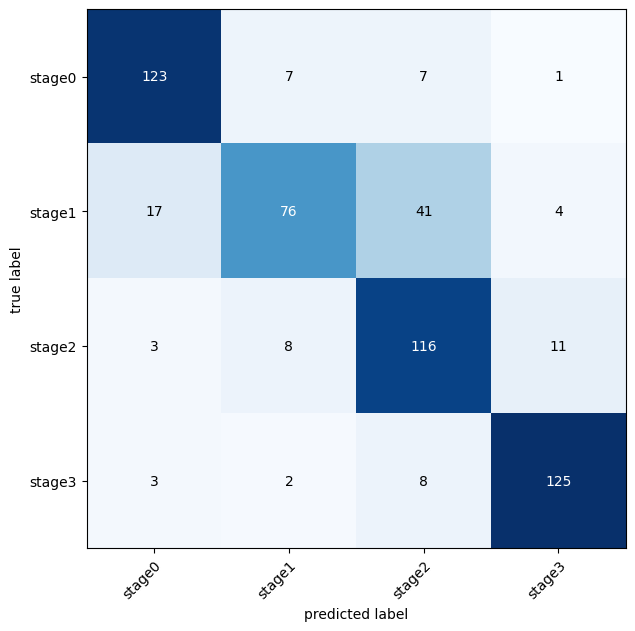

In [ ]:
from tqdm.auto import tqdm
y_preds = []
model2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader2, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model2(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model2 = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names2), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model2,
                         target=test_data2.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names2,
    figsize=(10, 7)
);

In [ ]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")

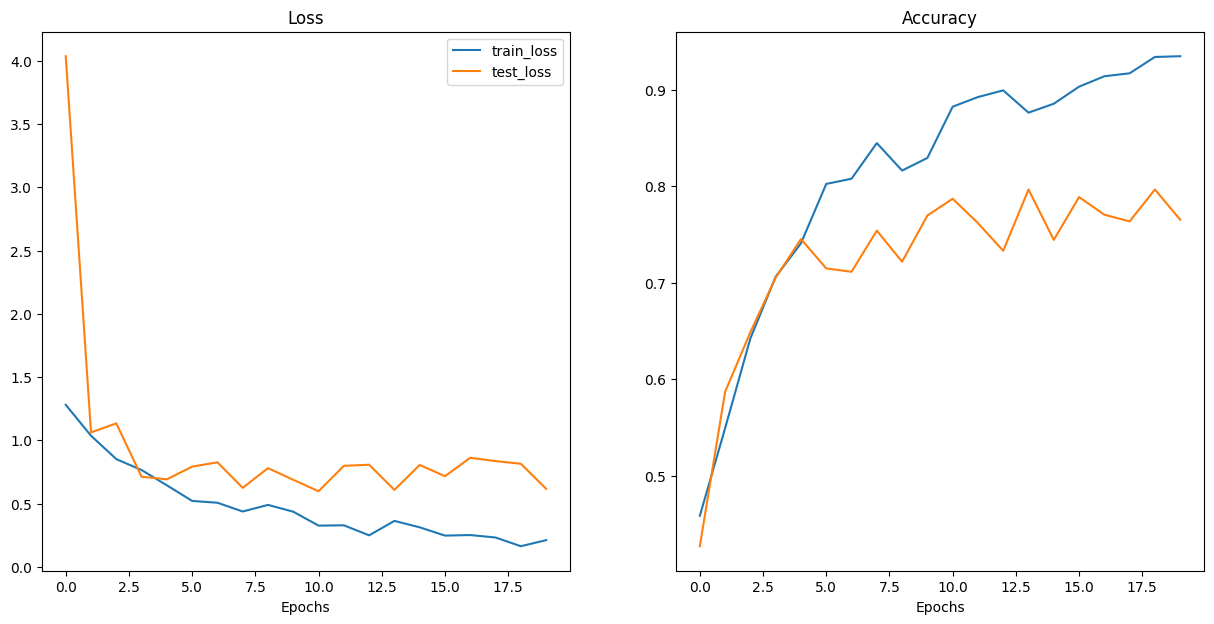

In [ ]:
plot_loss_curves(results3)

In [ ]:
original_folder = '/content/dataset_model/dataset_model'  # Path to the folder with the 4 subfolders
new_folder = 'new_dataset'  # Path to the new folder you want to create

# Step 1: Create the new folder structure
if not os.path.exists(new_folder):
    os.makedirs(new_folder)

# Copy the subfolder structure
subfolders = [f.path for f in os.scandir(original_folder) if f.is_dir()]
for subfolder in subfolders:
    new_subfolder = os.path.join(new_folder, os.path.basename(subfolder))
    os.makedirs(new_subfolder, exist_ok=True)

# Step 2: Process images and save them in the new folder
for subfolder in subfolders:
    new_subfolder = os.path.join(new_folder, os.path.basename(subfolder))
    for filename in os.listdir(subfolder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Modify as needed
            original_image_path = os.path.join(subfolder, filename)
            print(f"Processing image: {original_image_path}")  # Debug message

            try:
                output_image = predict_mask(original_image_path , model = model , device = device)
                output_image = Image.fromarray(output_image)
                if output_image is not None:
                    output_image_path = os.path.join(new_subfolder, filename)
                    output_image.save(output_image_path)
                    print(f"Saved processed image to: {output_image_path}")  # Debug message
                else:
                    print(f"Failed to process image: {original_image_path}")  # Debug message
            except Exception as e:
                print(f"Error saving image {original_image_path}: {e}")  # Debug message

print("Processing completed successfully!")


Processing image: /content/dataset_model/dataset_model/stage3/aug_140_146_M_GA23_BW590_PA37_DG4_PF0_D3_S04_44.jpg
Saved processed image to: new_dataset/stage3/aug_140_146_M_GA23_BW590_PA37_DG4_PF0_D3_S04_44.jpg
Processing image: /content/dataset_model/dataset_model/stage3/aug_317_146_M_GA23_BW590_PA36_DG4_PF0_D3_S03_24.jpg
Saved processed image to: new_dataset/stage3/aug_317_146_M_GA23_BW590_PA36_DG4_PF0_D3_S03_24.jpg
Processing image: /content/dataset_model/dataset_model/stage3/aug_283_146_M_GA23_BW590_PA36_DG4_PF0_D3_S03_15.jpg
Saved processed image to: new_dataset/stage3/aug_283_146_M_GA23_BW590_PA36_DG4_PF0_D3_S03_15.jpg
Processing image: /content/dataset_model/dataset_model/stage3/aug_100_162_F_GA26_BW850_PA38_DG4_PF0_D3_S02_6.jpg
Saved processed image to: new_dataset/stage3/aug_100_162_F_GA26_BW850_PA38_DG4_PF0_D3_S02_6.jpg
Processing image: /content/dataset_model/dataset_model/stage3/162_F_GA26_BW850_PA38_DG4_PF0_D3_S02_8.jpg
Saved processed image to: new_dataset/stage3/162_F_GA

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import KFold

In [ ]:
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset
])

In [ ]:
segmented_dataset = ImageFolder(root='/content/new_dataset', transform=simple_transform)

# Define k-fold cross-validation parameters
k_folds = 10
batch_size = 32  # Adjust based on your resources

# Prepare the k-fold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start the K-Fold Cross-Validation process
for fold, (train_ids, val_ids) in enumerate(kfold.split(segmented_dataset)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(segmented_dataset, train_ids)
    val_subsampler = Subset(segmented_dataset, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize the main model, loss function, and optimizer
    main_model = model2  # Replace with your main model
    criterion = torch.nn.CrossEntropyLoss()  # Replace with your loss function
    optimizer = torch.optim.Adam(main_model.parameters())  # Replace with your optimizer

    # Training and validation process
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        main_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = main_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        main_model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = main_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy for fold {fold}: {100 * correct / total}%')

    # Optionally save model after each fold
    torch.save(main_model.state_dict(), f'main_model_fold_{fold}.pth')

    print('--------------------------------')

FOLD 0
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 0: 97.72727272727273%
Starting epoch 2/10
Validation Accuracy for fold 0: 97.72727272727273%
Starting epoch 3/10
Validation Accuracy for fold 0: 97.72727272727273%
Starting epoch 4/10
Validation Accuracy for fold 0: 97.72727272727273%
Starting epoch 5/10
Validation Accuracy for fold 0: 97.72727272727273%
Starting epoch 6/10
Validation Accuracy for fold 0: 96.5909090909091%
Starting epoch 7/10
Validation Accuracy for fold 0: 97.72727272727273%
Starting epoch 8/10
Validation Accuracy for fold 0: 96.5909090909091%
Starting epoch 9/10
Validation Accuracy for fold 0: 95.45454545454545%
Starting epoch 10/10
Validation Accuracy for fold 0: 96.5909090909091%
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 1: 100.0%
Starting epoch 2/10
Validation Accuracy for fold 1: 100.0%
Starting epoch 3/10
Validation Accuracy for fold 1: 98.863636

FOLD 0
--------------------------------
Starting epoch 1/10


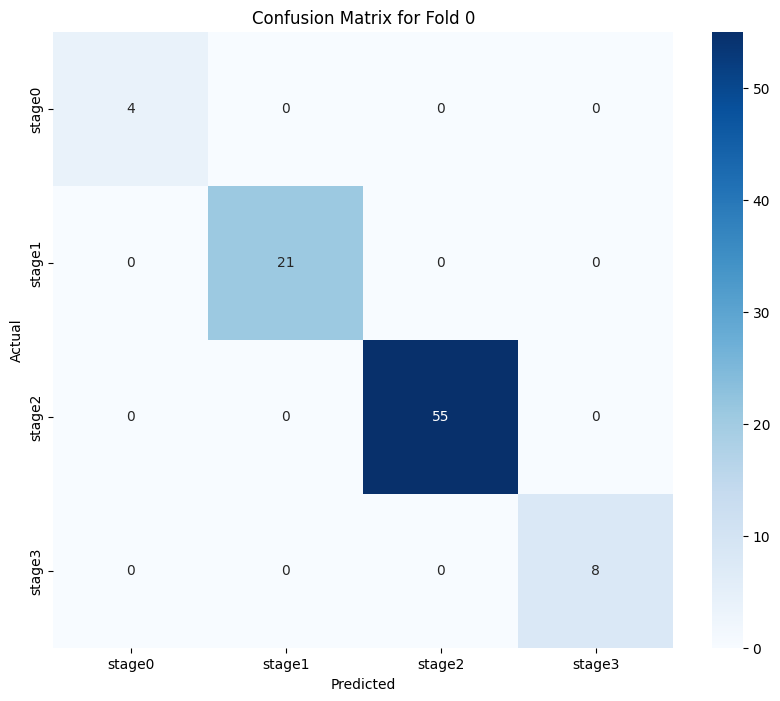

Validation Accuracy for fold 0: 100.0%
Starting epoch 2/10


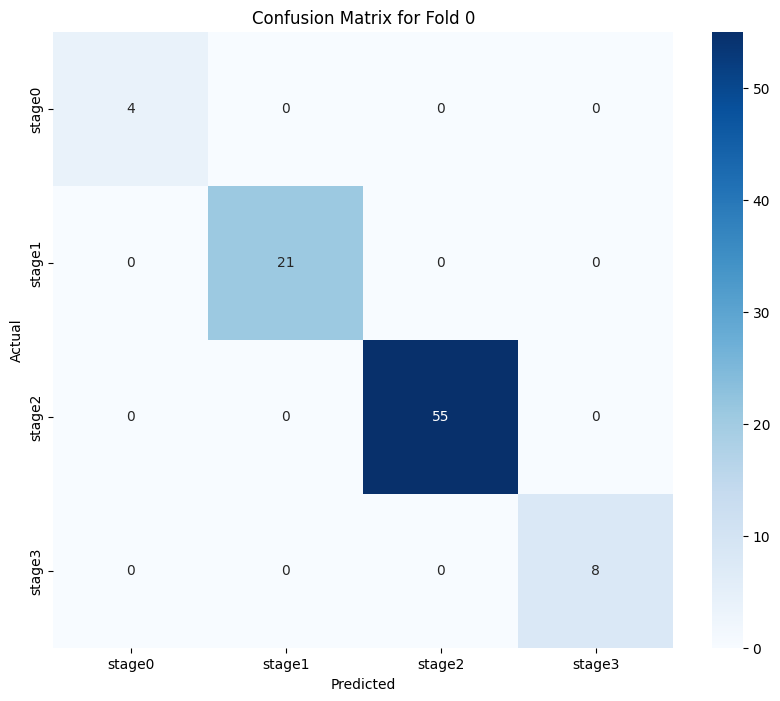

Validation Accuracy for fold 0: 100.0%
Starting epoch 3/10


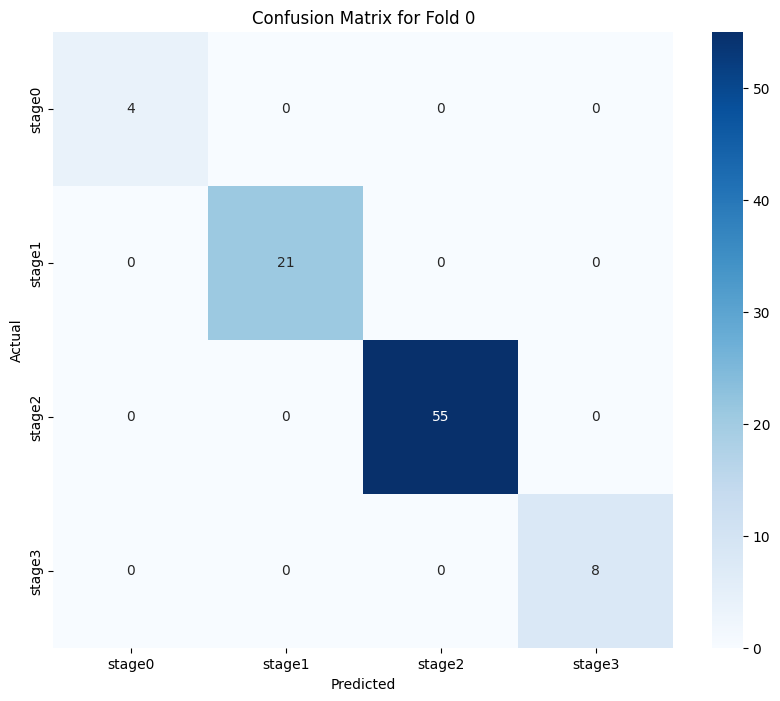

Validation Accuracy for fold 0: 100.0%
Starting epoch 4/10


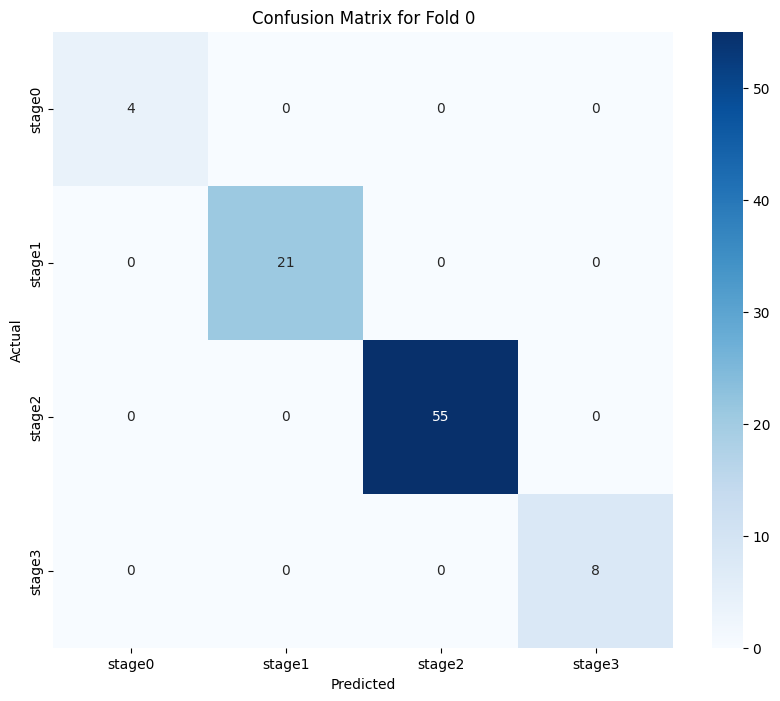

Validation Accuracy for fold 0: 100.0%
Starting epoch 5/10


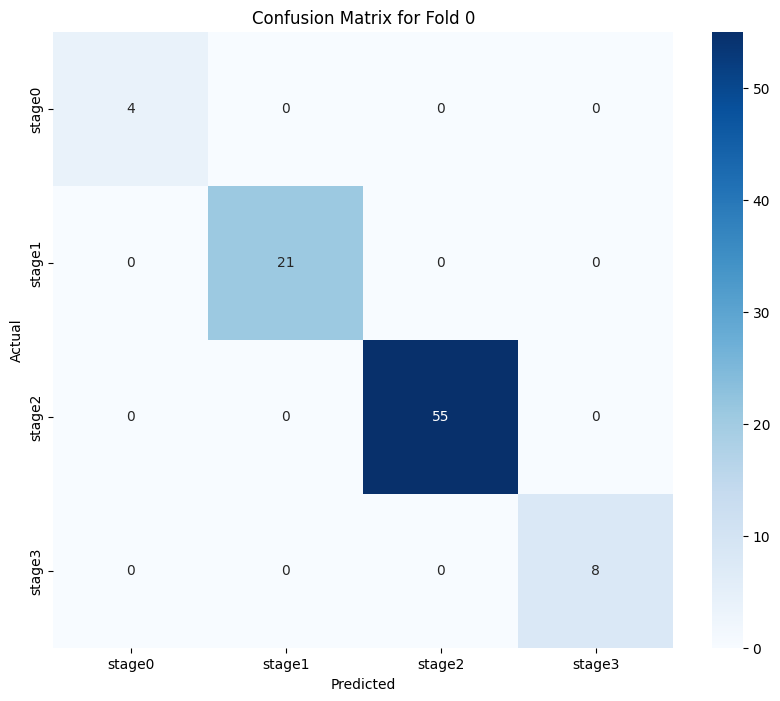

Validation Accuracy for fold 0: 100.0%
Starting epoch 6/10


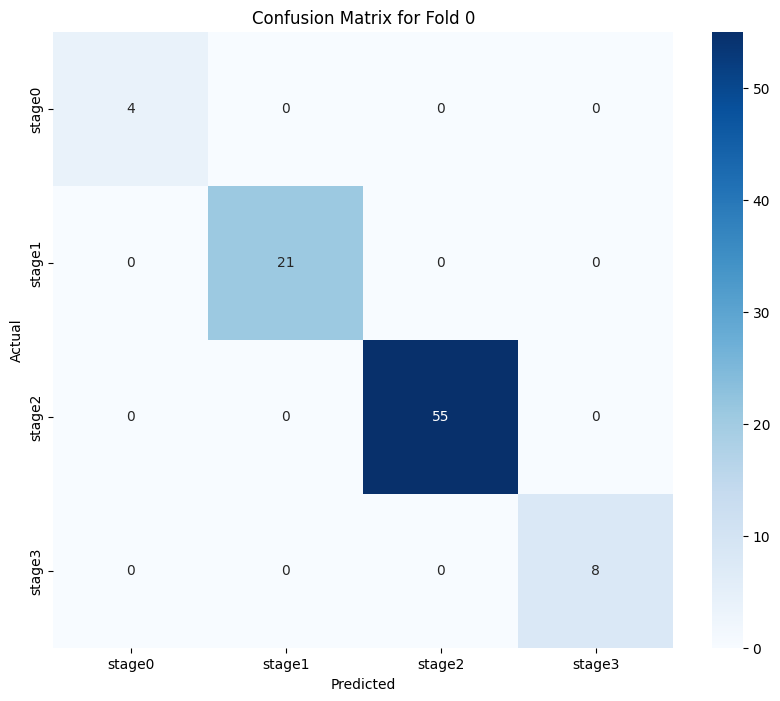

Validation Accuracy for fold 0: 100.0%
Starting epoch 7/10


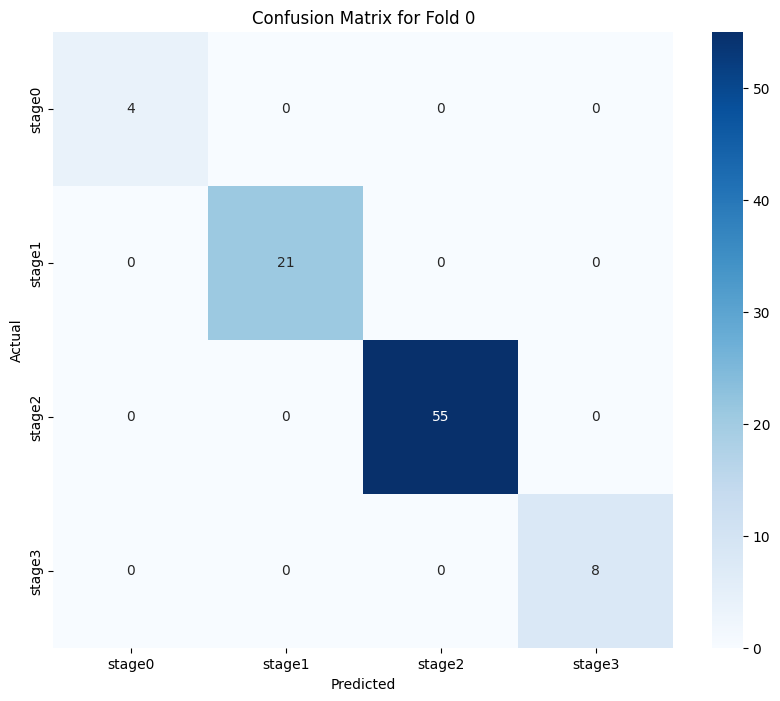

Validation Accuracy for fold 0: 100.0%
Starting epoch 8/10


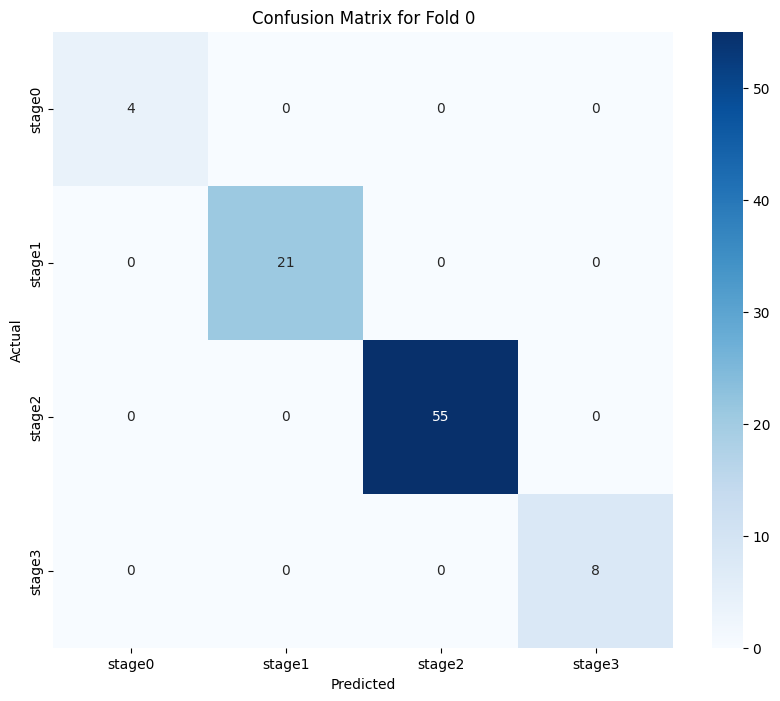

Validation Accuracy for fold 0: 100.0%
Starting epoch 9/10


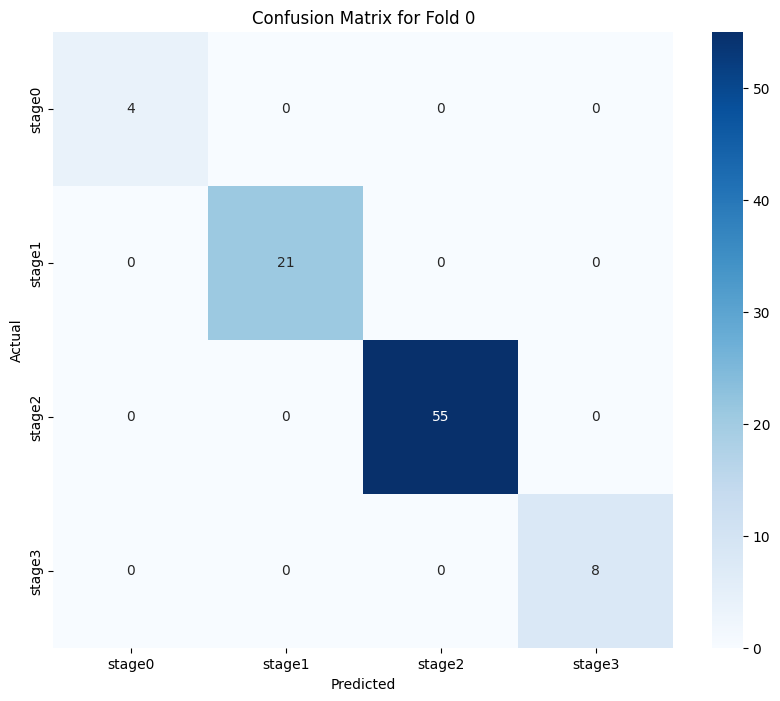

Validation Accuracy for fold 0: 100.0%
Starting epoch 10/10


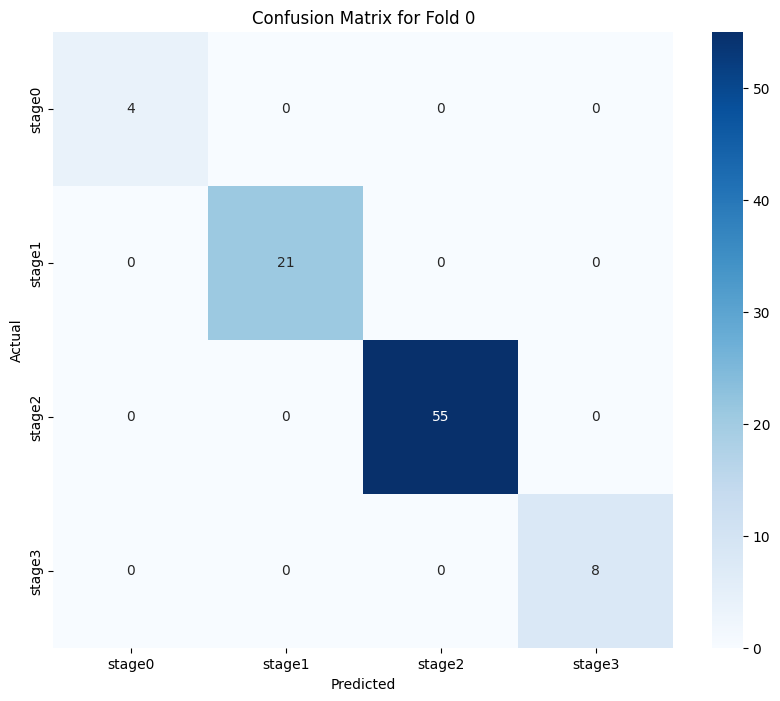

Validation Accuracy for fold 0: 100.0%
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1/10


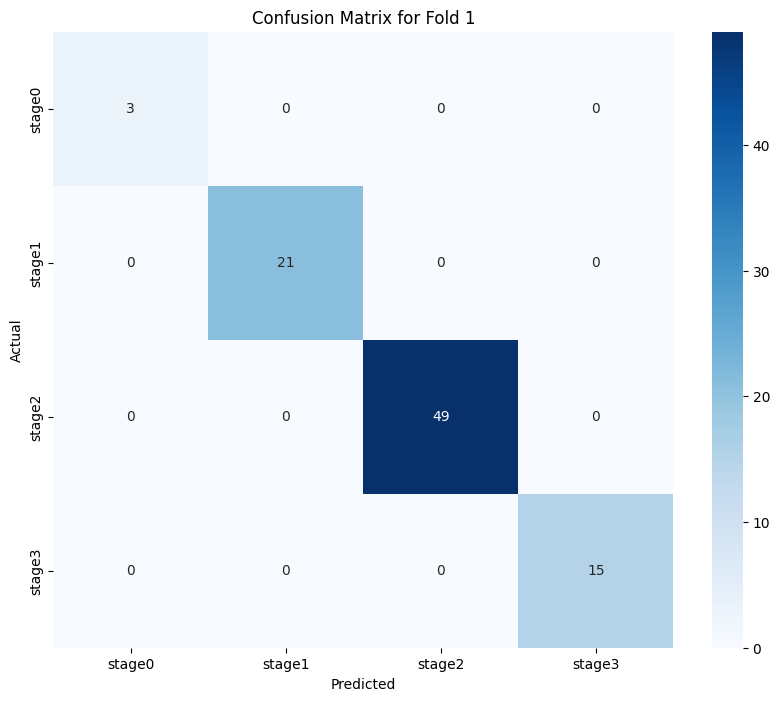

Validation Accuracy for fold 1: 100.0%
Starting epoch 2/10


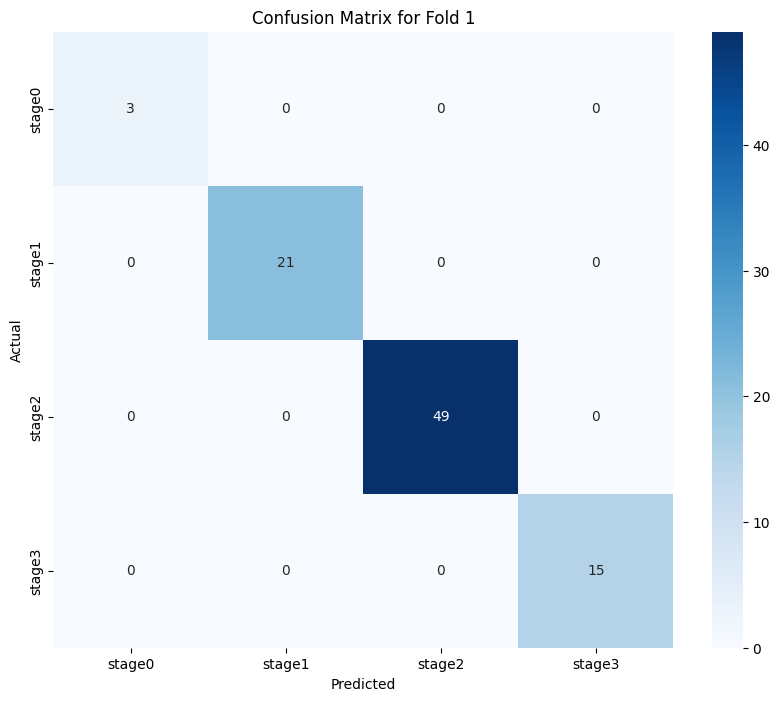

Validation Accuracy for fold 1: 100.0%
Starting epoch 3/10


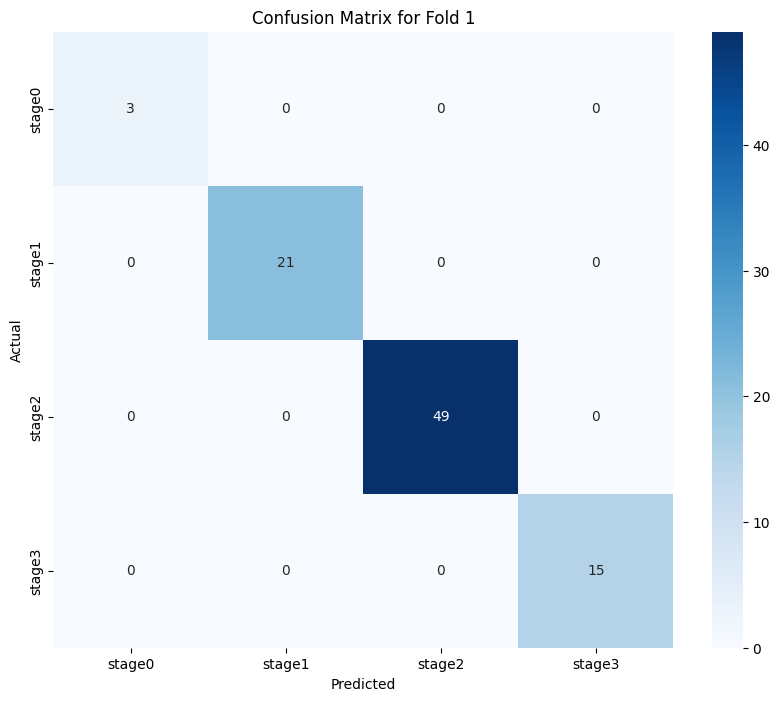

Validation Accuracy for fold 1: 100.0%
Starting epoch 4/10


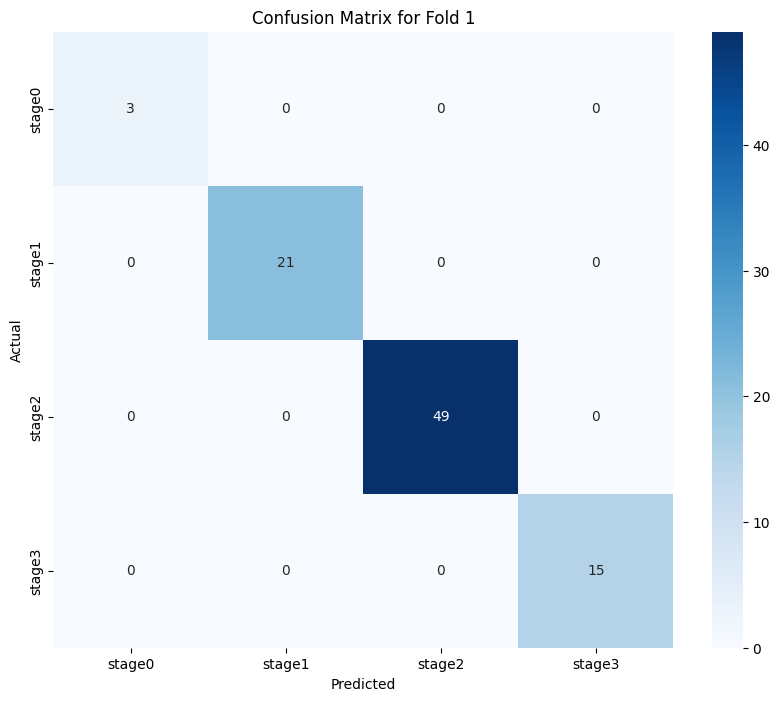

Validation Accuracy for fold 1: 100.0%
Starting epoch 5/10


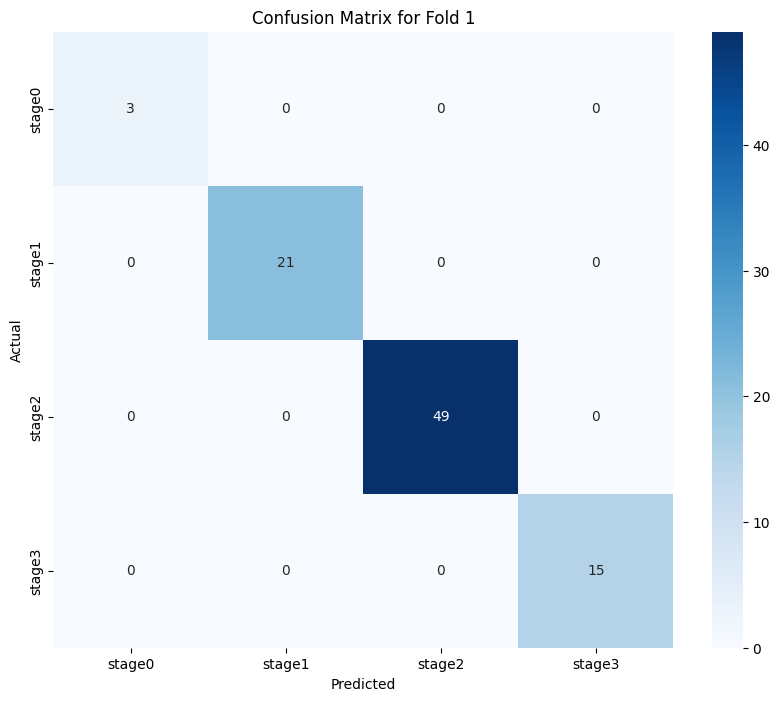

Validation Accuracy for fold 1: 100.0%
Starting epoch 6/10


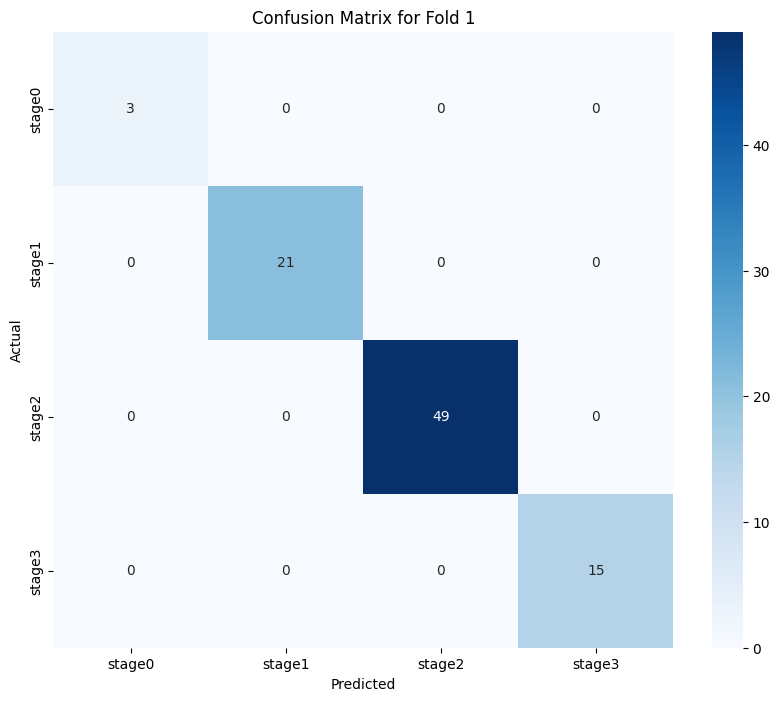

Validation Accuracy for fold 1: 100.0%
Starting epoch 7/10


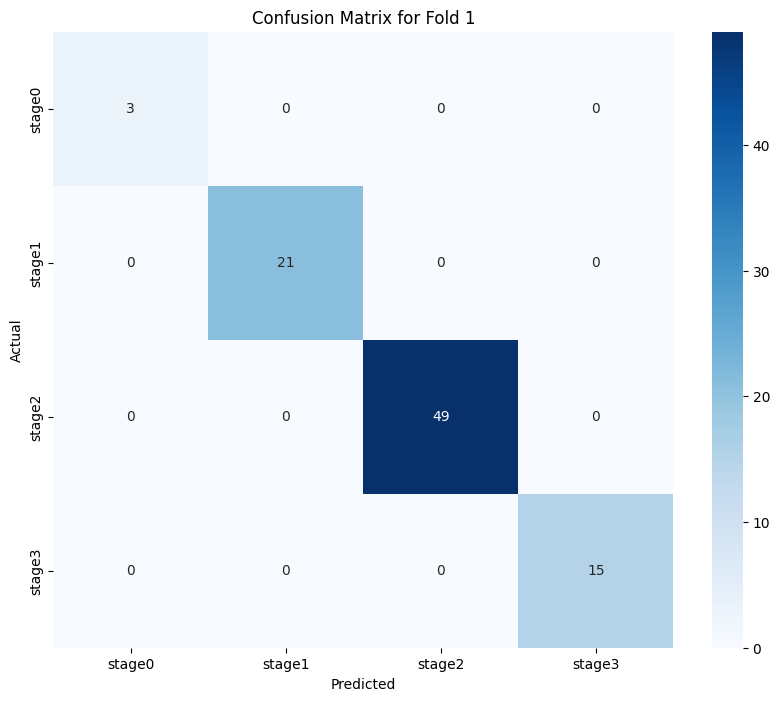

Validation Accuracy for fold 1: 100.0%
Starting epoch 8/10


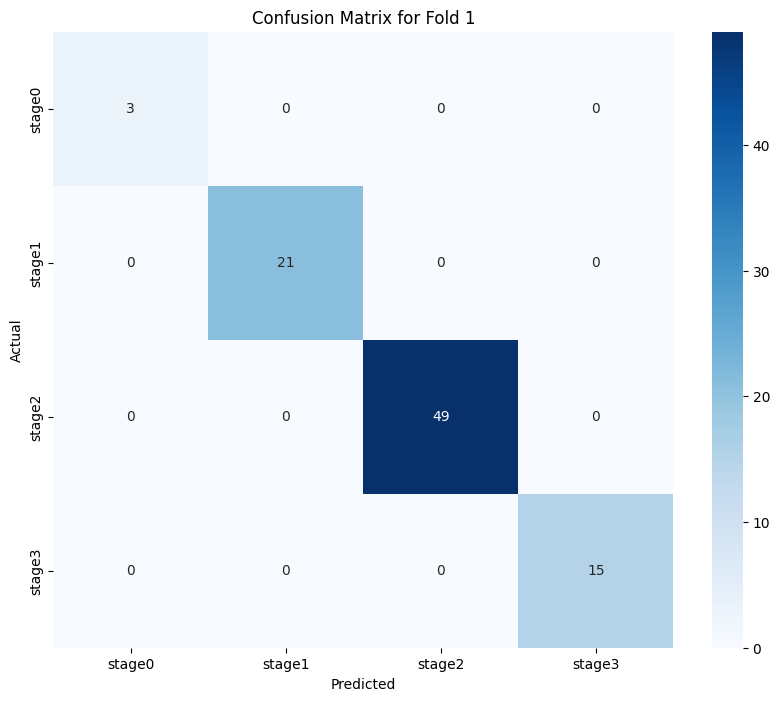

Validation Accuracy for fold 1: 100.0%
Starting epoch 9/10


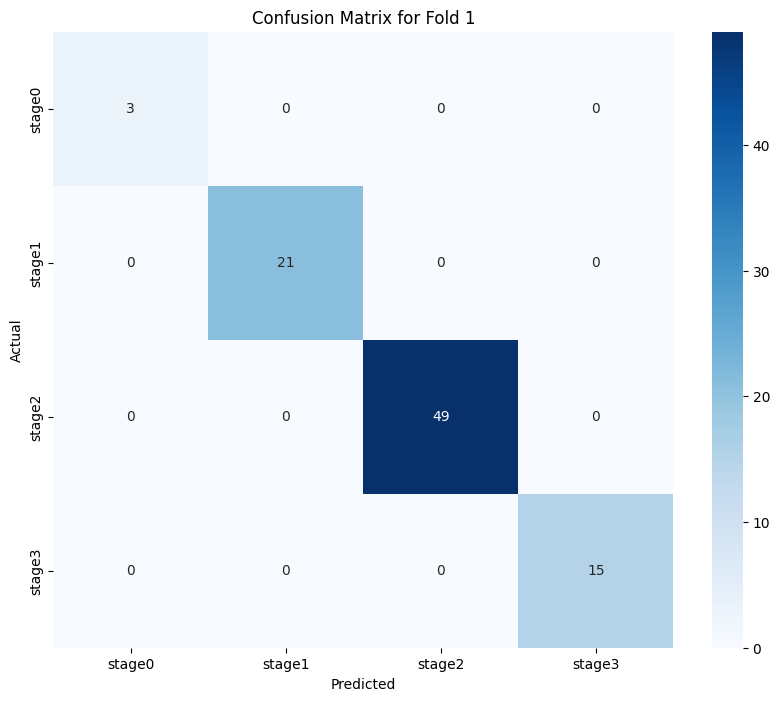

Validation Accuracy for fold 1: 100.0%
Starting epoch 10/10


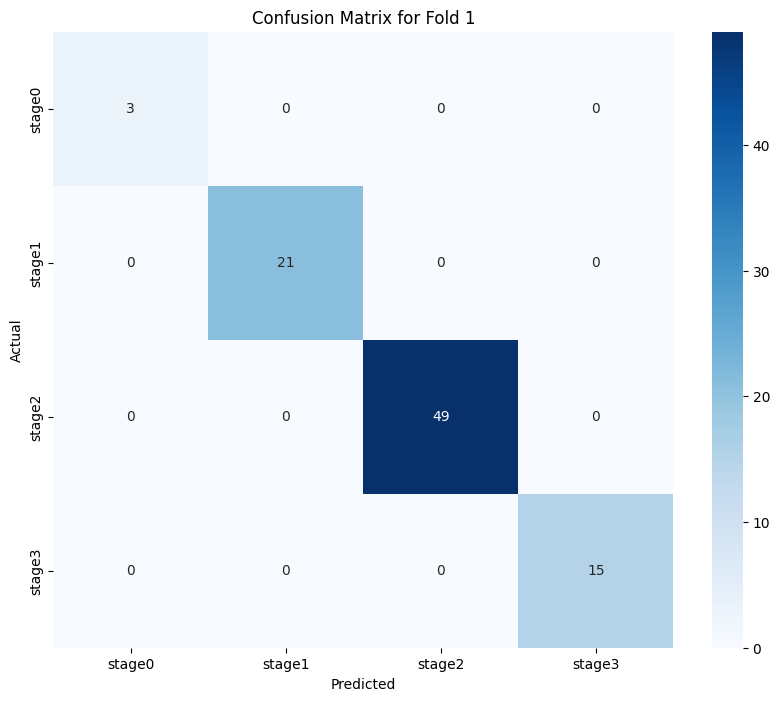

Validation Accuracy for fold 1: 100.0%
--------------------------------
FOLD 2
--------------------------------
Starting epoch 1/10


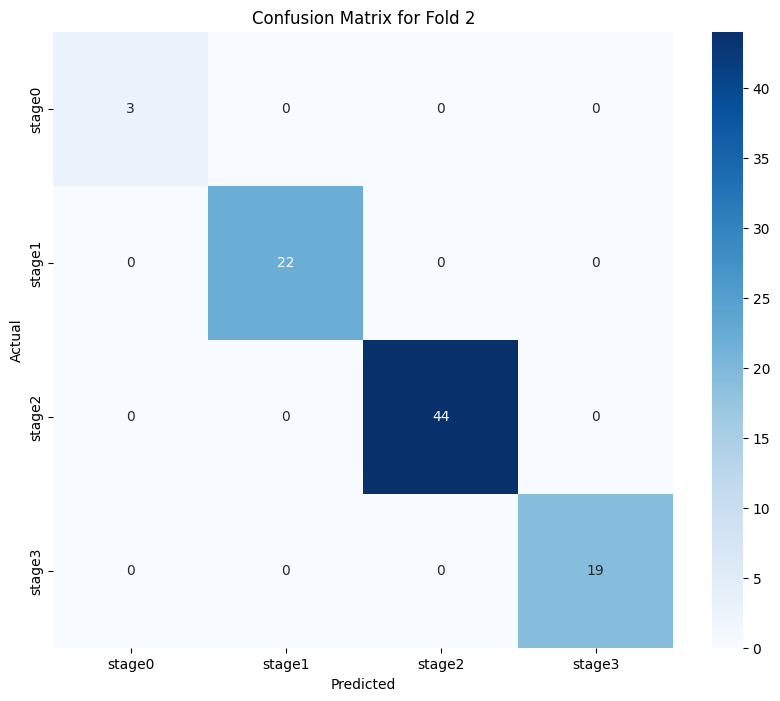

Validation Accuracy for fold 2: 100.0%
Starting epoch 2/10


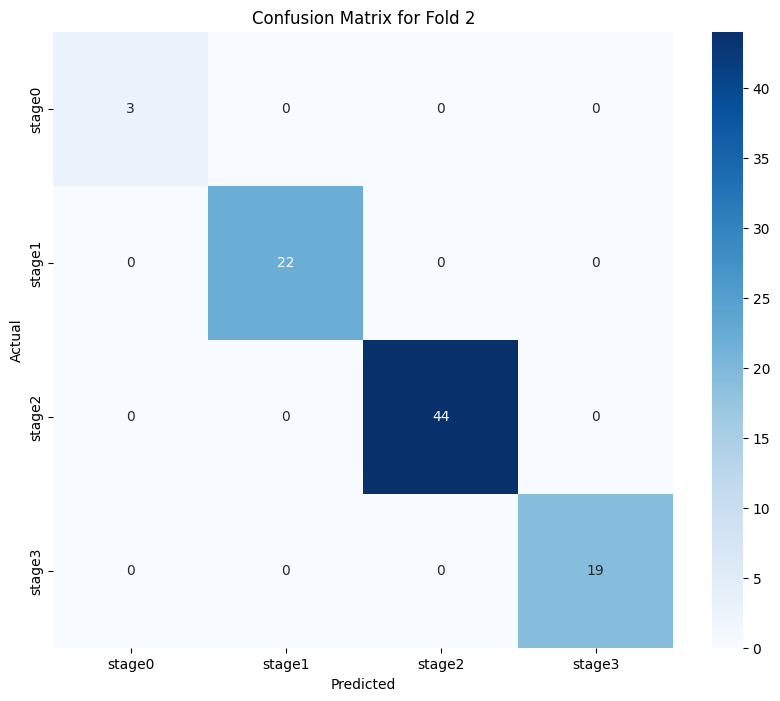

Validation Accuracy for fold 2: 100.0%
Starting epoch 3/10


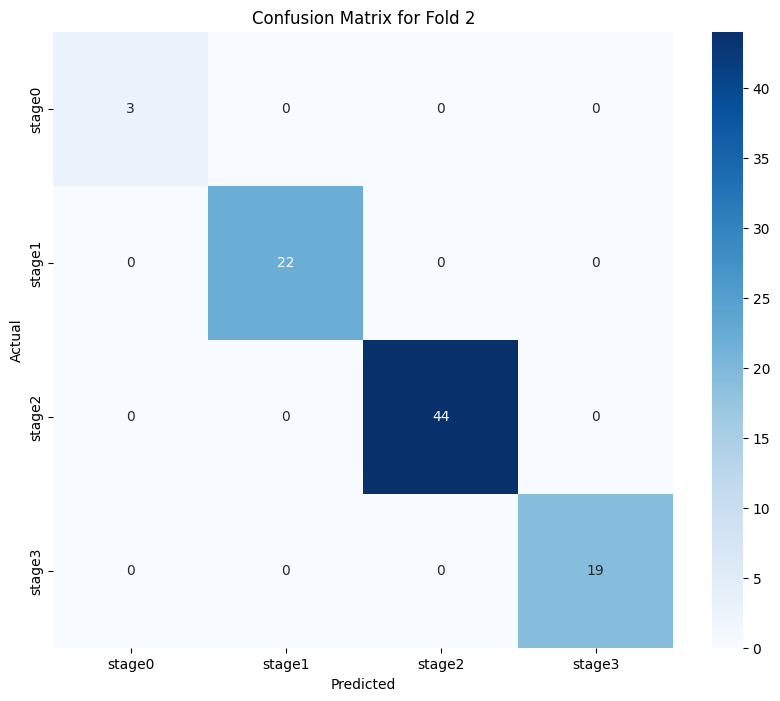

Validation Accuracy for fold 2: 100.0%
Starting epoch 4/10


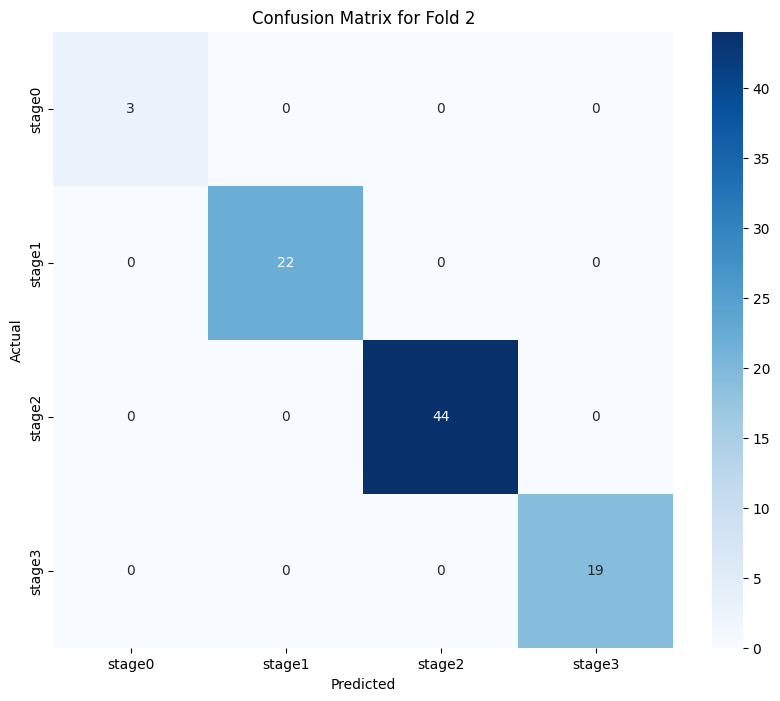

Validation Accuracy for fold 2: 100.0%
Starting epoch 5/10


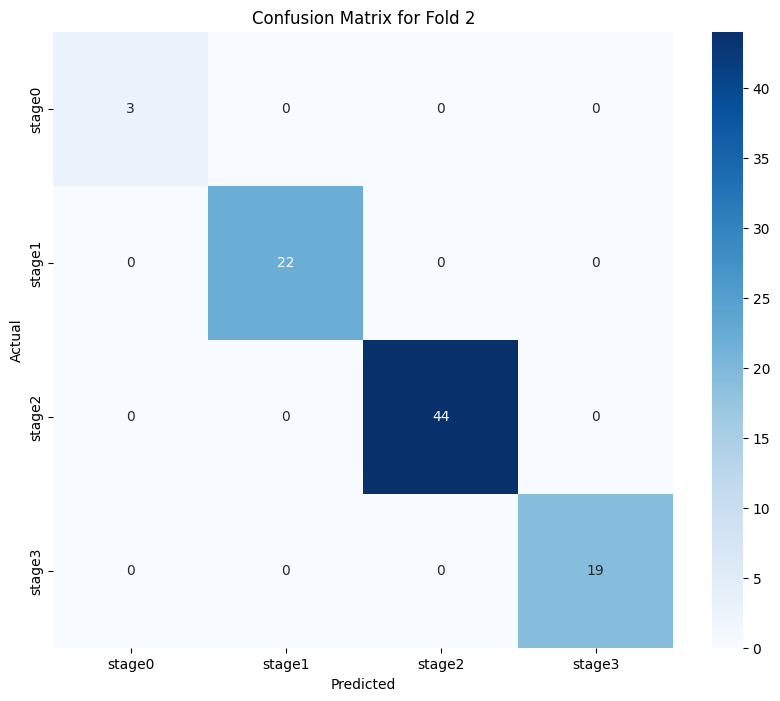

Validation Accuracy for fold 2: 100.0%
Starting epoch 6/10


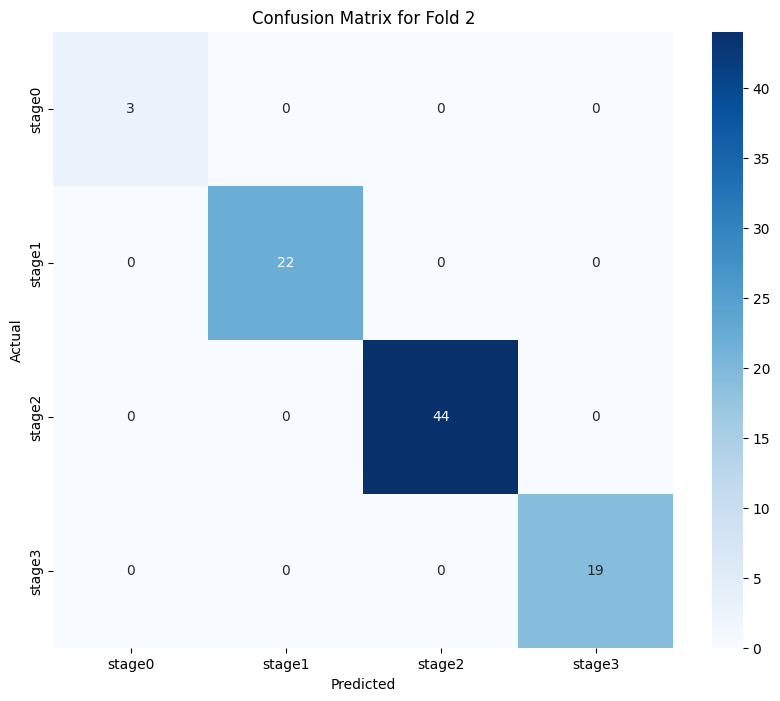

Validation Accuracy for fold 2: 100.0%
Starting epoch 7/10


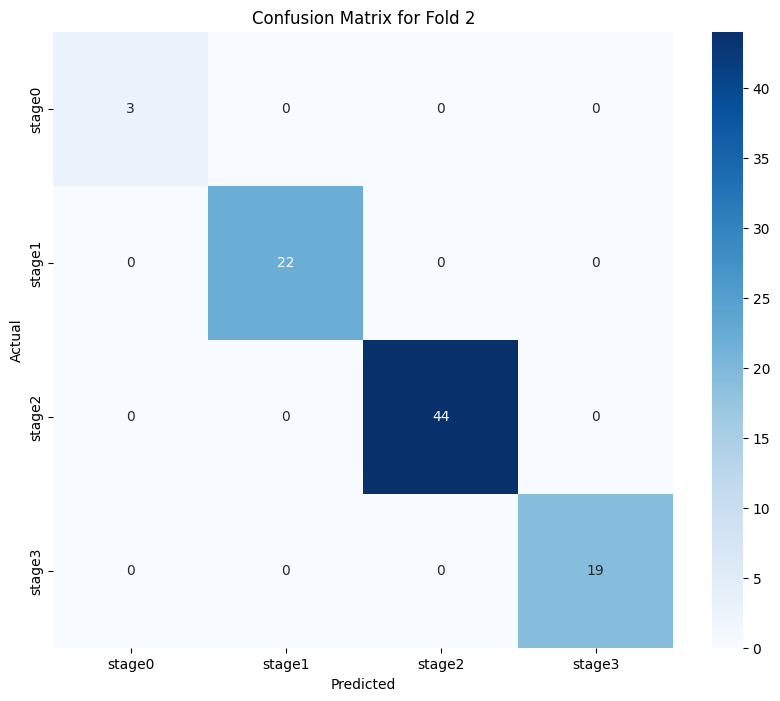

Validation Accuracy for fold 2: 100.0%
Starting epoch 8/10


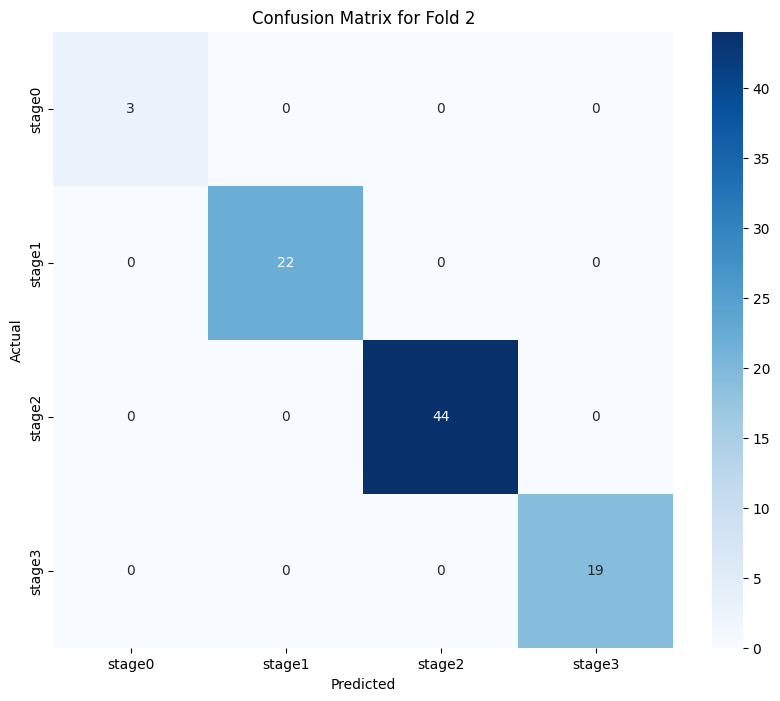

Validation Accuracy for fold 2: 100.0%
Starting epoch 9/10


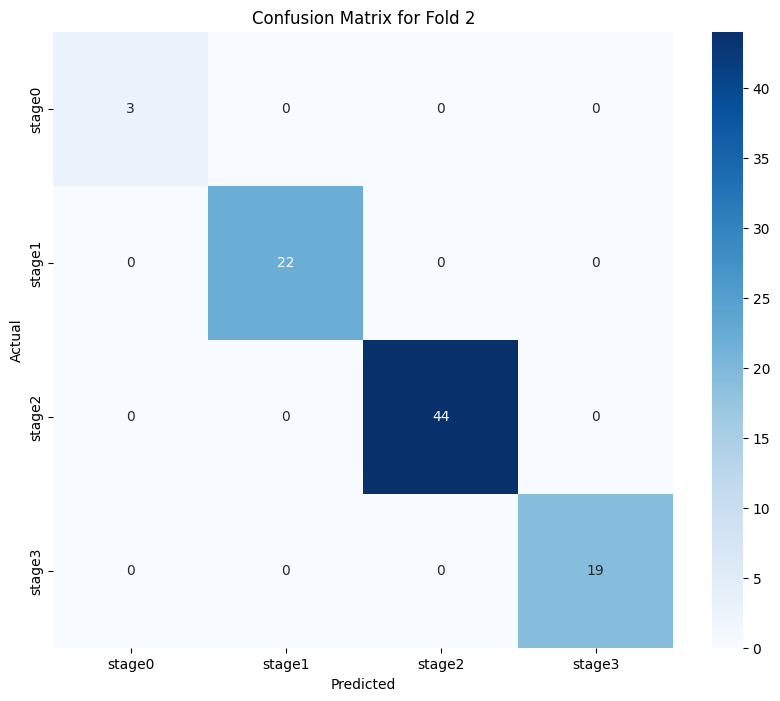

Validation Accuracy for fold 2: 100.0%
Starting epoch 10/10


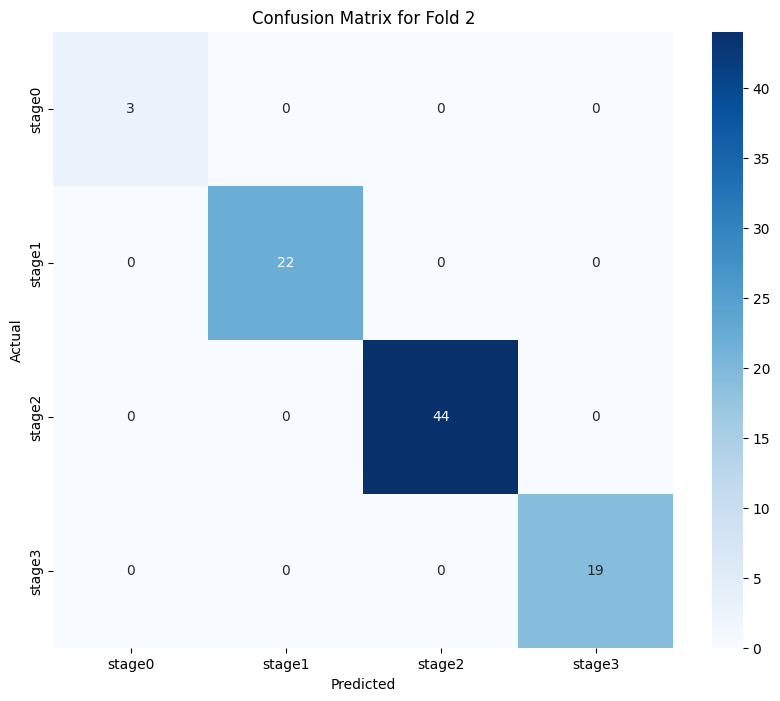

Validation Accuracy for fold 2: 100.0%
--------------------------------
FOLD 3
--------------------------------
Starting epoch 1/10


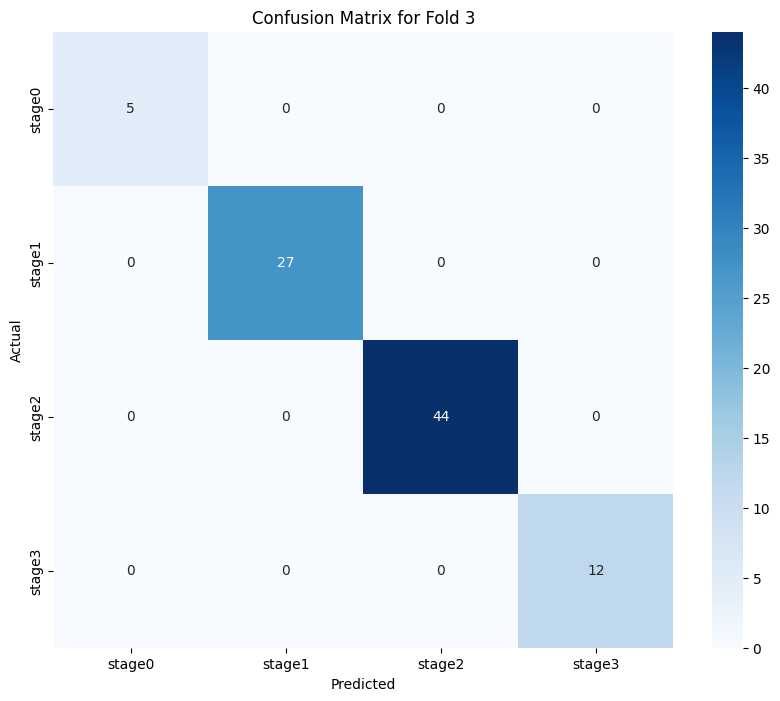

Validation Accuracy for fold 3: 100.0%
Starting epoch 2/10


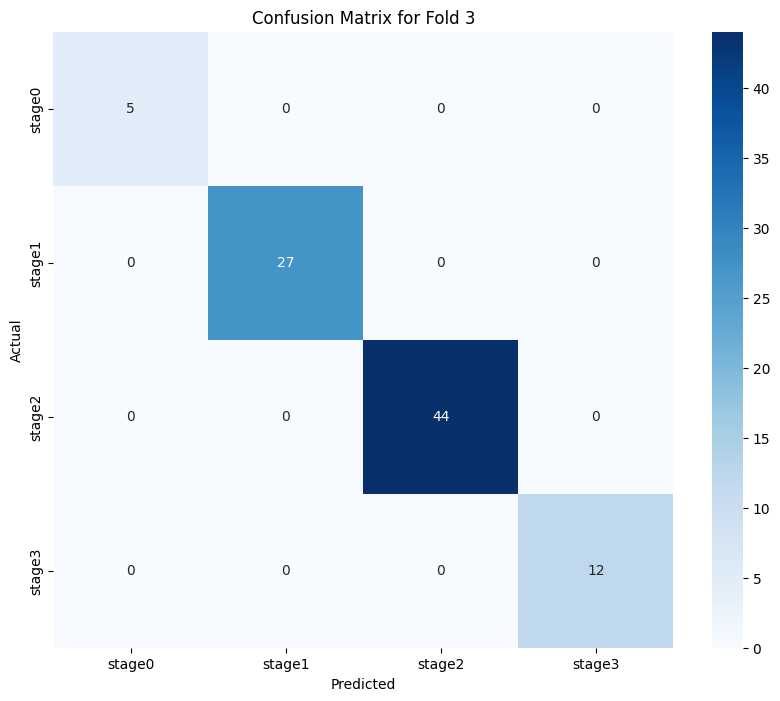

Validation Accuracy for fold 3: 100.0%
Starting epoch 3/10


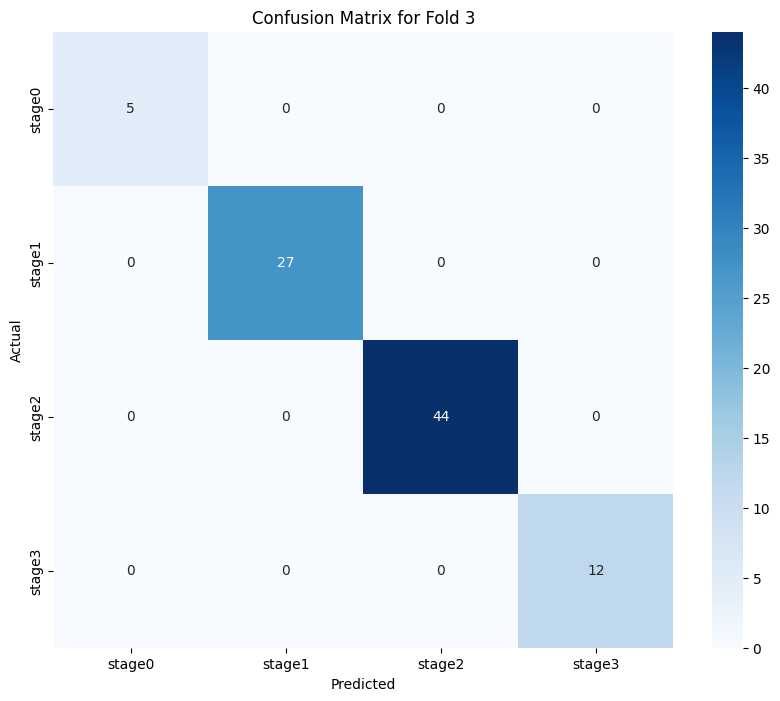

Validation Accuracy for fold 3: 100.0%
Starting epoch 4/10


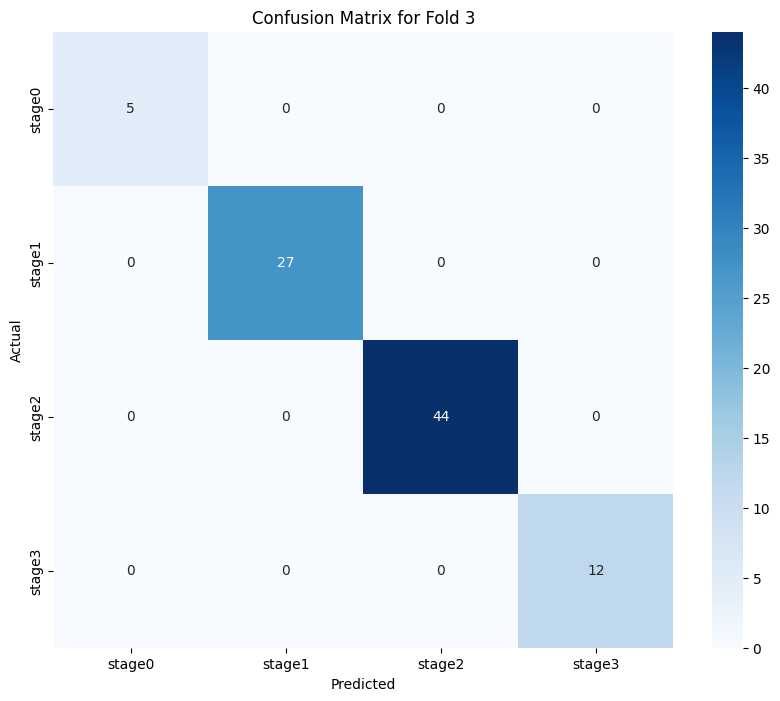

Validation Accuracy for fold 3: 100.0%
Starting epoch 5/10


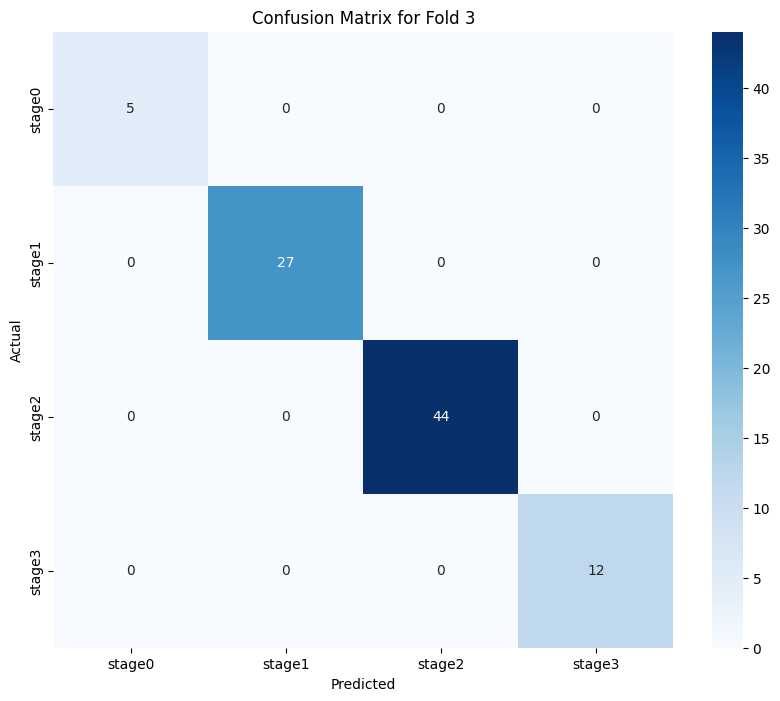

Validation Accuracy for fold 3: 100.0%
Starting epoch 6/10


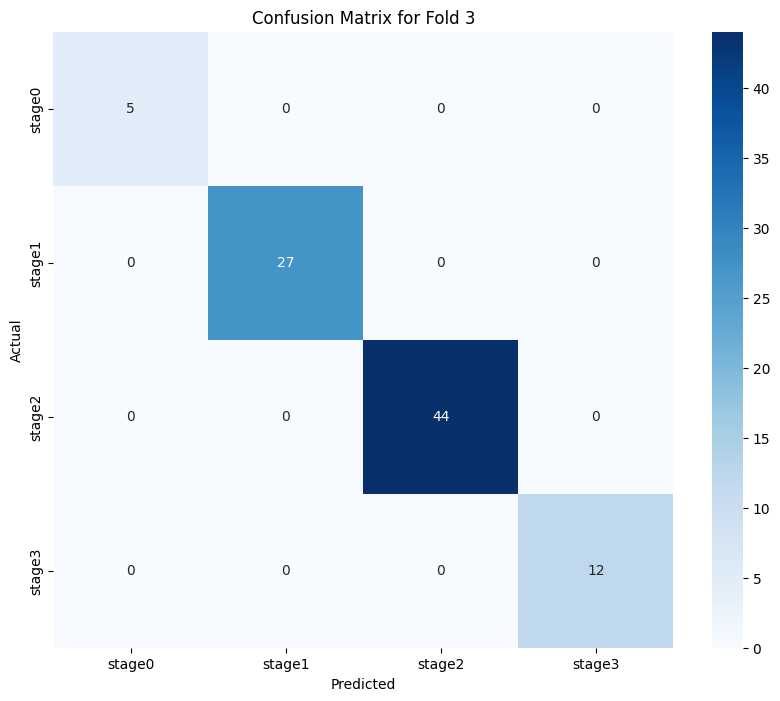

Validation Accuracy for fold 3: 100.0%
Starting epoch 7/10


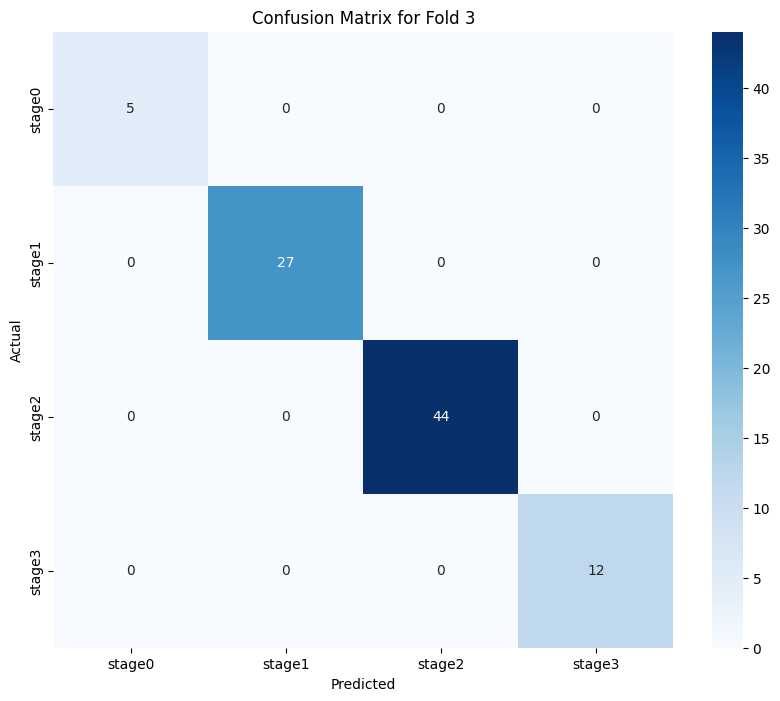

Validation Accuracy for fold 3: 100.0%
Starting epoch 8/10


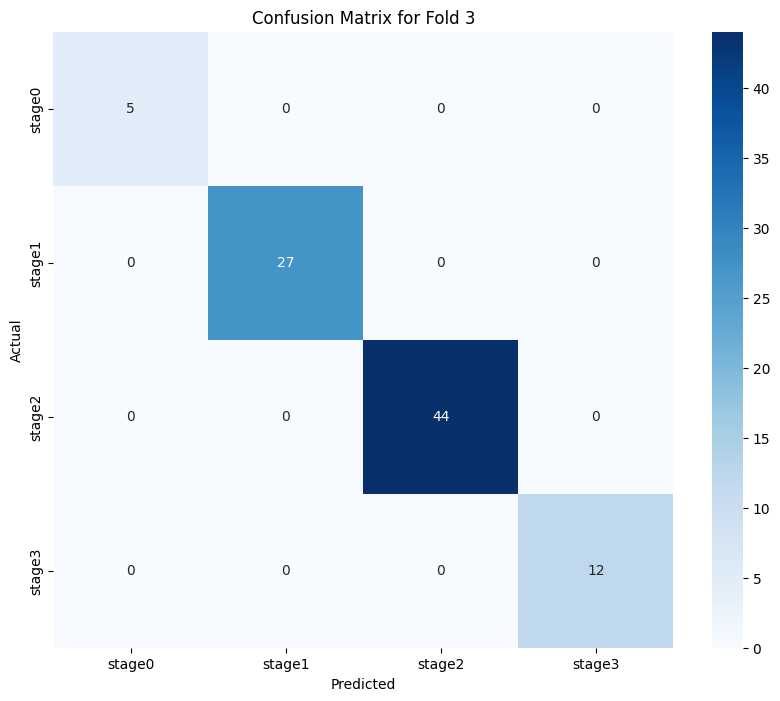

Validation Accuracy for fold 3: 100.0%
Starting epoch 9/10


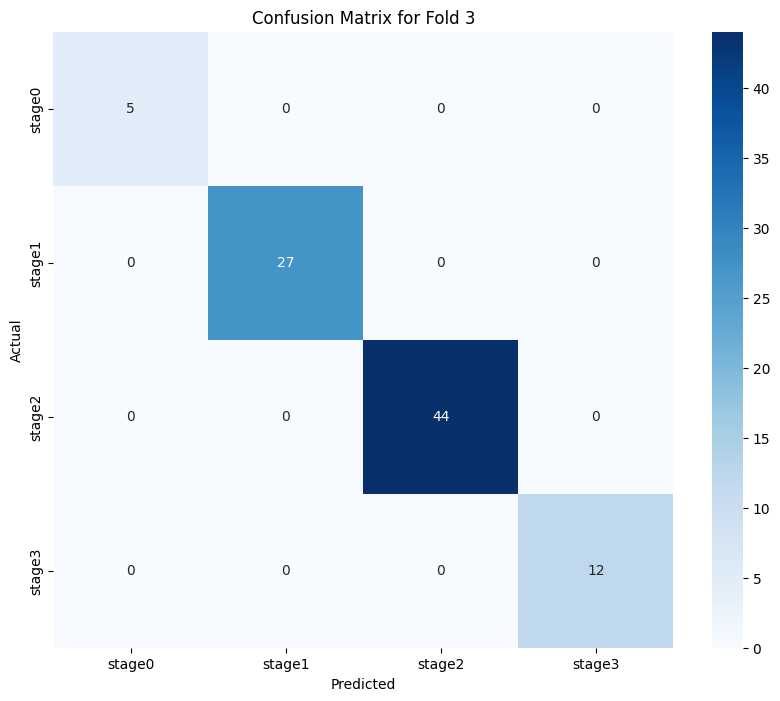

Validation Accuracy for fold 3: 100.0%
Starting epoch 10/10


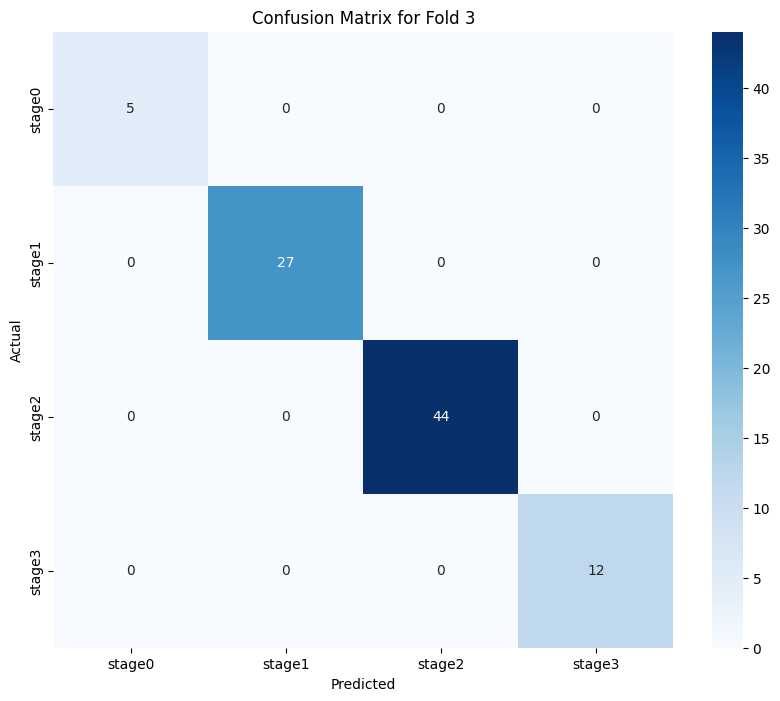

Validation Accuracy for fold 3: 100.0%
--------------------------------
FOLD 4
--------------------------------
Starting epoch 1/10


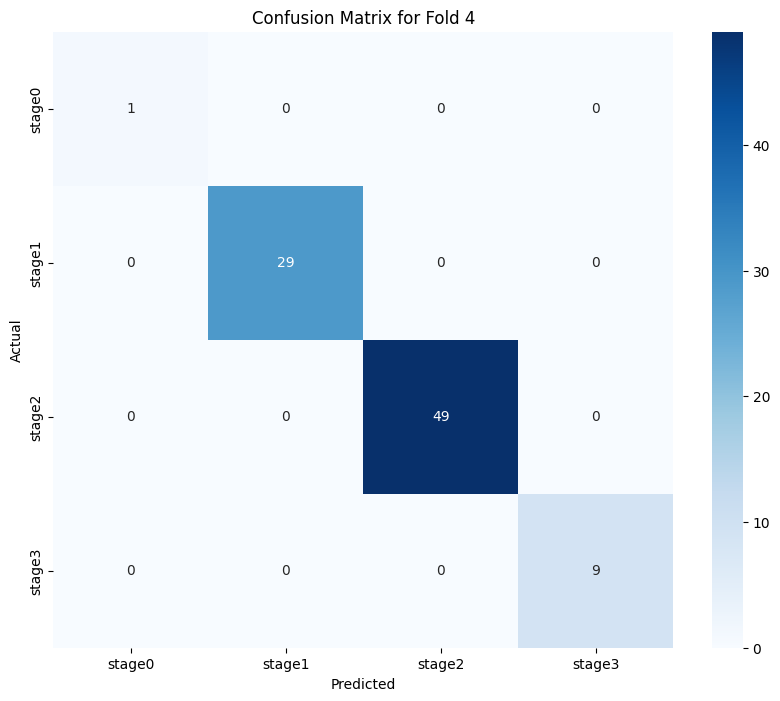

Validation Accuracy for fold 4: 100.0%
Starting epoch 2/10


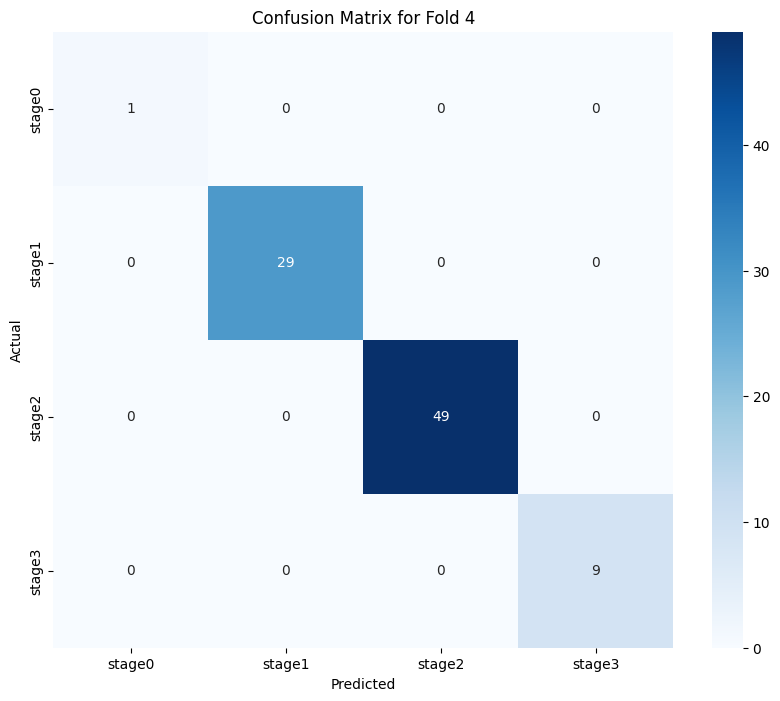

Validation Accuracy for fold 4: 100.0%
Starting epoch 3/10


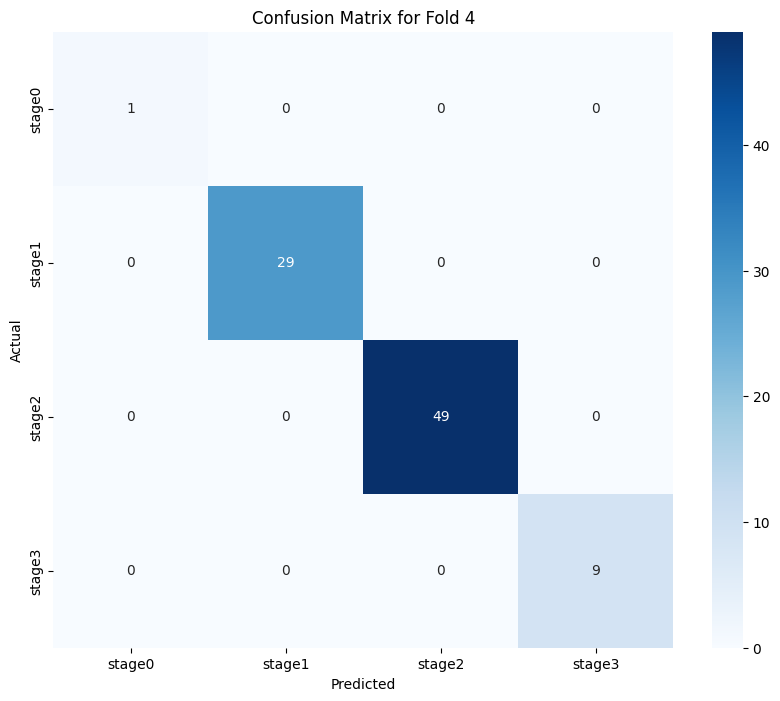

Validation Accuracy for fold 4: 100.0%
Starting epoch 4/10


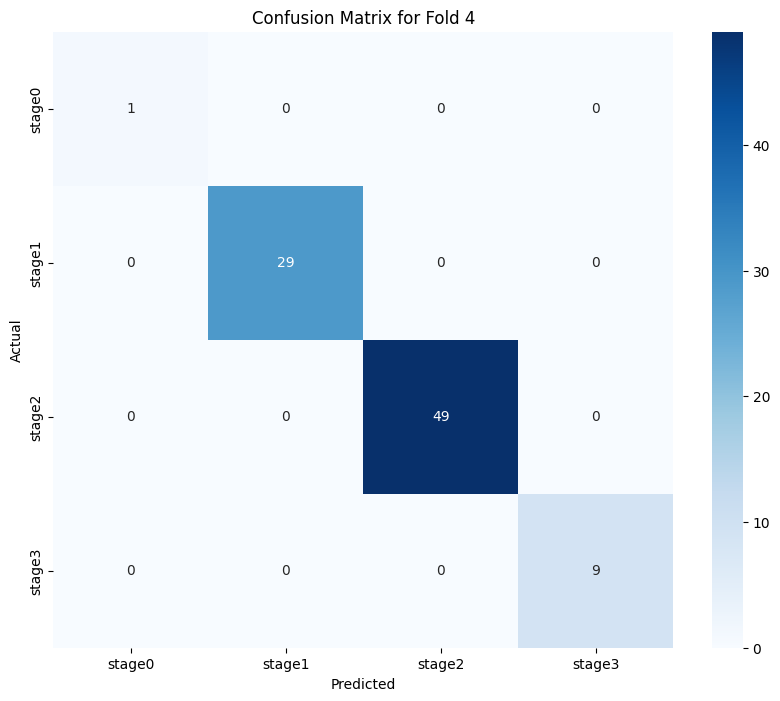

Validation Accuracy for fold 4: 100.0%
Starting epoch 5/10


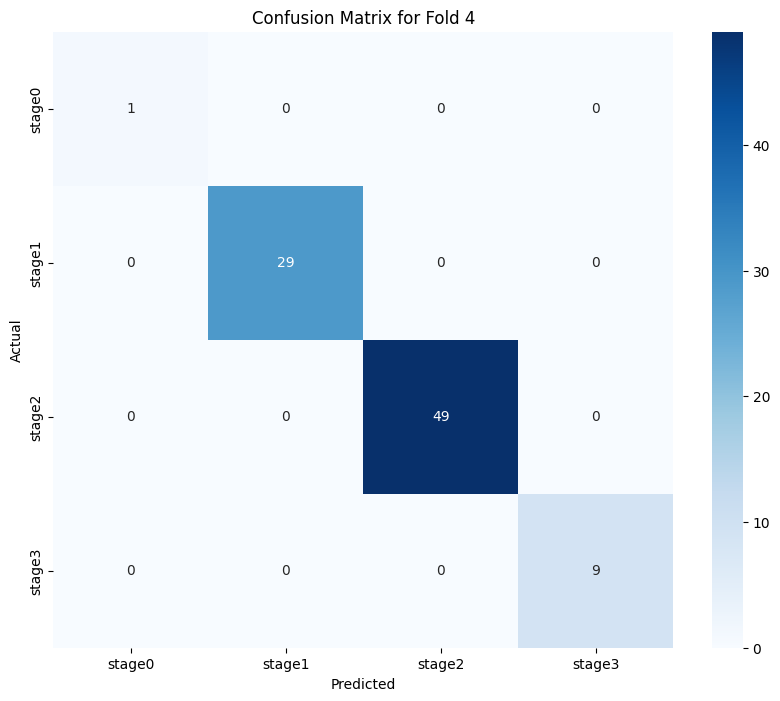

Validation Accuracy for fold 4: 100.0%
Starting epoch 6/10


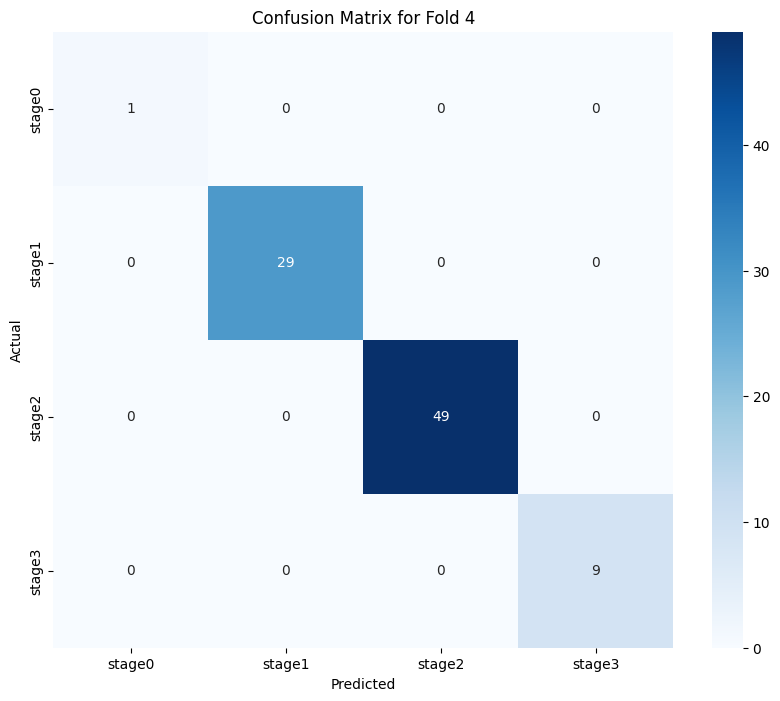

Validation Accuracy for fold 4: 100.0%
Starting epoch 7/10


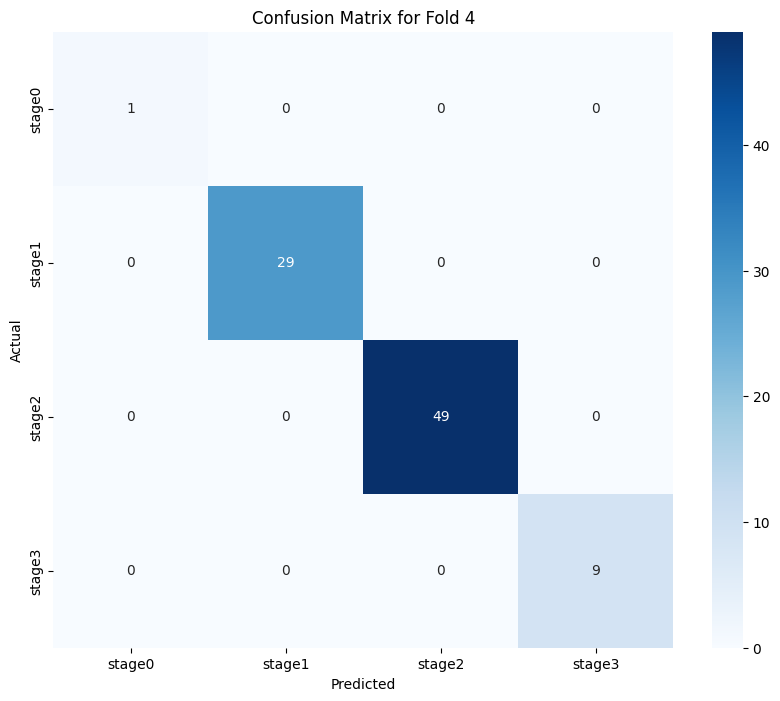

Validation Accuracy for fold 4: 100.0%
Starting epoch 8/10


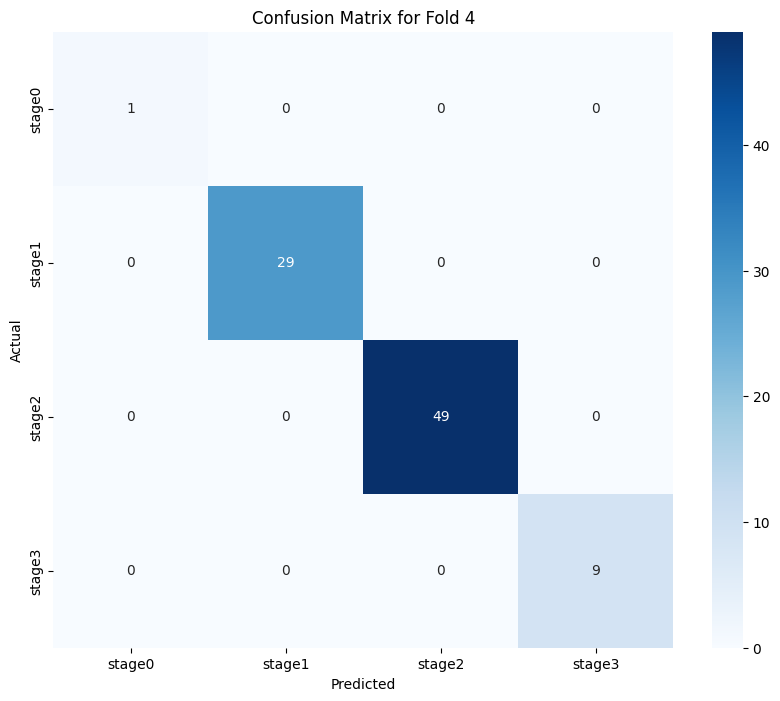

Validation Accuracy for fold 4: 100.0%
Starting epoch 9/10


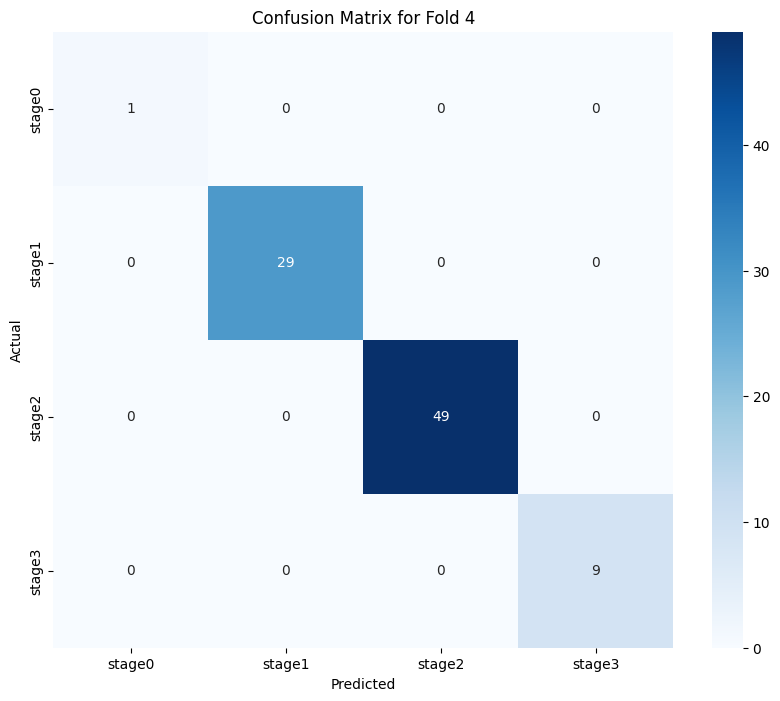

Validation Accuracy for fold 4: 100.0%
Starting epoch 10/10


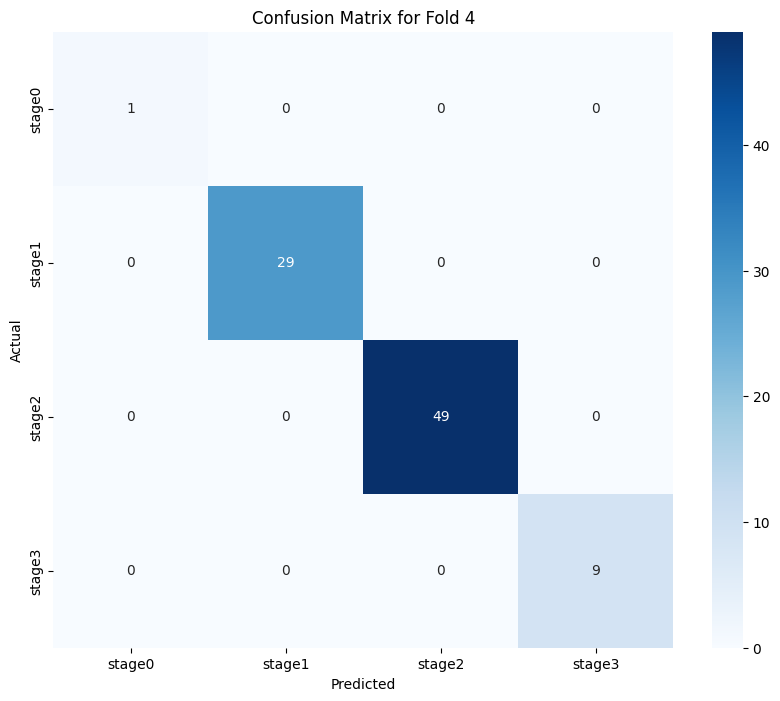

Validation Accuracy for fold 4: 100.0%
--------------------------------
FOLD 5
--------------------------------
Starting epoch 1/10


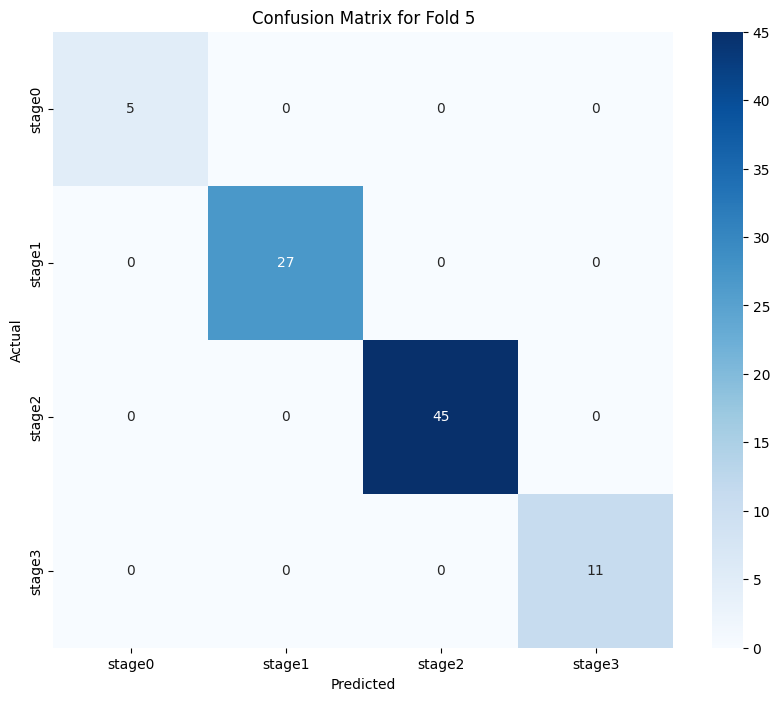

Validation Accuracy for fold 5: 100.0%
Starting epoch 2/10


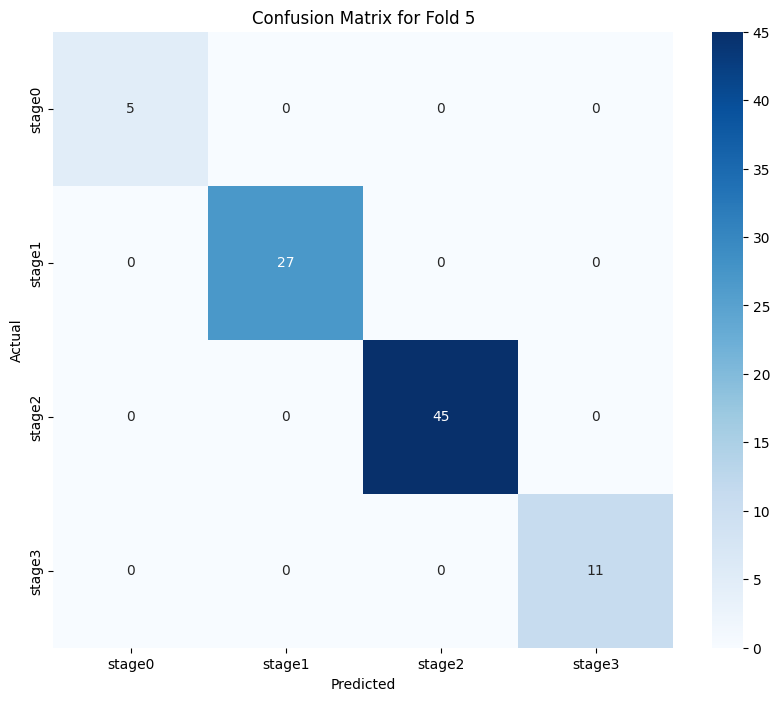

Validation Accuracy for fold 5: 100.0%
Starting epoch 3/10


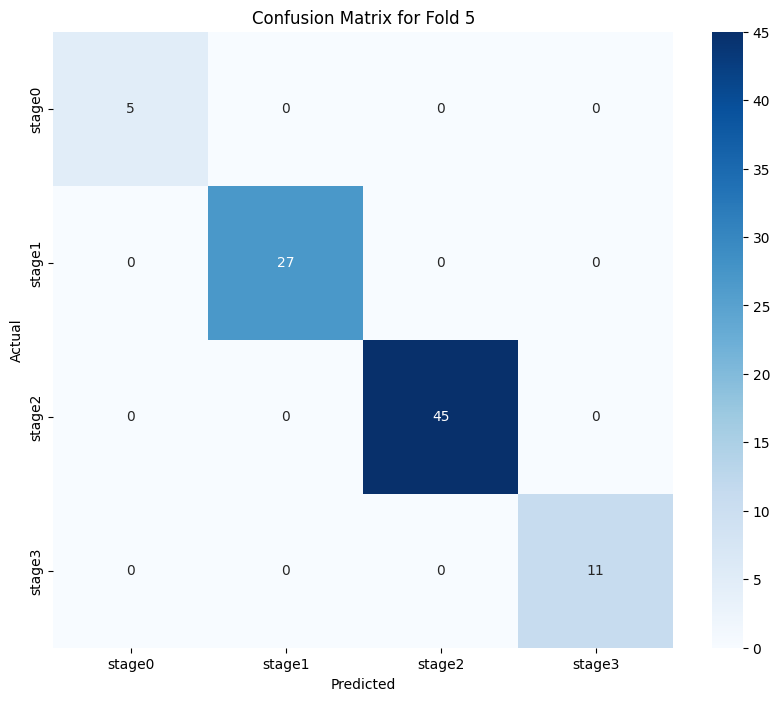

Validation Accuracy for fold 5: 100.0%
Starting epoch 4/10


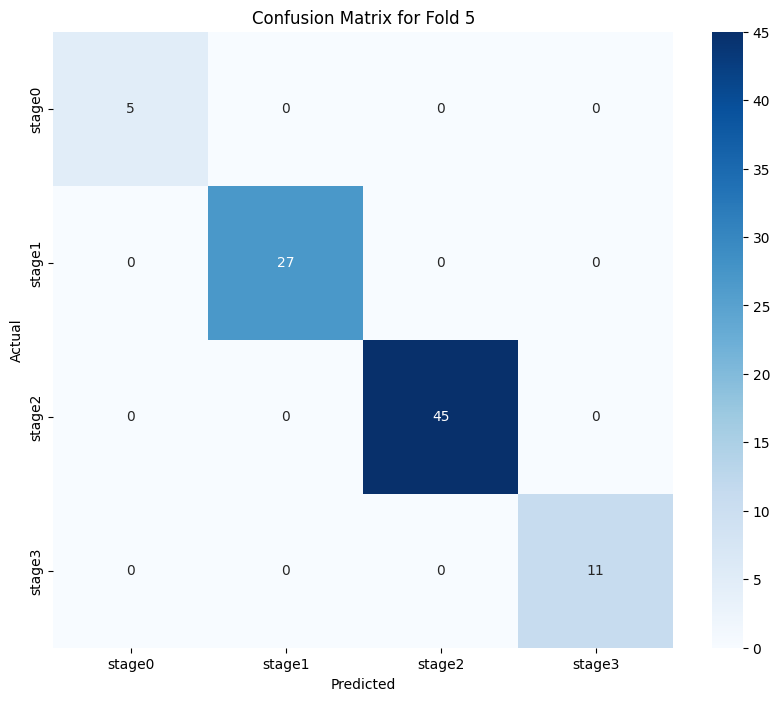

Validation Accuracy for fold 5: 100.0%
Starting epoch 5/10


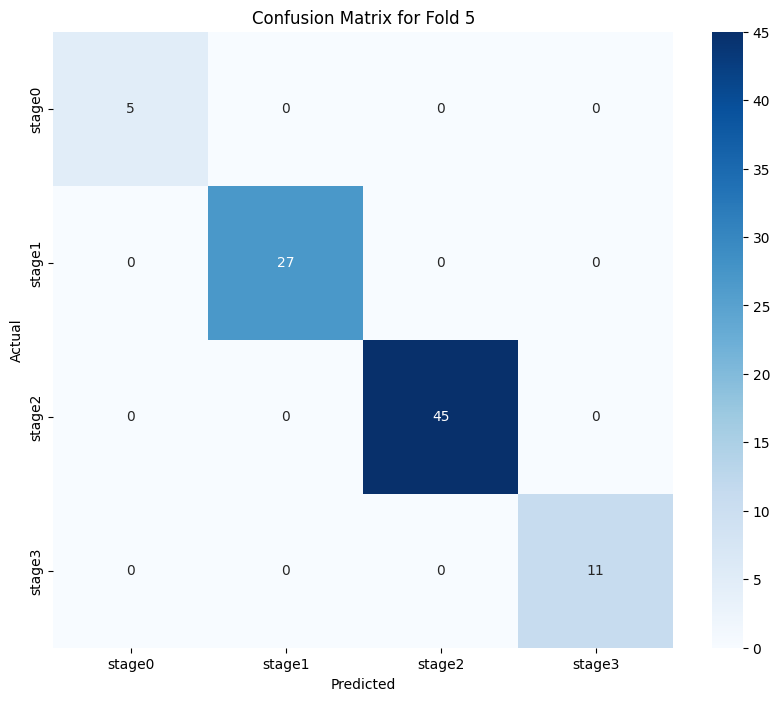

Validation Accuracy for fold 5: 100.0%
Starting epoch 6/10


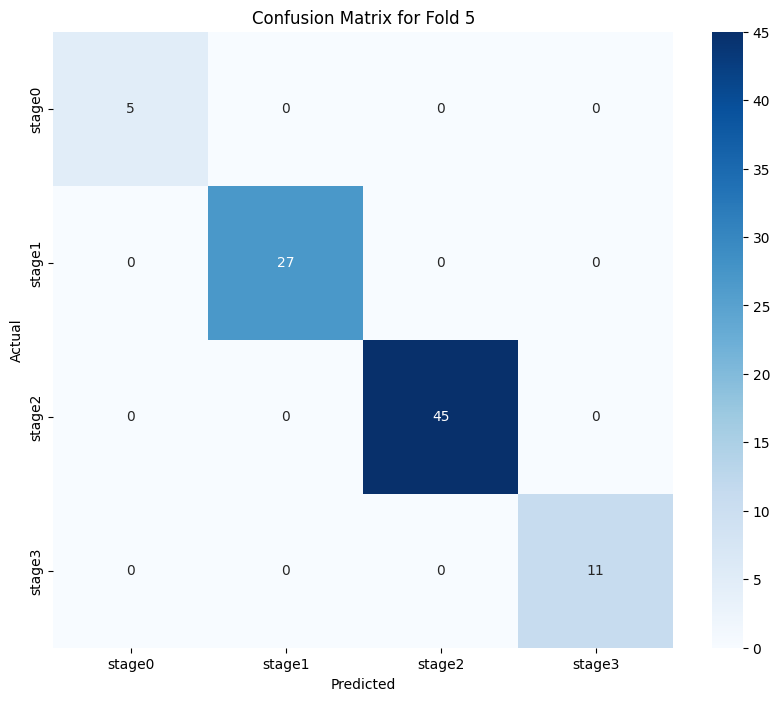

Validation Accuracy for fold 5: 100.0%
Starting epoch 7/10


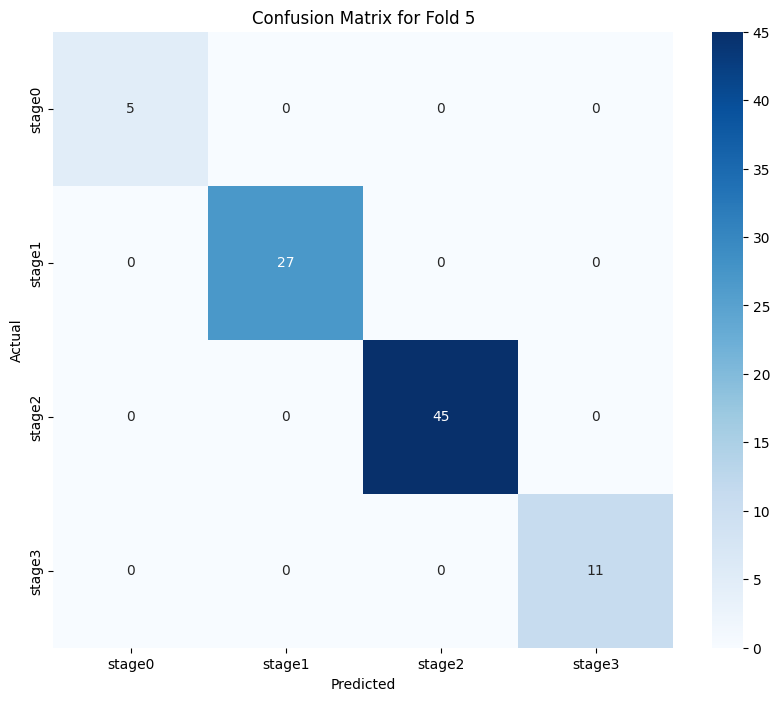

Validation Accuracy for fold 5: 100.0%
Starting epoch 8/10


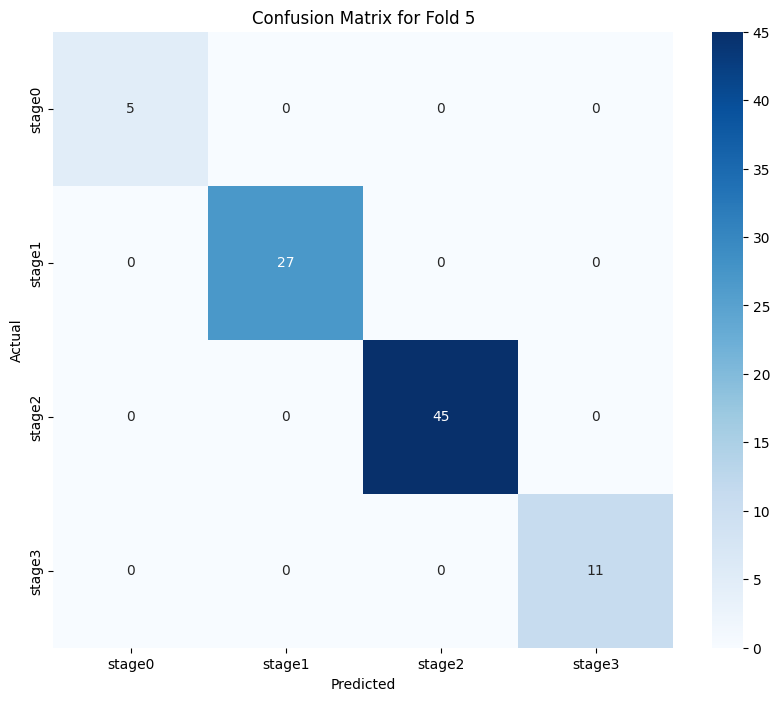

Validation Accuracy for fold 5: 100.0%
Starting epoch 9/10


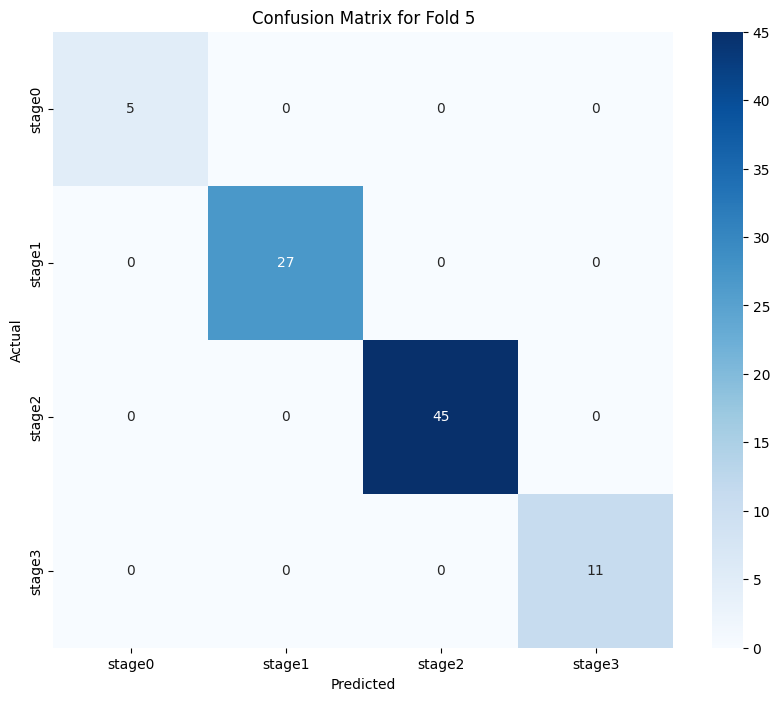

Validation Accuracy for fold 5: 100.0%
Starting epoch 10/10


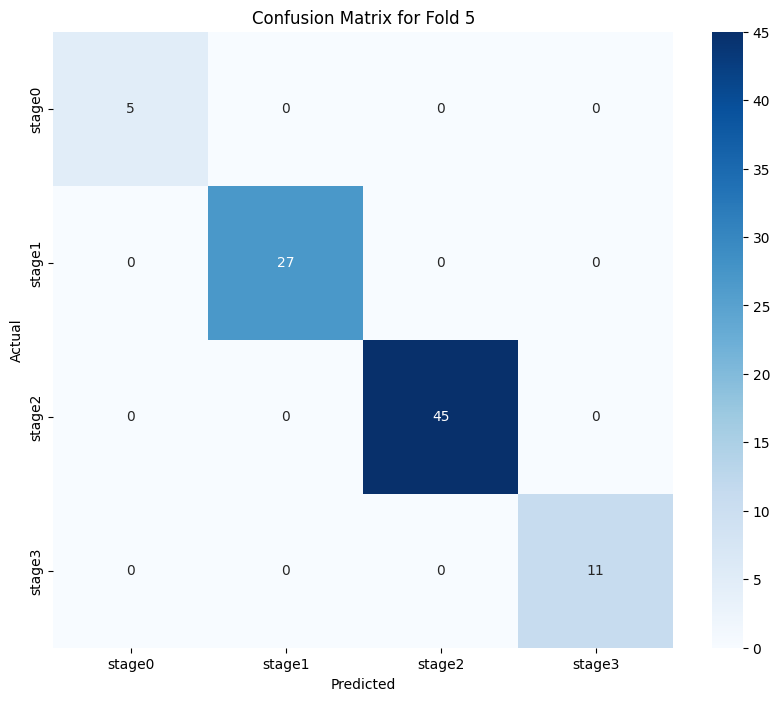

Validation Accuracy for fold 5: 100.0%
--------------------------------
FOLD 6
--------------------------------
Starting epoch 1/10


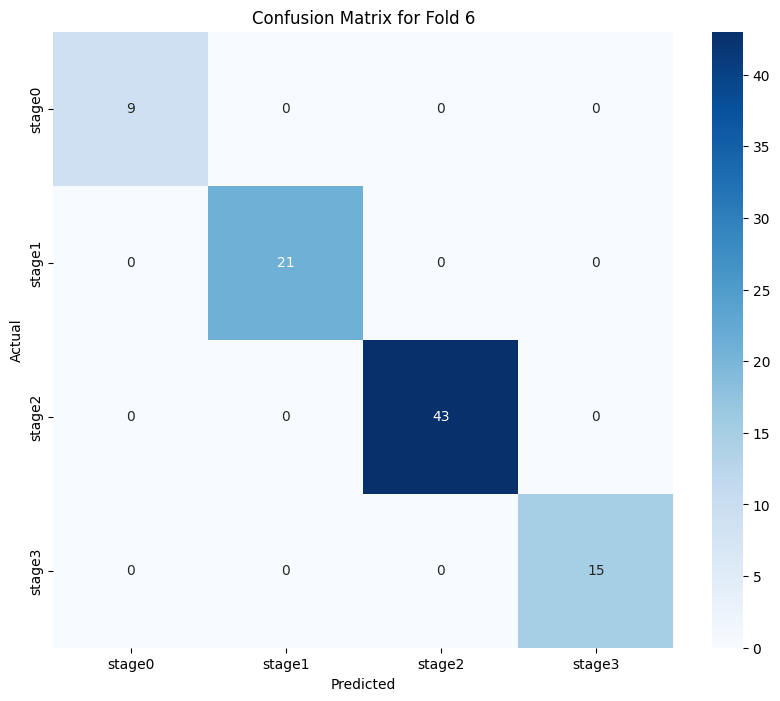

Validation Accuracy for fold 6: 100.0%
Starting epoch 2/10


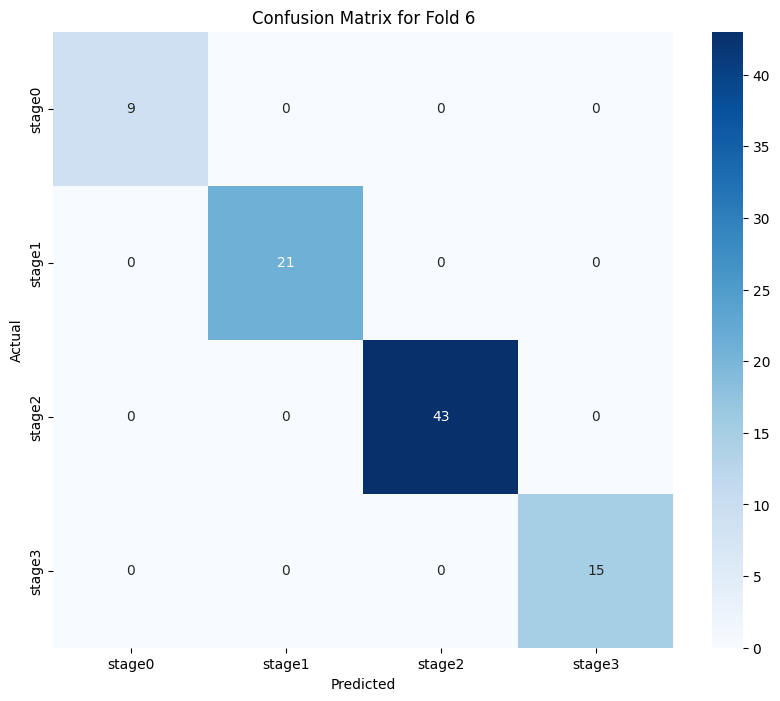

Validation Accuracy for fold 6: 100.0%
Starting epoch 3/10


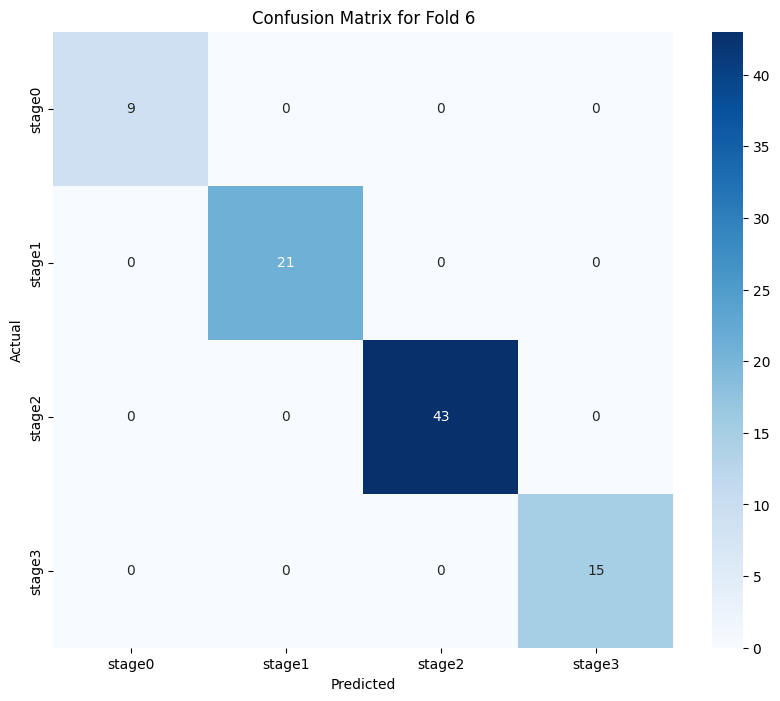

Validation Accuracy for fold 6: 100.0%
Starting epoch 4/10


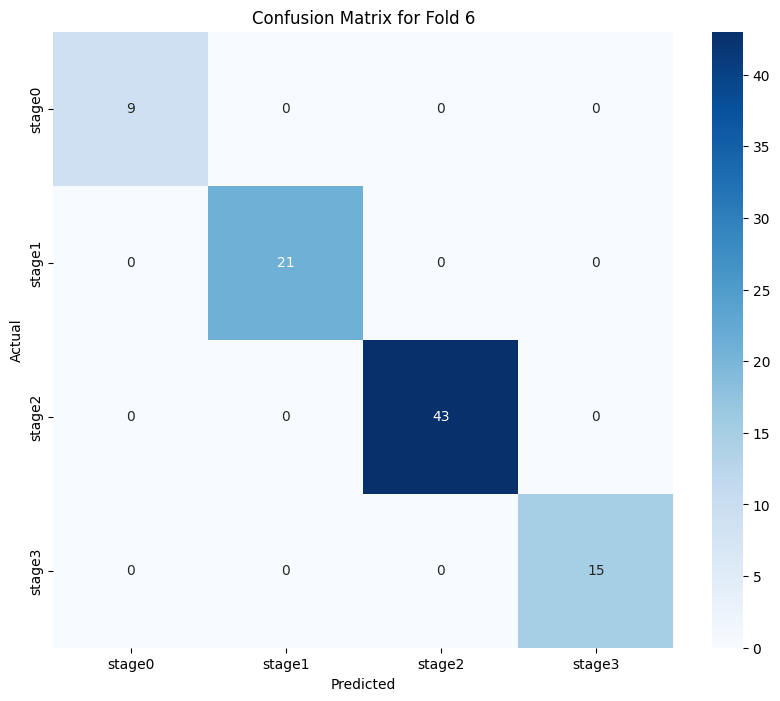

Validation Accuracy for fold 6: 100.0%
Starting epoch 5/10


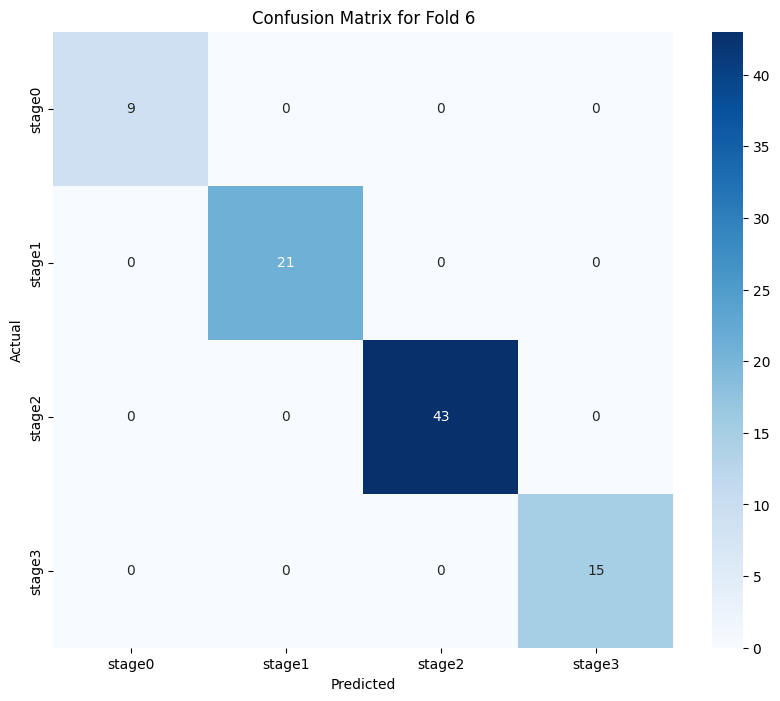

Validation Accuracy for fold 6: 100.0%
Starting epoch 6/10


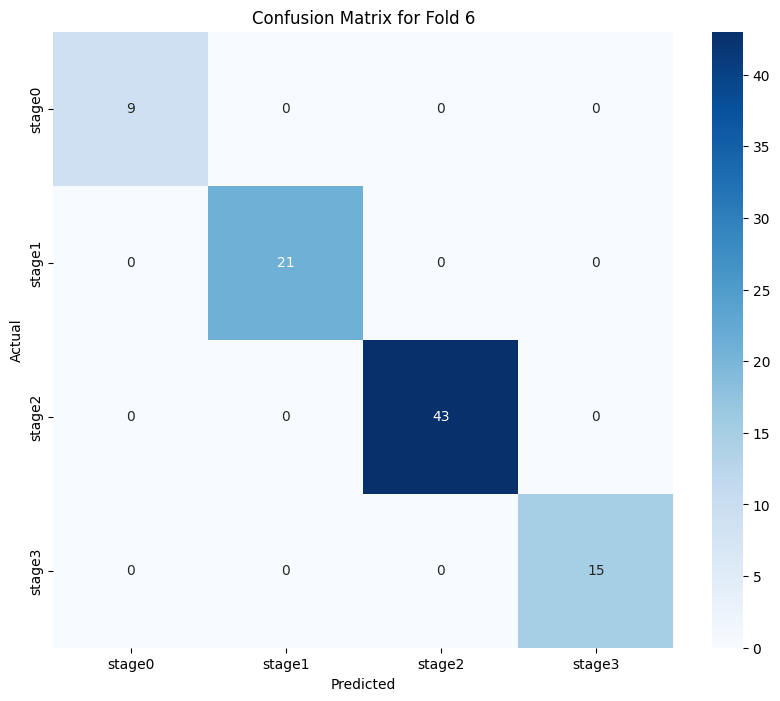

Validation Accuracy for fold 6: 100.0%
Starting epoch 7/10


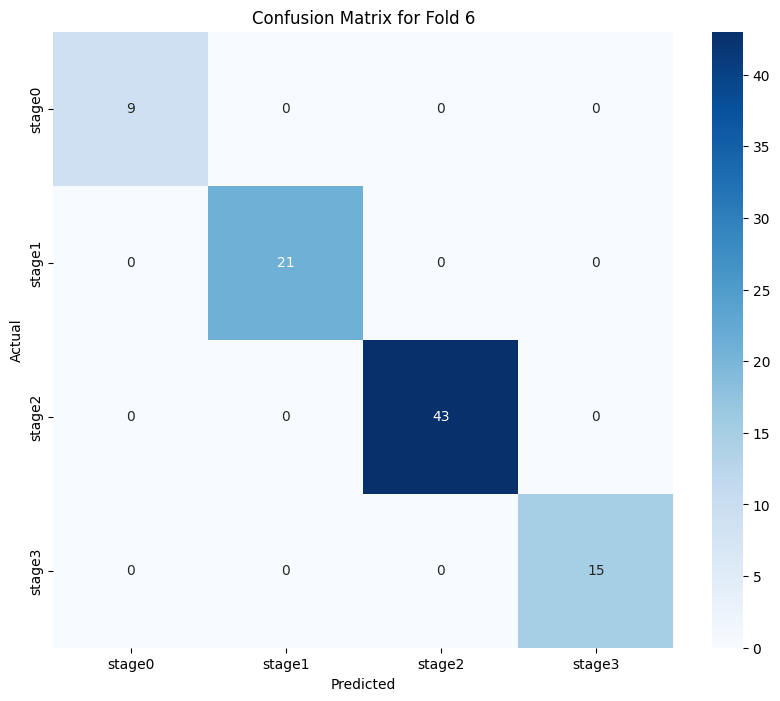

Validation Accuracy for fold 6: 100.0%
Starting epoch 8/10


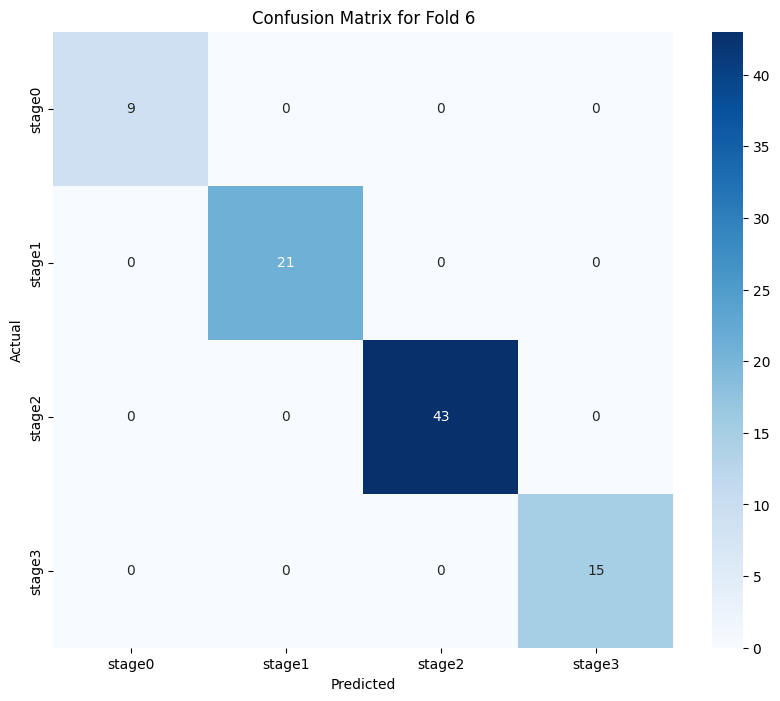

Validation Accuracy for fold 6: 100.0%
Starting epoch 9/10


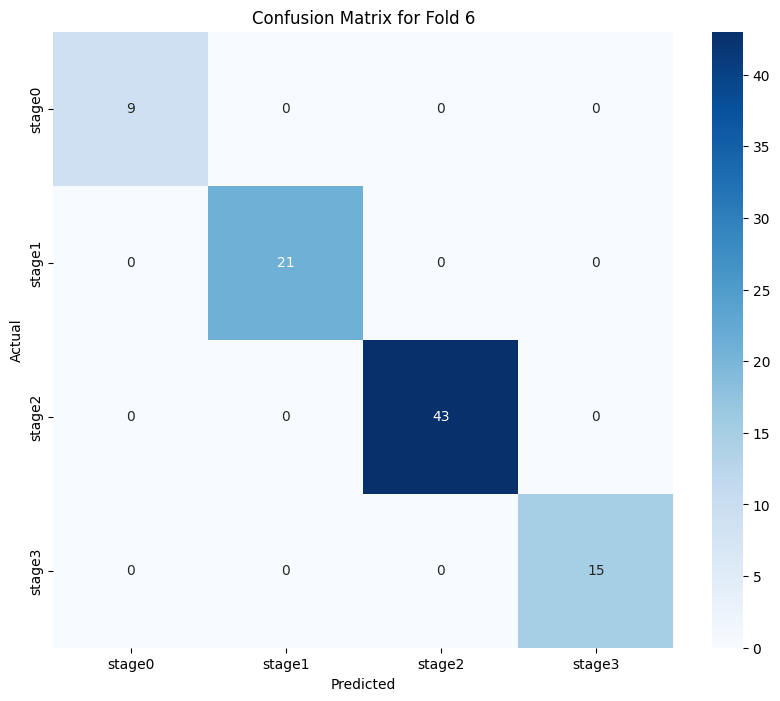

Validation Accuracy for fold 6: 100.0%
Starting epoch 10/10


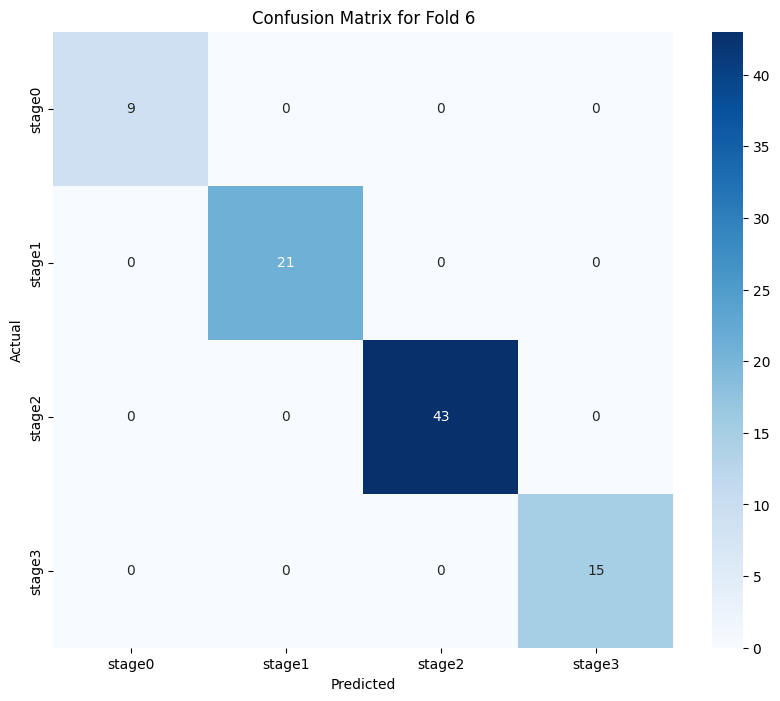

Validation Accuracy for fold 6: 100.0%
--------------------------------
FOLD 7
--------------------------------
Starting epoch 1/10


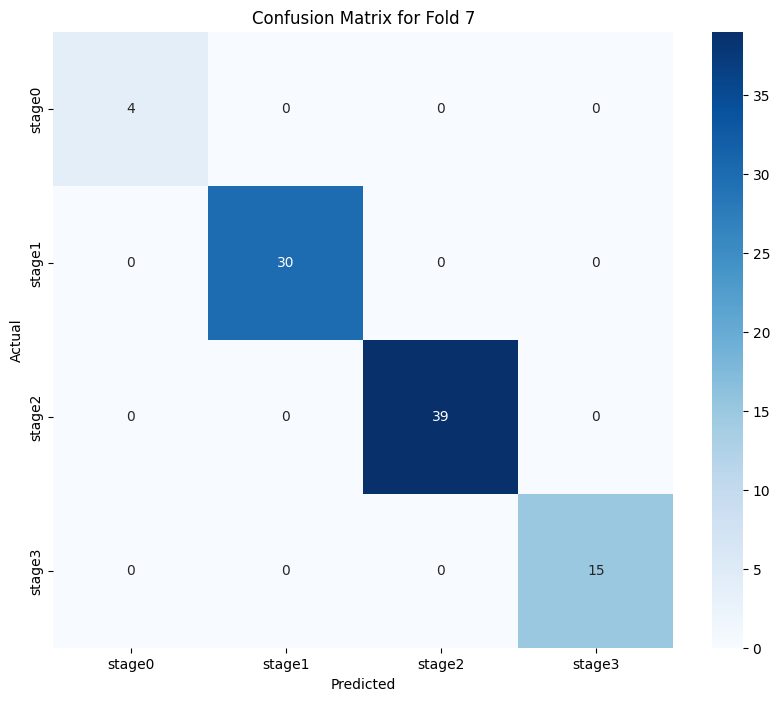

Validation Accuracy for fold 7: 100.0%
Starting epoch 2/10


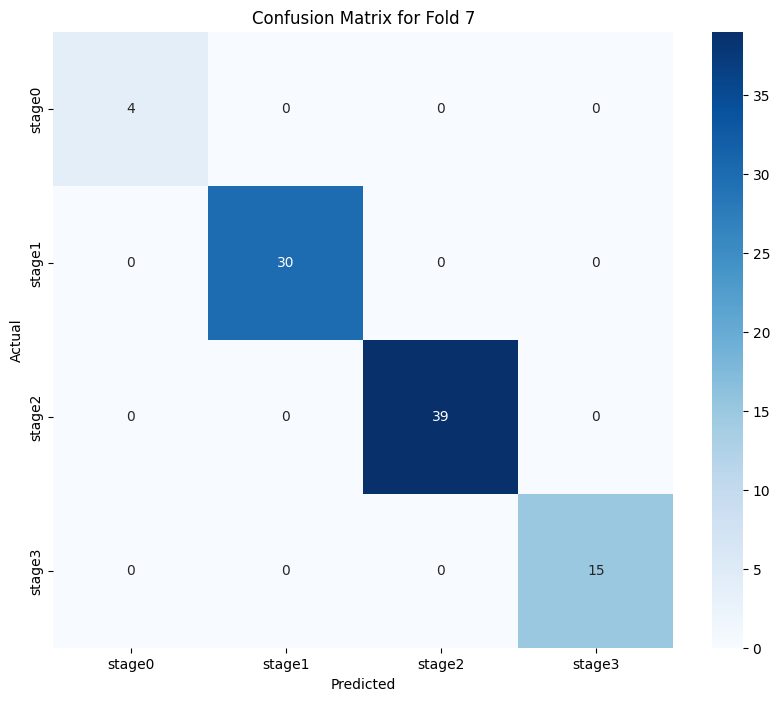

Validation Accuracy for fold 7: 100.0%
Starting epoch 3/10


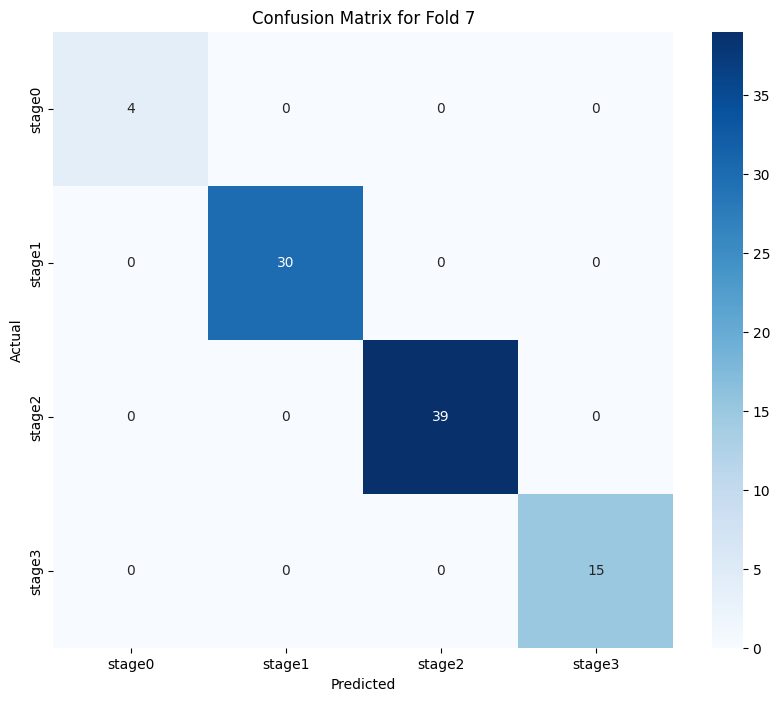

Validation Accuracy for fold 7: 100.0%
Starting epoch 4/10


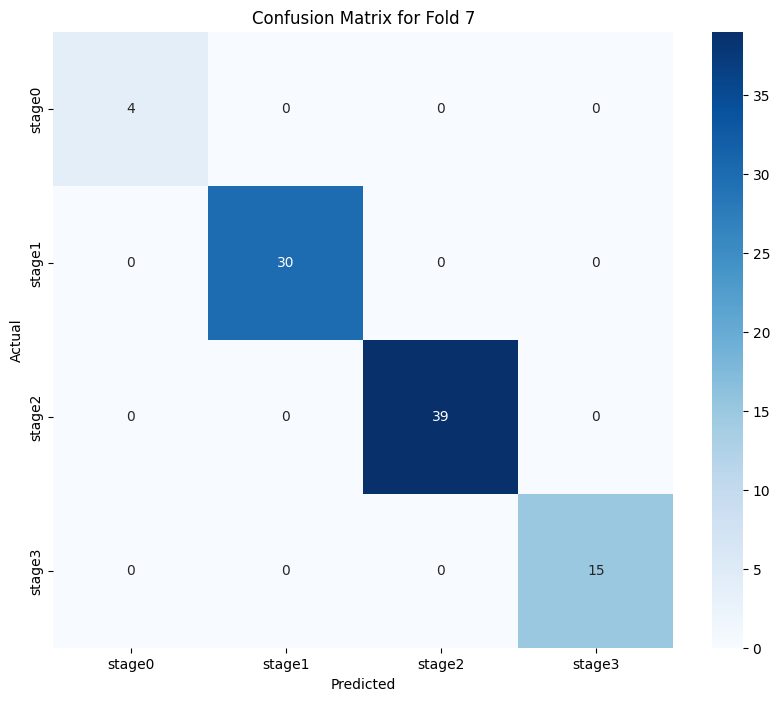

Validation Accuracy for fold 7: 100.0%
Starting epoch 5/10


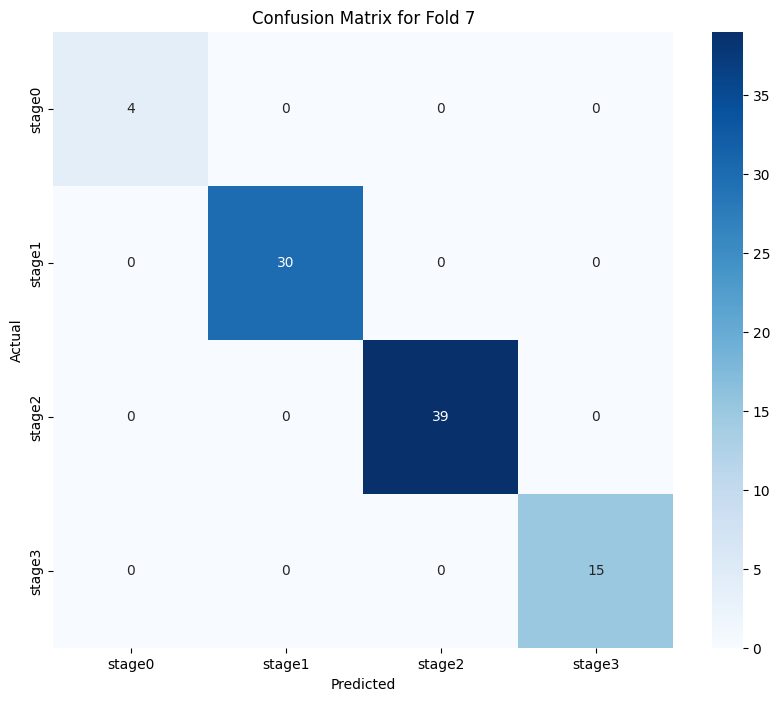

Validation Accuracy for fold 7: 100.0%
Starting epoch 6/10


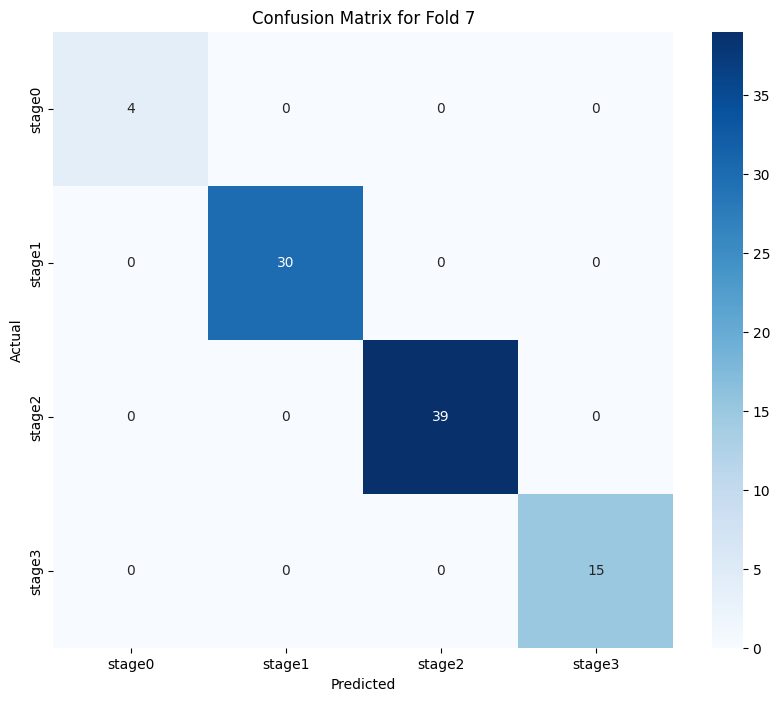

Validation Accuracy for fold 7: 100.0%
Starting epoch 7/10


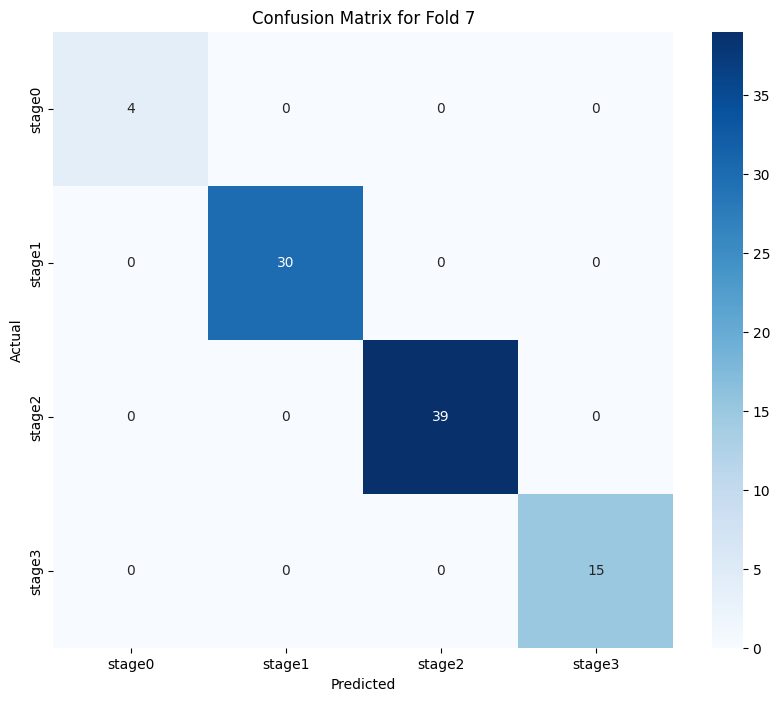

Validation Accuracy for fold 7: 100.0%
Starting epoch 8/10


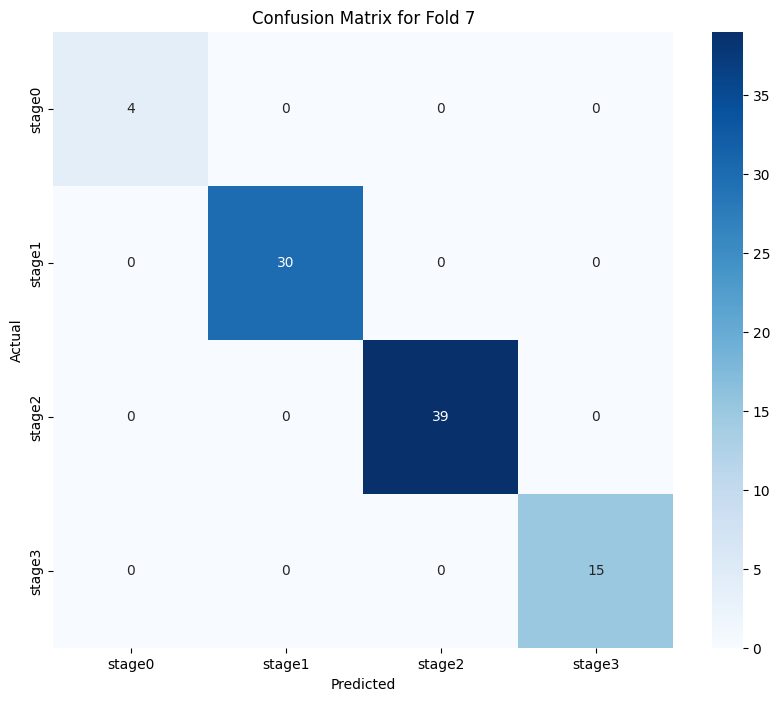

Validation Accuracy for fold 7: 100.0%
Starting epoch 9/10


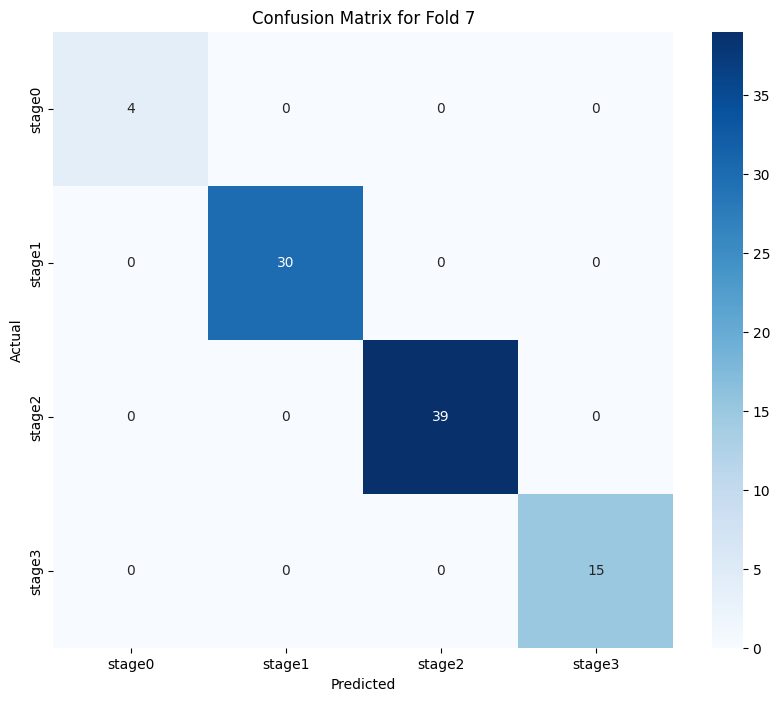

Validation Accuracy for fold 7: 100.0%
Starting epoch 10/10


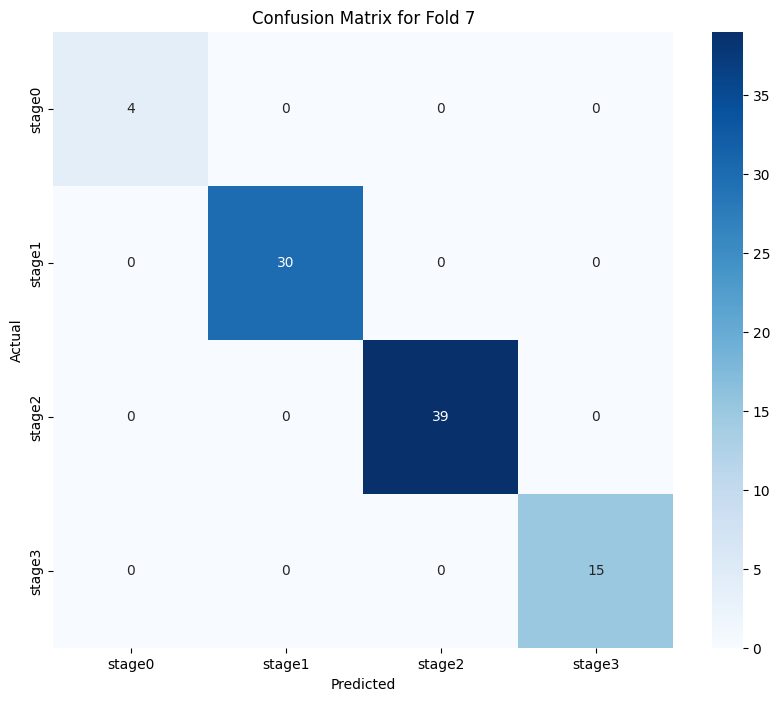

Validation Accuracy for fold 7: 100.0%
--------------------------------
FOLD 8
--------------------------------
Starting epoch 1/10


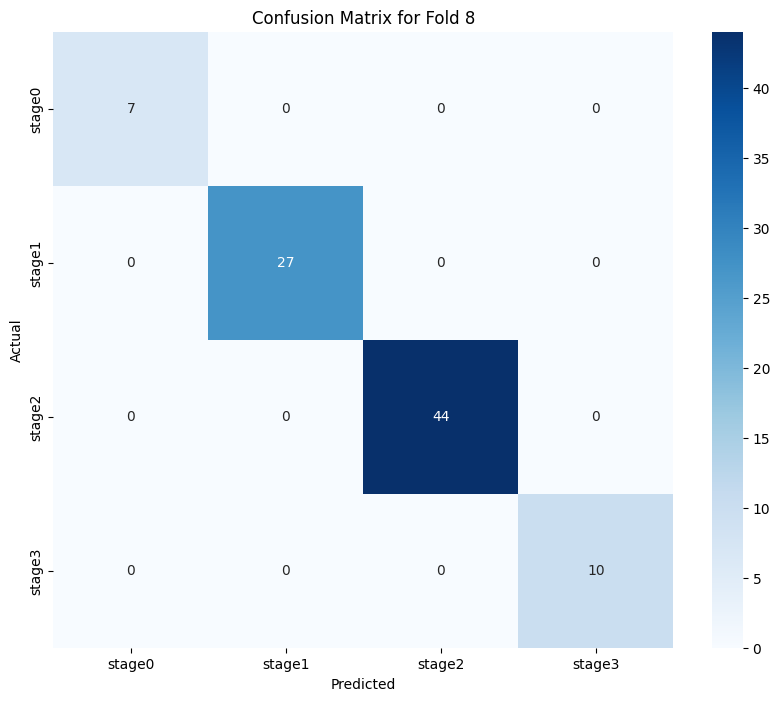

Validation Accuracy for fold 8: 100.0%
Starting epoch 2/10


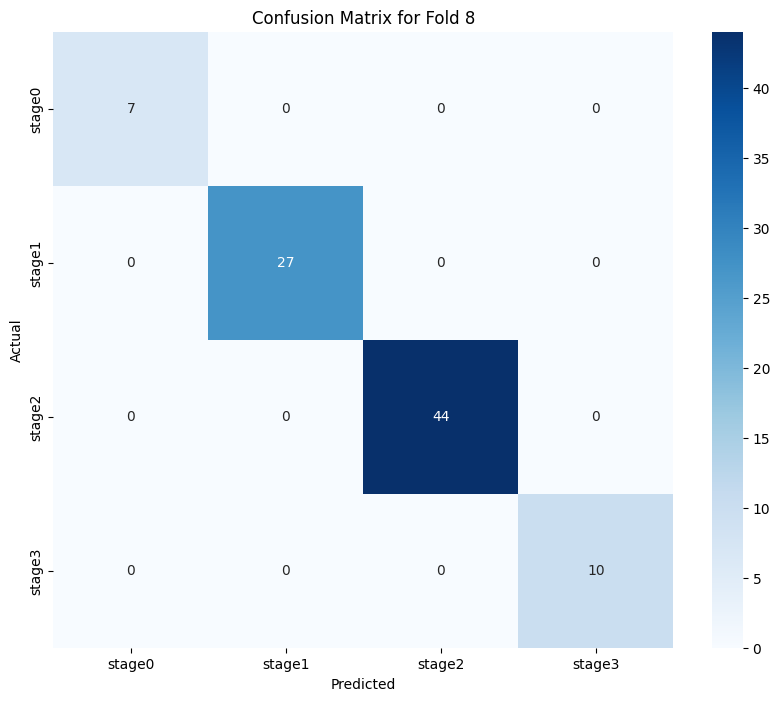

Validation Accuracy for fold 8: 100.0%
Starting epoch 3/10


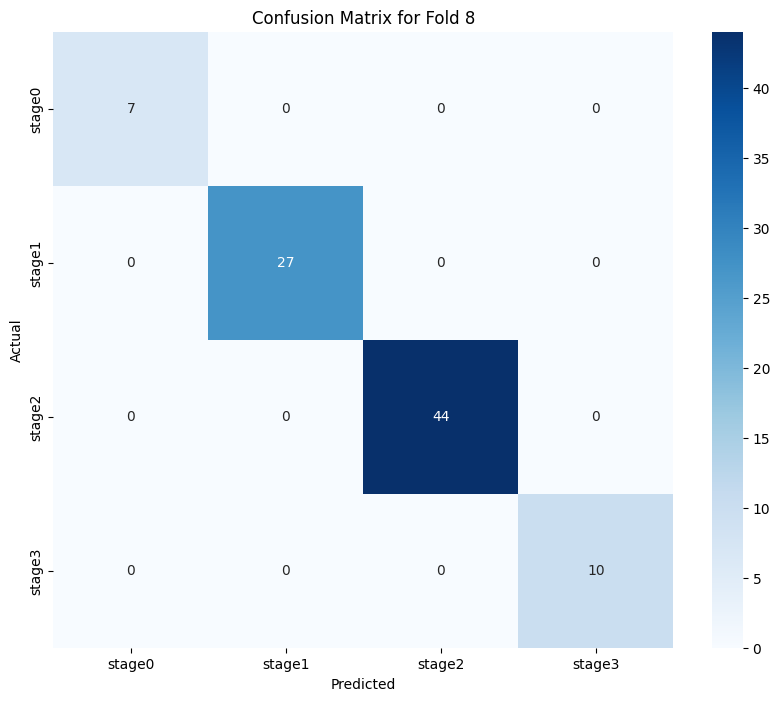

Validation Accuracy for fold 8: 100.0%
Starting epoch 4/10


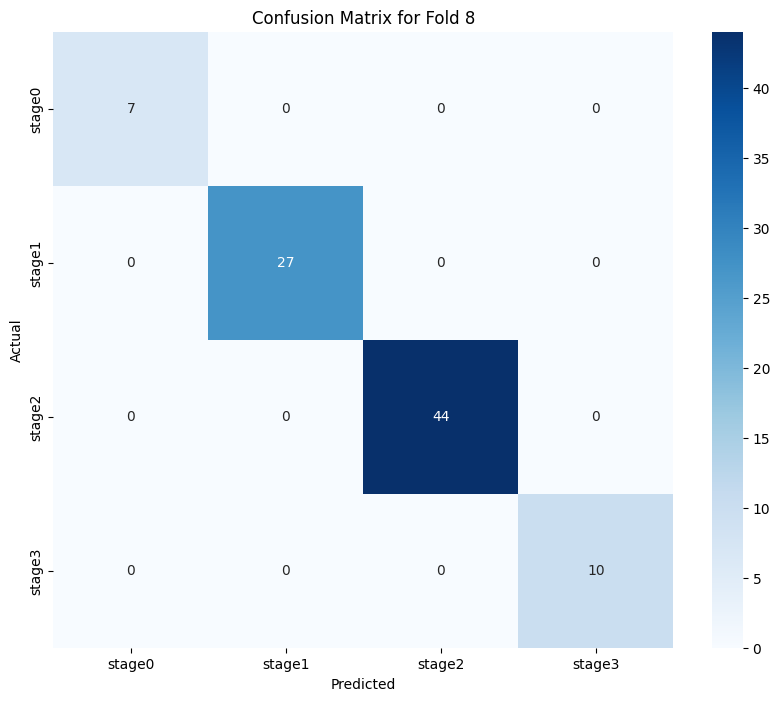

Validation Accuracy for fold 8: 100.0%
Starting epoch 5/10


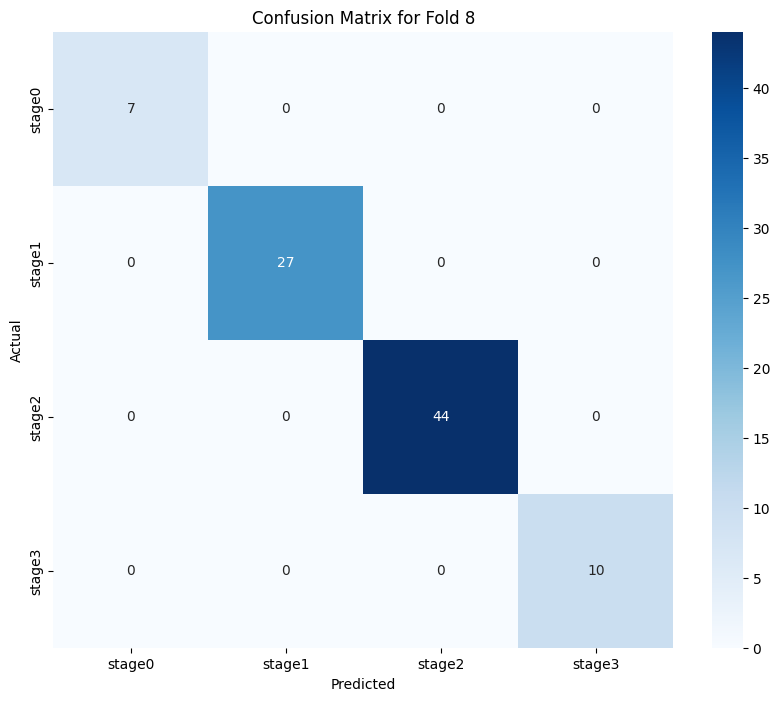

Validation Accuracy for fold 8: 100.0%
Starting epoch 6/10


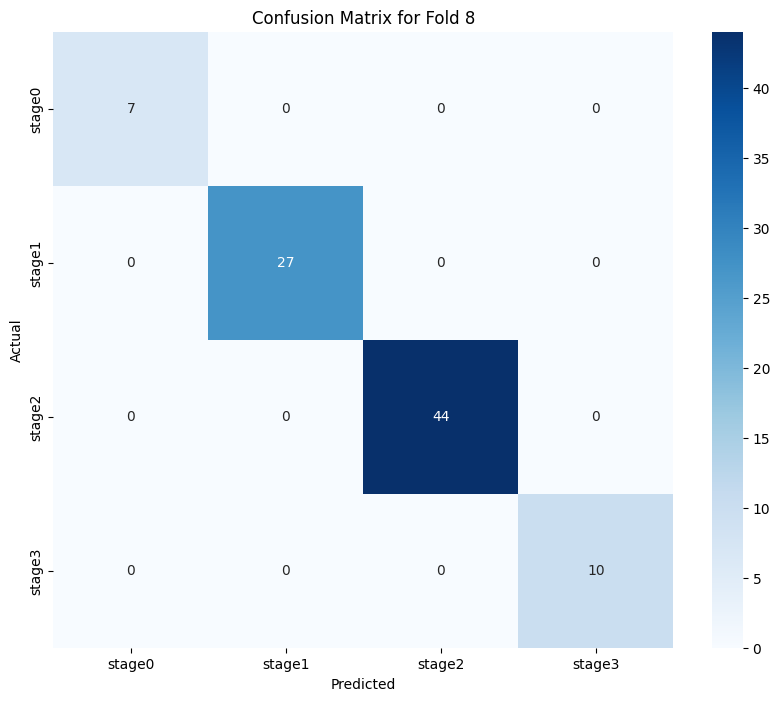

Validation Accuracy for fold 8: 100.0%
Starting epoch 7/10


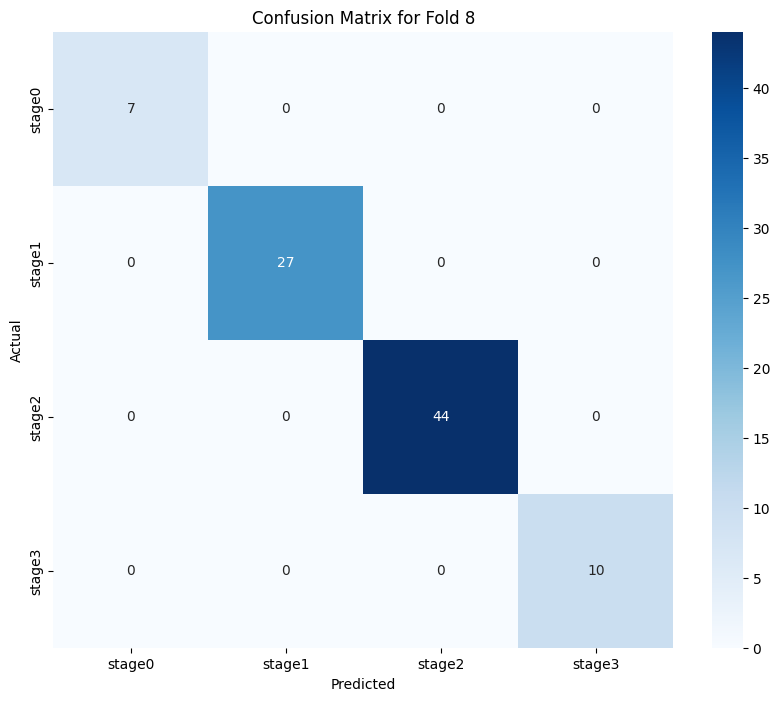

Validation Accuracy for fold 8: 100.0%
Starting epoch 8/10


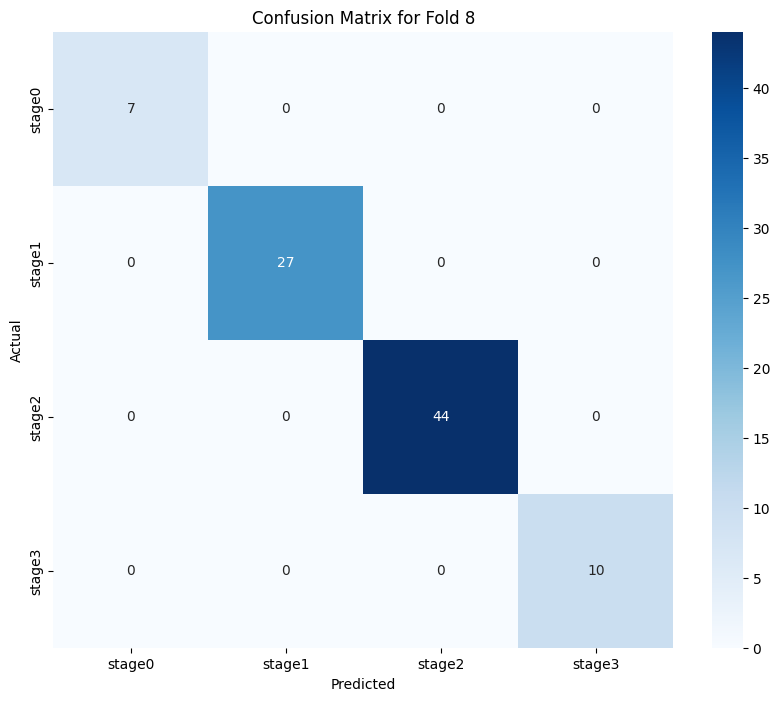

Validation Accuracy for fold 8: 100.0%
Starting epoch 9/10


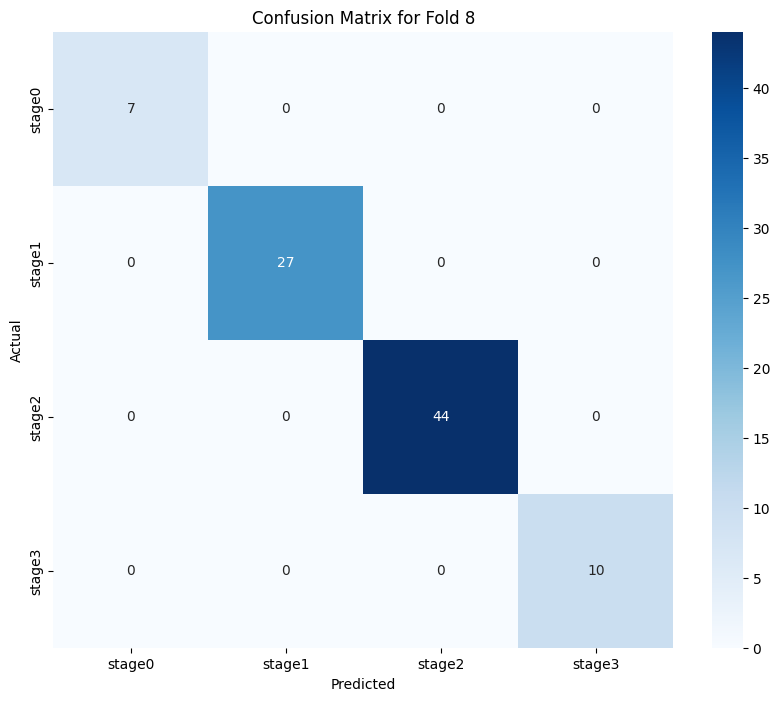

Validation Accuracy for fold 8: 100.0%
Starting epoch 10/10


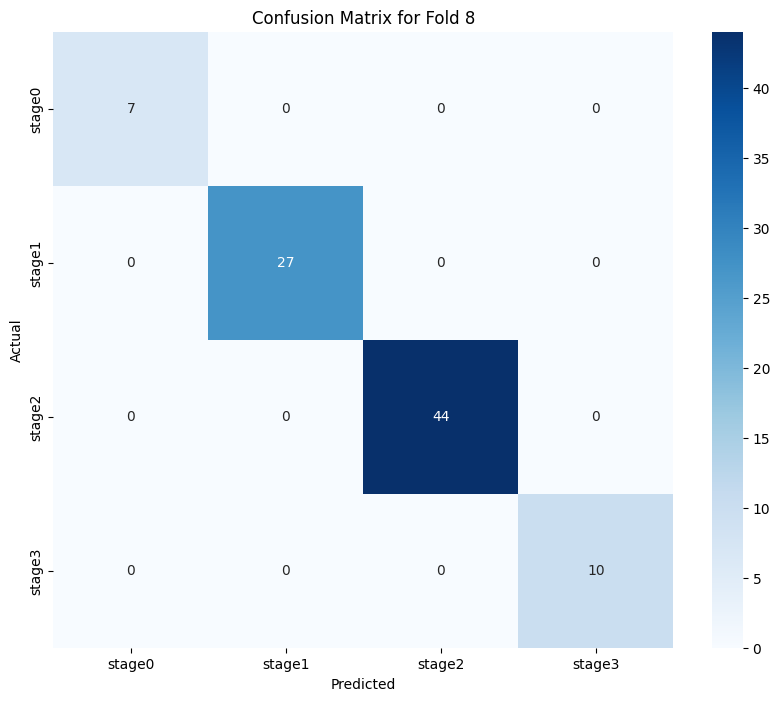

Validation Accuracy for fold 8: 100.0%
--------------------------------
FOLD 9
--------------------------------
Starting epoch 1/10


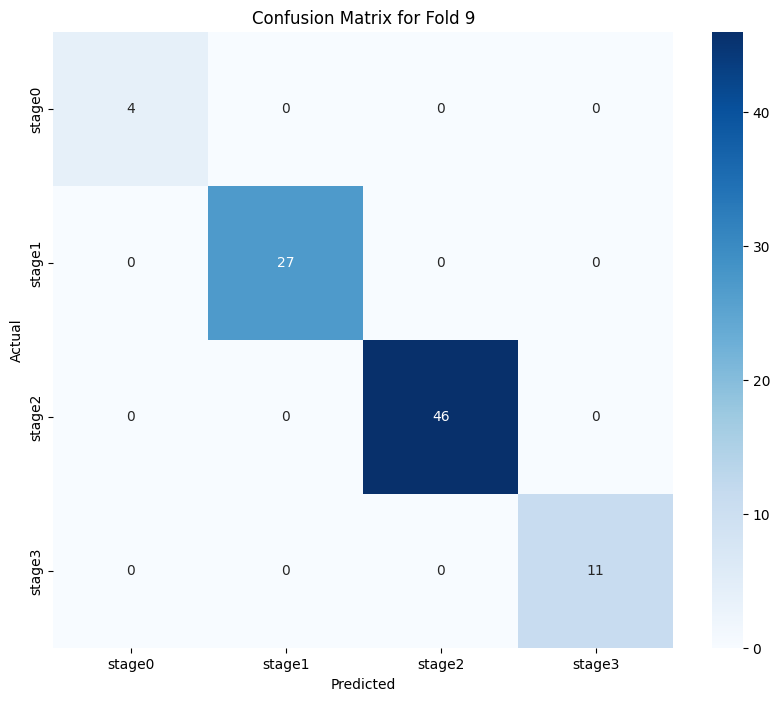

Validation Accuracy for fold 9: 100.0%
Starting epoch 2/10


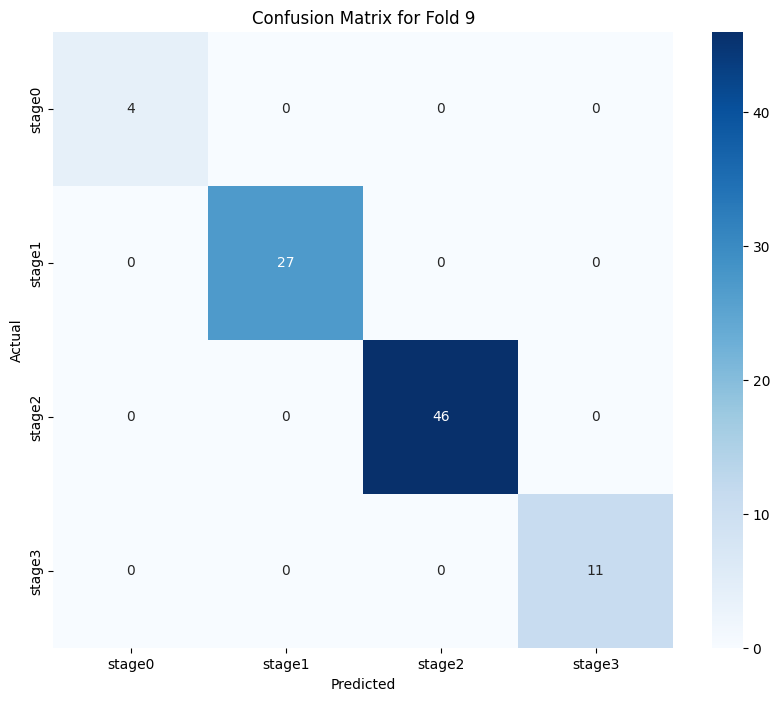

Validation Accuracy for fold 9: 100.0%
Starting epoch 3/10


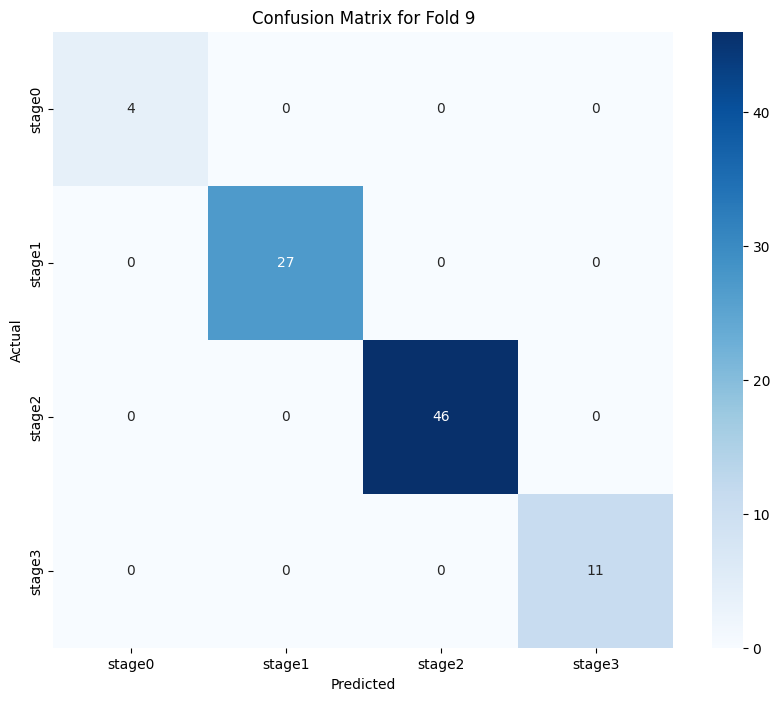

Validation Accuracy for fold 9: 100.0%
Starting epoch 4/10


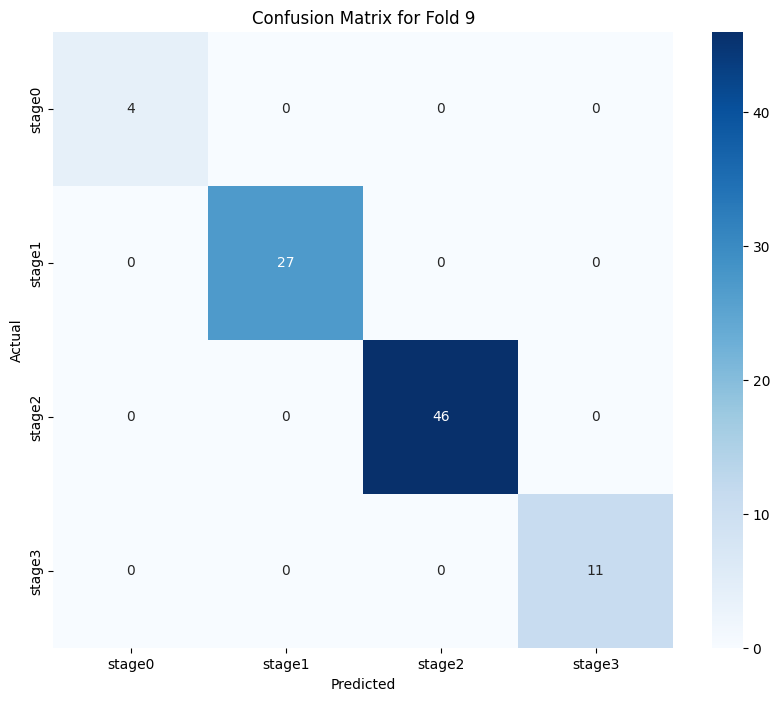

Validation Accuracy for fold 9: 100.0%
Starting epoch 5/10


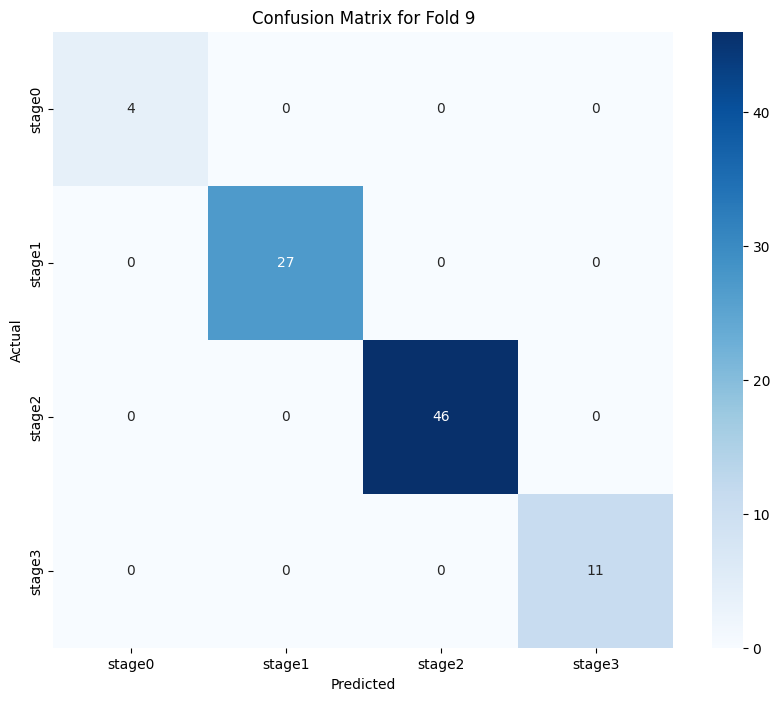

Validation Accuracy for fold 9: 100.0%
Starting epoch 6/10


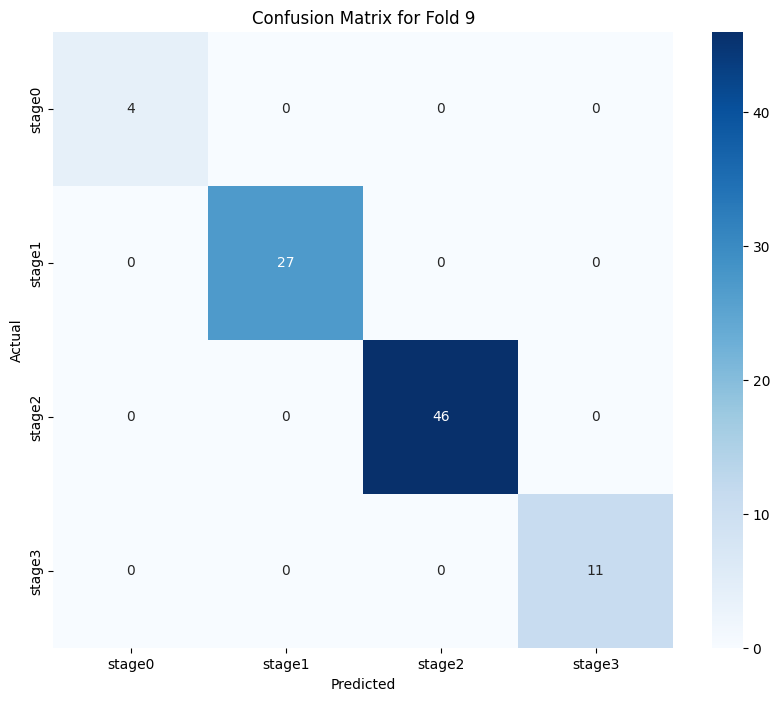

Validation Accuracy for fold 9: 100.0%
Starting epoch 7/10


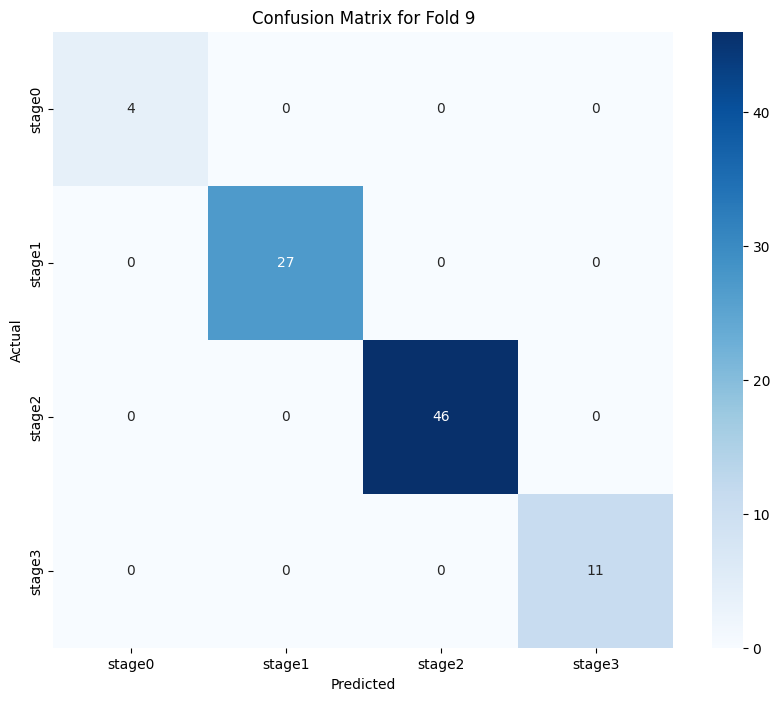

Validation Accuracy for fold 9: 100.0%
Starting epoch 8/10


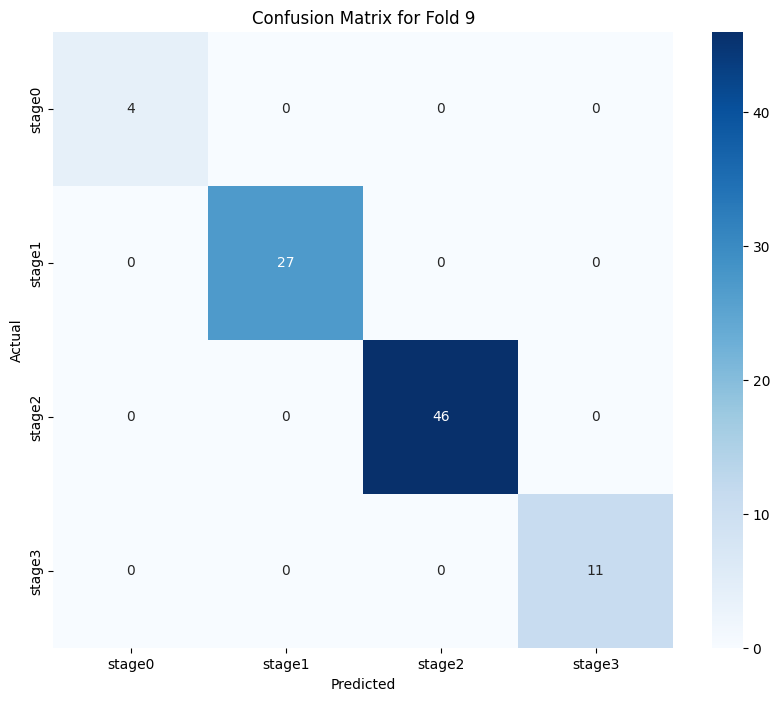

Validation Accuracy for fold 9: 100.0%
Starting epoch 9/10


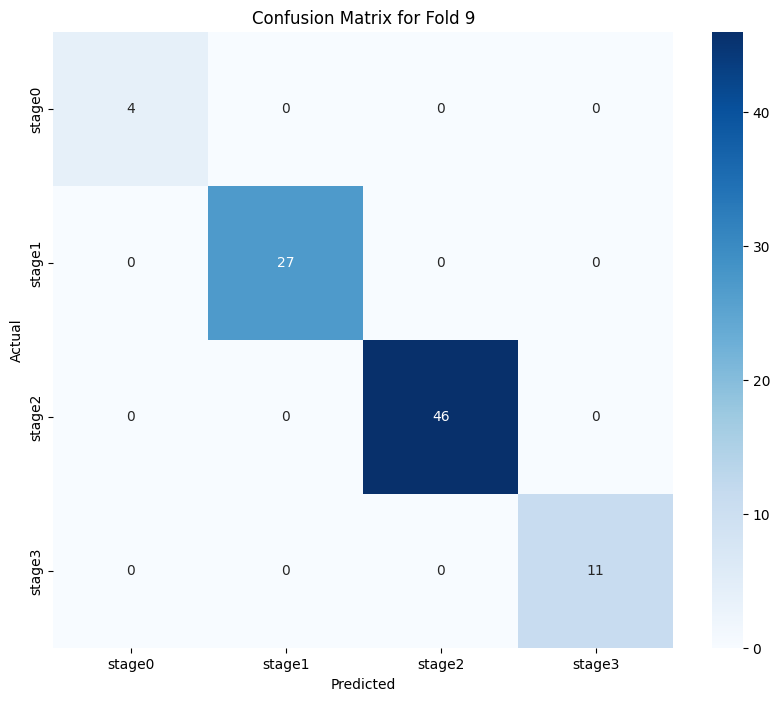

Validation Accuracy for fold 9: 100.0%
Starting epoch 10/10


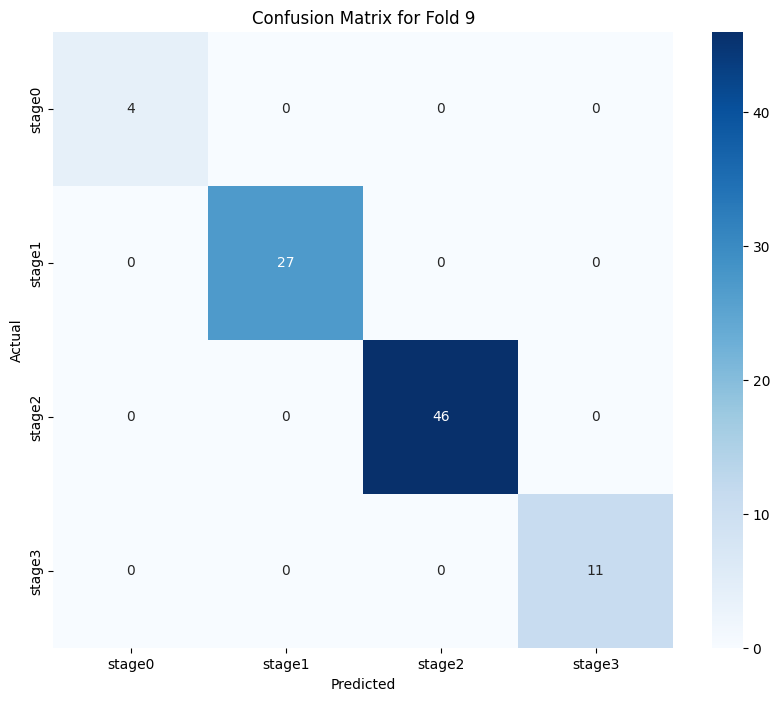

Validation Accuracy for fold 9: 100.0%
--------------------------------


In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check if GPU is available and use it, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the main model and move it to the appropriate device
main_model = model2  # Replace with your actual model
main_model = main_model.to(device)

# Define your loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()  # Replace with your loss function
optimizer = torch.optim.Adam(main_model.parameters())  # Replace with your optimizer

# Class names (ensure these match the class folder names)
class_names = segmented_dataset.classes

# Training and validation process
num_epochs = 10  # Adjust as necessary
for fold, (train_ids, val_ids) in enumerate(kfold.split(segmented_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(segmented_dataset, train_ids)
    val_subsampler = Subset(segmented_dataset, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        main_model.train()
        for inputs, labels in train_loader:
            # Move inputs and labels to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = main_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        main_model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move inputs and labels to the same device as the model
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = main_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Store predictions and true labels for confusion matrix
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Compute and display confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix for Fold {fold}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

        print(f'Validation Accuracy for fold {fold}: {100 * correct / total}%')

    # Optionally save model after each fold
    torch.save(main_model.state_dict(), f'main_model_fold_{fold}.pth')

    print('--------------------------------')

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
!pip install --upgrade --no-cache-dir gdown
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

In [ ]:
!gdown 1sQuB_MUaUfJATF3S3jXxR_OnChyhAS7V

Downloading...
From (original): https://drive.google.com/uc?id=1sQuB_MUaUfJATF3S3jXxR_OnChyhAS7V
From (redirected): https://drive.google.com/uc?id=1sQuB_MUaUfJATF3S3jXxR_OnChyhAS7V&confirm=t&uuid=7c399e86-1e16-42aa-997c-bfba6fbcbdc1
To: /content/dataset_model.zip
100% 409M/409M [00:11<00:00, 36.8MB/s]


In [ ]:
import os
import zipfile
with zipfile.ZipFile("/content/dataset_model.zip", "r") as zip_ref:
  print("Unzipping file...")
  zip_ref.extractall("dataset_model")

Unzipping file...


In [ ]:
import os
import random
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

# Define paths
root_dir = "/content/dataset_model/dataset_model"  # Replace with the path to your dataset
output_dir = "augmented_data"  # Replace with the path where you want to save the augmented dataset

# Augmentation transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(translate=(0.1, 0.1), degrees=0)
])

# Define a function to augment the images
def augment_images(class_dir, target_count):
    images = os.listdir(class_dir)
    num_existing_images = len(images)

    for i in range(target_count - num_existing_images):
        img_name = random.choice(images)
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)

        # Apply augmentation
        augmented_img = augmentation_transforms(img)

        # Save augmented image
        new_img_name = f"aug_{i}_{img_name}"
        augmented_img.save(os.path.join(class_dir, new_img_name))

# Augment each class folder
for class_folder in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_folder)
    if os.path.isdir(class_dir):
        current_count = len(os.listdir(class_dir))
        if current_count < 458:
            augment_images(class_dir, 458)

In [ ]:
original_folder = '/content/dataset_model/dataset_model'  # Path to the folder with the 4 subfolders
new_folder = 'new_dataset'  # Path to the new folder you want to create

# Step 1: Create the new folder structure
if not os.path.exists(new_folder):
    os.makedirs(new_folder)

# Copy the subfolder structure
subfolders = [f.path for f in os.scandir(original_folder) if f.is_dir()]
for subfolder in subfolders:
    new_subfolder = os.path.join(new_folder, os.path.basename(subfolder))
    os.makedirs(new_subfolder, exist_ok=True)

# Step 2: Process images and save them in the new folder
for subfolder in subfolders:
    new_subfolder = os.path.join(new_folder, os.path.basename(subfolder))
    for filename in os.listdir(subfolder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Modify as needed
            original_image_path = os.path.join(subfolder, filename)
            print(f"Processing image: {original_image_path}")  # Debug message

            try:
                output_image = predict_mask(original_image_path , model = model , device = device)
                output_image = Image.fromarray(output_image)
                if output_image is not None:
                    output_image_path = os.path.join(new_subfolder, filename)
                    output_image.save(output_image_path)
                    print(f"Saved processed image to: {output_image_path}")  # Debug message
                else:
                    print(f"Failed to process image: {original_image_path}")  # Debug message
            except Exception as e:
                print(f"Error saving image {original_image_path}: {e}")  # Debug message

print("Processing completed successfully!")

Processing image: /content/dataset_model/dataset_model/stage1/157_F_GA29_BW480_PA38_DG2_PF0_D3_S02_7.jpg
Saved processed image to: new_dataset/stage1/157_F_GA29_BW480_PA38_DG2_PF0_D3_S02_7.jpg
Processing image: /content/dataset_model/dataset_model/stage1/031_M_GA25_BW910_PA32_DG2_PF0_D1_S01_16.jpg
Saved processed image to: new_dataset/stage1/031_M_GA25_BW910_PA32_DG2_PF0_D1_S01_16.jpg
Processing image: /content/dataset_model/dataset_model/stage1/aug_28_052_M_GA26_BW820_PA32_DG2_PF0_D1_S02_2.jpg
Saved processed image to: new_dataset/stage1/aug_28_052_M_GA26_BW820_PA32_DG2_PF0_D1_S02_2.jpg
Processing image: /content/dataset_model/dataset_model/stage1/052_M_GA26_BW820_PA46_DG2_PF0_D1_S07_2.jpg
Saved processed image to: new_dataset/stage1/052_M_GA26_BW820_PA46_DG2_PF0_D1_S07_2.jpg
Processing image: /content/dataset_model/dataset_model/stage1/084_M_GA27_BW990_PA34_DG2_PF0_D2_S03_1.jpg
Saved processed image to: new_dataset/stage1/084_M_GA27_BW990_PA34_DG2_PF0_D2_S03_1.jpg
Processing image: /

In [ ]:
segmented_dataset = ImageFolder(root='/content/new_dataset', transform=simple_transform)

# Define k-fold cross-validation parameters
k_folds = 10
batch_size = 32  # Adjust based on your resources

# Prepare the k-fold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start the K-Fold Cross-Validation process
for fold, (train_ids, val_ids) in enumerate(kfold.split(segmented_dataset)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(segmented_dataset, train_ids)
    val_subsampler = Subset(segmented_dataset, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize the main model, loss function, and optimizer
    main_model = model2  # Replace with your main model
    criterion = torch.nn.CrossEntropyLoss()  # Replace with your loss function
    optimizer = torch.optim.Adam(main_model.parameters())  # Replace with your optimizer

    # Training and validation process
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        main_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = main_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        main_model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = main_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy for fold {fold}: {100 * correct / total}%')

    # Optionally save model after each fold
    torch.save(main_model.state_dict(), f'main_model_fold_{fold}.pth')

    print('--------------------------------')

FOLD 0
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 0: 65.76086956521739%
Starting epoch 2/10
Validation Accuracy for fold 0: 86.41304347826087%
Starting epoch 3/10
Validation Accuracy for fold 0: 83.69565217391305%
Starting epoch 4/10
Validation Accuracy for fold 0: 85.32608695652173%
Starting epoch 5/10
Validation Accuracy for fold 0: 83.15217391304348%
Starting epoch 6/10
Validation Accuracy for fold 0: 86.41304347826087%
Starting epoch 7/10
Validation Accuracy for fold 0: 84.78260869565217%
Starting epoch 8/10
Validation Accuracy for fold 0: 83.15217391304348%
Starting epoch 9/10
Validation Accuracy for fold 0: 80.97826086956522%
Starting epoch 10/10
Validation Accuracy for fold 0: 83.69565217391305%
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 1: 99.45652173913044%
Starting epoch 2/10
Validation Accuracy for fold 1: 99.45652173913044%
Starting epoch 3/10
Validation Acc

In [ ]:
segmented_dataset = ImageFolder(root='/content/new_dataset', transform=simple_transform)

# Define k-fold cross-validation parameters
k_folds = 4
batch_size = 32  # Adjust based on your resources

# Prepare the k-fold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start the K-Fold Cross-Validation process
for fold, (train_ids, val_ids) in enumerate(kfold.split(segmented_dataset)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(segmented_dataset, train_ids)
    val_subsampler = Subset(segmented_dataset, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize the main model, loss function, and optimizer
    main_model = model2  # Replace with your main model
    criterion = torch.nn.CrossEntropyLoss()  # Replace with your loss function
    optimizer = torch.optim.Adam(main_model.parameters())  # Replace with your optimizer

    # Training and validation process
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        main_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = main_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        main_model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = main_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy for fold {fold}: {100 * correct / total}%')

    # Optionally save model after each fold
    torch.save(main_model.state_dict(), f'main_model_2_fold_{fold}.pth')

    print('--------------------------------')

FOLD 0
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 0: 47.161572052401745%
Starting epoch 2/10
Validation Accuracy for fold 0: 79.03930131004367%
Starting epoch 3/10
Validation Accuracy for fold 0: 76.41921397379913%
Starting epoch 4/10
Validation Accuracy for fold 0: 81.22270742358079%
Starting epoch 5/10
Validation Accuracy for fold 0: 80.13100436681222%
Starting epoch 6/10
Validation Accuracy for fold 0: 74.89082969432314%
Starting epoch 7/10
Validation Accuracy for fold 0: 80.78602620087337%
Starting epoch 8/10
Validation Accuracy for fold 0: 81.22270742358079%
Starting epoch 9/10
Validation Accuracy for fold 0: 81.22270742358079%
Starting epoch 10/10
Validation Accuracy for fold 0: 83.84279475982532%
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 1: 99.34497816593887%
Starting epoch 2/10
Validation Accuracy for fold 1: 98.2532751091703%
Starting epoch 3/10
Validation Acc

In [ ]:
import torchvision
weights2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT

In [ ]:
model3 = torchvision.models.efficientnet_b2(weights=weights2).to(device)
total_layers_model2 = sum(1 for _ in model3.parameters())
percent_freeze_model2 = 0.7
num_layers_freeze_model2 = int(percent_freeze_model2*total_layers_model2)
frozen_layers_model2 = 0
for name , param in model3.named_parameters():
  if "classifier" not in name:
    if frozen_layers_model2 < num_layers_freeze_model2:
      param.requires_grad = False
      frozen_layers_model2 += 1
    else:
      break

model_33 = torchvision.models.efficientnet_b2(weights=weights2).to(device)


In [ ]:
model4 = torchvision.models.efficientnet_b2(weights=weights2).to(device)
total_layers_model2 = sum(1 for _ in model4.parameters())
percent_freeze_model2 = 0.7
num_layers_freeze_model2 = int(percent_freeze_model2*total_layers_model2)
frozen_layers_model2 = 0
for name , param in model4.named_parameters():
  if "classifier" not in name:
    if frozen_layers_model2 < num_layers_freeze_model2:
      param.requires_grad = False
      frozen_layers_model2 += 1
    else:
      break

model_44 = torchvision.models.efficientnet_b2(weights=weights2).to(device)

In [ ]:
model5 = torchvision.models.efficientnet_b2(weights=weights2).to(device)
total_layers_model2 = sum(1 for _ in model5.parameters())
percent_freeze_model2 = 0.7
num_layers_freeze_model2 = int(percent_freeze_model2*total_layers_model2)
frozen_layers_model2 = 0
for name , param in model5.named_parameters():
  if "classifier" not in name:
    if frozen_layers_model2 < num_layers_freeze_model2:
      param.requires_grad = False
      frozen_layers_model2 += 1
    else:
      break

model_55 = torchvision.models.efficientnet_b2(weights=weights2).to(device)

In [ ]:
model6 = torchvision.models.efficientnet_b2(weights=weights2).to(device)
total_layers_model2 = sum(1 for _ in model6.parameters())
percent_freeze_model2 = 0.7
num_layers_freeze_model2 = int(percent_freeze_model2*total_layers_model2)
frozen_layers_model2 = 0
for name , param in model6.named_parameters():
  if "classifier" not in name:
    if frozen_layers_model2 < num_layers_freeze_model2:
      param.requires_grad = False
      frozen_layers_model2 += 1
    else:
      break

model_66 = torchvision.models.efficientnet_b2(weights=weights2).to(device)
model_77 = torchvision.models.efficientnet_b2(weights=weights2).to(device)
model_88 = torchvision.models.efficientnet_b2(weights=weights2).to(device)
model_99 = torchvision.models.efficientnet_b2(weights=weights2).to(device)
model_00 = torchvision.models.efficientnet_b2(weights=weights2).to(device)
model_11 = torchvision.models.efficientnet_b2(weights=weights2).to(device)
model_22 = torchvision.models.efficientnet_b2(weights=weights2).to(device)

In [ ]:
weights_reg = torchvision.models.RegNet_Y_400MF_Weights.DEFAULT
model11 = torchvision.models.regnet_y_400mf(weights=weights_reg).to(device)
model22 = torchvision.models.regnet_y_400mf(weights=weights_reg).to(device)
model33 = torchvision.models.regnet_y_400mf(weights=weights_reg).to(device)
model44 = torchvision.models.regnet_y_400mf(weights=weights_reg).to(device)
model55 = torchvision.models.regnet_y_400mf(weights=weights_reg).to(device)
model66 = torchvision.models.regnet_y_400mf(weights=weights_reg).to(device)
model77 = torchvision.models.regnet_y_400mf(weights=weights_reg).to(device)
model88 = torchvision.models.regnet_y_400mf(weights=weights_reg).to(device)
model99 = torchvision.models.regnet_y_400mf(weights=weights_reg).to(device)
model00 = torchvision.models.regnet_y_400mf(weights=weights_reg).to(device)


In [ ]:
weights_reg32 = torchvision.models.RegNet_Y_32GF_Weights.DEFAULT
model_111 = torchvision.models.regnet_y_32gf(weights=weights_reg32).to(device)
model_222 = torchvision.models.regnet_y_32gf(weights=weights_reg32).to(device)
model_333 = torchvision.models.regnet_y_32gf(weights=weights_reg32).to(device)
model_444 = torchvision.models.regnet_y_32gf(weights=weights_reg32).to(device)
model_555 = torchvision.models.regnet_y_32gf(weights=weights_reg32).to(device)
model_666 = torchvision.models.regnet_y_32gf(weights=weights_reg32).to(device)
model_777 = torchvision.models.regnet_y_32gf(weights=weights_reg32).to(device)
model_888 = torchvision.models.regnet_y_32gf(weights=weights_reg32).to(device)
model_999 = torchvision.models.regnet_y_32gf(weights=weights_reg32).to(device)
model_000 = torchvision.models.regnet_y_32gf(weights=weights_reg32).to(device)

Downloading: "https://download.pytorch.org/models/regnet_y_32gf-8db6d4b5.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_32gf-8db6d4b5.pth
100%|██████████| 554M/554M [00:59<00:00, 9.83MB/s]


In [ ]:
model_list2 = [model11 , model22 , model33 , model44]

model_list3 = [model11 , model22 , model33 , model44 , model55 , model66 , model77 , model88 , model99 , model00]
model_list4 = [model_11 , model_22 , model_33 , model_44 , model_55 , model_66 , model_77 , model_88 , model_99 , model_00]

In [ ]:
model_list = [model3 , model4 , model5 , model6]
model_list1 = [model_3 , model_4 , model_5 , model_6]
model_list_11 = [model_00 , model_11 , model_22 , model_33 , model_44 , model_55 , model_66 , model_77 , model_88 , model_99]

In [ ]:
model_list[1]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
import torch.utils.checkpoint as checkpoint
import torchvision
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights_regnet = torchvision.models.RegNet_Y_32GF_Weights.DEFAULT
model_regnet = torchvision.models.regnet_y_32gf(weights=weights_regnet).to(device)
class CheckpointedRegNet(nn.Module):
    def __init__(self, model):
        super(CheckpointedRegNet, self).__init__()
        self.model = model
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x.requires_grad_()
        # Apply gradient checkpointing on blocks that are memory intensive
        x = checkpoint.checkpoint(self.model.stem, x)
        for block in self.model.trunk_output.children():
            x = checkpoint.checkpoint(block, x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = checkpoint.checkpoint(self.model.fc, x)
        return x
    def __getattr__(self, name):
        """
        This function ensures that if an attribute is not found in the
        CheckpointedRegNet instance itself, it is looked up in the wrapped model (self.model).
        """
        try:
          return super().__getattr__(name)
        except AttributeError:
          return getattr(self.model, name)

# Replace the original model with the checkpointed version
model_regnet0 = CheckpointedRegNet(model_regnet)
model_regnet1 = CheckpointedRegNet(model_regnet)
model_regnet2 = CheckpointedRegNet(model_regnet)
model_regnet3 = CheckpointedRegNet(model_regnet)
model_regnet4 = CheckpointedRegNet(model_regnet)
model_regnet5 = CheckpointedRegNet(model_regnet)
model_regnet6 = CheckpointedRegNet(model_regnet)
model_regnet7 = CheckpointedRegNet(model_regnet)
model_regnet8 = CheckpointedRegNet(model_regnet)
model_regnet9 = CheckpointedRegNet(model_regnet)



In [ ]:
regnet_list = [model_regnet0 , model_regnet1 , model_regnet2 , model_regnet3 , model_regnet4 , model_regnet5 , model_regnet6 , model_regnet7 , model_regnet8 , model_regnet9]

In [ ]:
segmented_dataset = ImageFolder(root='/content/new_dataset', transform=simple_transform)

# Define k-fold cross-validation parameters
k_folds = 4
batch_size = 32  # Adjust based on your resources

# Prepare the k-fold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start the K-Fold Cross-Validation process
for fold, (train_ids, val_ids) in enumerate(kfold.split(segmented_dataset)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(segmented_dataset, train_ids)
    val_subsampler = Subset(segmented_dataset, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize the main model, loss function, and optimizer
    main_model = model_list[fold]  # Replace with your main model
    criterion = torch.nn.CrossEntropyLoss()  # Replace with your loss function
    optimizer = torch.optim.Adam(main_model.parameters())  # Replace with your optimizer

    # Training and validation process
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        main_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = main_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        main_model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = main_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy for fold {fold}: {100 * correct / total}%')

    # Optionally save model after each fold
    torch.save(main_model.state_dict(), f'main_model_2_fold_{fold}.pth')

    print('--------------------------------')

FOLD 0
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 0: 46.943231441048034%
Starting epoch 2/10
Validation Accuracy for fold 0: 75.9825327510917%
Starting epoch 3/10
Validation Accuracy for fold 0: 78.16593886462883%
Starting epoch 4/10
Validation Accuracy for fold 0: 74.67248908296943%
Starting epoch 5/10
Validation Accuracy for fold 0: 79.6943231441048%
Starting epoch 6/10
Validation Accuracy for fold 0: 78.82096069868996%
Starting epoch 7/10
Validation Accuracy for fold 0: 80.13100436681222%
Starting epoch 8/10
Validation Accuracy for fold 0: 80.56768558951966%
Starting epoch 9/10
Validation Accuracy for fold 0: 79.25764192139738%
Starting epoch 10/10
Validation Accuracy for fold 0: 80.13100436681222%
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 1: 63.97379912663755%
Starting epoch 2/10
Validation Accuracy for fold 1: 77.9475982532751%
Starting epoch 3/10
Validation Accur

In [ ]:
segmented_dataset = ImageFolder(root='/content/new_dataset', transform=simple_transform)

# Define k-fold cross-validation parameters
k_folds = 4
batch_size = 32  # Adjust based on your resources

# Prepare the k-fold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start the K-Fold Cross-Validation process
for fold, (train_ids, val_ids) in enumerate(kfold.split(segmented_dataset)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(segmented_dataset, train_ids)
    val_subsampler = Subset(segmented_dataset, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize the main model, loss function, and optimizer
    main_model = model_list2[fold]  # Replace with your main model
    criterion = torch.nn.CrossEntropyLoss()  # Replace with your loss function
    optimizer = torch.optim.Adam(main_model.parameters())  # Replace with your optimizer

    # Training and validation process
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        main_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = main_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        main_model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = main_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy for fold {fold}: {100 * correct / total}%')

    # Optionally save model after each fold
    torch.save(main_model.state_dict(), f'main_model_2_fold_{fold}.pth')

    print('--------------------------------')

FOLD 0
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 0: 46.943231441048034%
Starting epoch 2/10
Validation Accuracy for fold 0: 71.61572052401746%
Starting epoch 3/10
Validation Accuracy for fold 0: 59.60698689956332%
Starting epoch 4/10
Validation Accuracy for fold 0: 58.951965065502186%
Starting epoch 5/10
Validation Accuracy for fold 0: 73.36244541484716%
Starting epoch 6/10
Validation Accuracy for fold 0: 61.572052401746724%
Starting epoch 7/10
Validation Accuracy for fold 0: 75.10917030567686%
Starting epoch 8/10
Validation Accuracy for fold 0: 75.54585152838428%
Starting epoch 9/10
Validation Accuracy for fold 0: 74.67248908296943%
Starting epoch 10/10
Validation Accuracy for fold 0: 79.25764192139738%
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 1: 51.96506550218341%
Starting epoch 2/10
Validation Accuracy for fold 1: 69.86899563318778%
Starting epoch 3/10
Validation 

In [ ]:
segmented_dataset = ImageFolder(root='/content/new_dataset', transform=simple_transform)

# Define k-fold cross-validation parameters
k_folds = 10
batch_size = 32  # Adjust based on your resources

# Prepare the k-fold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start the K-Fold Cross-Validation process
for fold, (train_ids, val_ids) in enumerate(kfold.split(segmented_dataset)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(segmented_dataset, train_ids)
    val_subsampler = Subset(segmented_dataset, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize the main model, loss function, and optimizer
    main_model = model_list3[fold]  # Replace with your main model
    criterion = torch.nn.CrossEntropyLoss()  # Replace with your loss function
    optimizer = torch.optim.Adam(main_model.parameters())  # Replace with your optimizer

    # Training and validation process
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        main_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = main_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        main_model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = main_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy for fold {fold}: {100 * correct / total}%')

    # Optionally save model after each fold
    torch.save(main_model.state_dict(), f'main_model_2_fold_{fold}.pth')

    print('--------------------------------')

FOLD 0
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 0: 54.891304347826086%
Starting epoch 2/10
Validation Accuracy for fold 0: 72.82608695652173%
Starting epoch 3/10
Validation Accuracy for fold 0: 66.84782608695652%
Starting epoch 4/10
Validation Accuracy for fold 0: 71.19565217391305%
Starting epoch 5/10
Validation Accuracy for fold 0: 77.17391304347827%
Starting epoch 6/10
Validation Accuracy for fold 0: 61.95652173913044%
Starting epoch 7/10
Validation Accuracy for fold 0: 72.82608695652173%
Starting epoch 8/10
Validation Accuracy for fold 0: 71.73913043478261%
Starting epoch 9/10
Validation Accuracy for fold 0: 55.43478260869565%
Starting epoch 10/10
Validation Accuracy for fold 0: 78.26086956521739%
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 1: 71.19565217391305%
Starting epoch 2/10
Validation Accuracy for fold 1: 71.19565217391305%
Starting epoch 3/10
Validation Ac

In [ ]:
segmented_dataset = ImageFolder(root='/content/new_dataset', transform=simple_transform)

# Define k-fold cross-validation parameters
k_folds = 10
batch_size = 32  # Adjust based on your resources

# Prepare the k-fold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start the K-Fold Cross-Validation process
for fold, (train_ids, val_ids) in enumerate(kfold.split(segmented_dataset)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(segmented_dataset, train_ids)
    val_subsampler = Subset(segmented_dataset, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize the main model, loss function, and optimizer
    main_model = model_list4[fold]  # Replace with your main model
    criterion = torch.nn.CrossEntropyLoss()  # Replace with your loss function
    optimizer = torch.optim.Adam(main_model.parameters())  # Replace with your optimizer

    # Training and validation process
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        main_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = main_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        main_model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = main_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy for fold {fold}: {100 * correct / total}%')

    # Optionally save model after each fold
    torch.save(main_model.state_dict(), f'main_model_2_fold_{fold}.pth')

    print('--------------------------------')

FOLD 0
--------------------------------
Starting epoch 1/10


OutOfMemoryError: CUDA out of memory. Tried to allocate 90.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 73.06 MiB is free. Process 4908 has 14.67 GiB memory in use. Of the allocated memory 14.02 GiB is allocated by PyTorch, and 526.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
segmented_dataset = ImageFolder(root='/content/new_dataset', transform=simple_transform)

# Define k-fold cross-validation parameters
k_folds = 4
batch_size = 32  # Adjust based on your resources

# Prepare the k-fold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start the K-Fold Cross-Validation process
for fold, (train_ids, val_ids) in enumerate(kfold.split(segmented_dataset)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(segmented_dataset, train_ids)
    val_subsampler = Subset(segmented_dataset, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize the main model, loss function, and optimizer
    main_model = model_list1[fold]  # Replace with your main model
    criterion = torch.nn.CrossEntropyLoss()  # Replace with your loss function
    optimizer = torch.optim.Adam(main_model.parameters())  # Replace with your optimizer

    # Training and validation process
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        main_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = main_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        main_model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = main_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy for fold {fold}: {100 * correct / total}%')

    # Optionally save model after each fold
    torch.save(main_model.state_dict(), f'main_model_2_fold_{fold}.pth')

    print('--------------------------------')

FOLD 0
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 0: 90.82969432314411%
Starting epoch 2/10
Validation Accuracy for fold 0: 95.41484716157206%
Starting epoch 3/10
Validation Accuracy for fold 0: 93.23144104803494%
Starting epoch 4/10
Validation Accuracy for fold 0: 96.06986899563319%
Starting epoch 5/10
Validation Accuracy for fold 0: 96.06986899563319%
Starting epoch 6/10
Validation Accuracy for fold 0: 94.32314410480349%
Starting epoch 7/10
Validation Accuracy for fold 0: 88.42794759825327%
Starting epoch 8/10
Validation Accuracy for fold 0: 93.66812227074236%
Starting epoch 9/10
Validation Accuracy for fold 0: 93.88646288209607%
Starting epoch 10/10
Validation Accuracy for fold 0: 89.08296943231441%
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 1: 85.1528384279476%
Starting epoch 2/10
Validation Accuracy for fold 1: 94.10480349344978%
Starting epoch 3/10
Validation Accu

In [ ]:
segmented_dataset = ImageFolder(root='/content/new_dataset', transform=simple_transform)

# Define k-fold cross-validation parameters
k_folds = 10
batch_size = 32  # Adjust based on your resources

# Prepare the k-fold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start the K-Fold Cross-Validation process
for fold, (train_ids, val_ids) in enumerate(kfold.split(segmented_dataset)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(segmented_dataset, train_ids)
    val_subsampler = Subset(segmented_dataset, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize the main model, loss function, and optimizer
    main_model = model_list_11[fold]  # Replace with your main model
    criterion = torch.nn.CrossEntropyLoss()  # Replace with your loss function
    optimizer = torch.optim.Adam(main_model.parameters())  # Replace with your optimizer

    # Training and validation process
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        main_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = main_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        main_model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = main_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy for fold {fold}: {100 * correct / total}%')

    # Optionally save model after each fold
    torch.save(main_model.state_dict(), f'main_model_2_fold_{fold}.pth')

    print('--------------------------------')

FOLD 0
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 0: 68.47826086956522%
Starting epoch 2/10
Validation Accuracy for fold 0: 63.58695652173913%
Starting epoch 3/10
Validation Accuracy for fold 0: 79.34782608695652%
Starting epoch 4/10
Validation Accuracy for fold 0: 71.73913043478261%
Starting epoch 5/10
Validation Accuracy for fold 0: 81.52173913043478%
Starting epoch 6/10
Validation Accuracy for fold 0: 86.41304347826087%
Starting epoch 7/10
Validation Accuracy for fold 0: 78.26086956521739%
Starting epoch 8/10
Validation Accuracy for fold 0: 82.06521739130434%
Starting epoch 9/10
Validation Accuracy for fold 0: 82.06521739130434%
Starting epoch 10/10
Validation Accuracy for fold 0: 79.8913043478261%
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 1: 66.84782608695652%
Starting epoch 2/10
Validation Accuracy for fold 1: 67.93478260869566%
Starting epoch 3/10
Validation Accu

In [ ]:
weights_vit = torchvision.models.ViT_B_16_Weights.DEFAULT
model_vit0 = torchvision.models.vit_b_16(weights=weights_vit).to(device)
model_vit1 = torchvision.models.vit_b_16(weights=weights_vit).to(device)
model_vit2 = torchvision.models.vit_b_16(weights=weights_vit).to(device)
model_vit3 = torchvision.models.vit_b_16(weights=weights_vit).to(device)
model_vit4 = torchvision.models.vit_b_16(weights=weights_vit).to(device)
model_vit5 = torchvision.models.vit_b_16(weights=weights_vit).to(device)
model_vit6 = torchvision.models.vit_b_16(weights=weights_vit).to(device)
model_vit7 = torchvision.models.vit_b_16(weights=weights_vit).to(device)
model_vit8 = torchvision.models.vit_b_16(weights=weights_vit).to(device)
model_vit9 = torchvision.models.vit_b_16(weights=weights_vit).to(device)

In [ ]:
model_vit_list = [model_vit0 , model_vit1 , model_vit2 , model_vit3 , model_vit4 , model_vit5 , model_vit6 , model_vit7 , model_vit8 , model_vit9]

In [ ]:
segmented_dataset = ImageFolder(root='/content/new_dataset', transform=simple_transform)

# Define k-fold cross-validation parameters
k_folds = 10
batch_size = 32  # Adjust based on your resources

# Prepare the k-fold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start the K-Fold Cross-Validation process
for fold, (train_ids, val_ids) in enumerate(kfold.split(segmented_dataset)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(segmented_dataset, train_ids)
    val_subsampler = Subset(segmented_dataset, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize the main model, loss function, and optimizer
    main_model = model_vit_list[fold]  # Replace with your main model
    criterion = torch.nn.CrossEntropyLoss()  # Replace with your loss function
    optimizer = torch.optim.Adam(main_model.parameters())  # Replace with your optimizer

    # Training and validation process
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        main_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = main_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        main_model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = main_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy for fold {fold}: {100 * correct / total}%')

    # Optionally save model after each fold
    torch.save(main_model.state_dict(), f'main_model_2_fold_{fold}.pth')

    print('--------------------------------')

FOLD 0
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 0: 25.543478260869566%
Starting epoch 2/10
Validation Accuracy for fold 0: 40.21739130434783%
Starting epoch 3/10
Validation Accuracy for fold 0: 42.391304347826086%
Starting epoch 4/10
Validation Accuracy for fold 0: 35.869565217391305%
Starting epoch 5/10
Validation Accuracy for fold 0: 26.08695652173913%
Starting epoch 6/10
Validation Accuracy for fold 0: 41.30434782608695%
Starting epoch 7/10
Validation Accuracy for fold 0: 41.84782608695652%
Starting epoch 8/10
Validation Accuracy for fold 0: 40.76086956521739%
Starting epoch 9/10
Validation Accuracy for fold 0: 32.608695652173914%
Starting epoch 10/10
Validation Accuracy for fold 0: 44.02173913043478%
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1/10


In [ ]:
segmented_dataset = ImageFolder(root='/content/new_dataset', transform=simple_transform)

for model in regnet_list:
    model.fc = torch.nn.Linear(model.fc.in_features, 4)
    model = CheckpointedRegNet(model).to(device)
# Define k-fold cross-validation parameters
k_folds = 10
batch_size = 32  # Adjust based on your resources

# Prepare the k-fold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start the K-Fold Cross-Validation process
for fold, (train_ids, val_ids) in enumerate(kfold.split(segmented_dataset)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(segmented_dataset, train_ids)
    val_subsampler = Subset(segmented_dataset, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize the main model, loss function, and optimizer
    main_model = regnet_list[fold]  # Replace with your main model
    criterion = torch.nn.CrossEntropyLoss()  # Replace with your loss function
    optimizer = torch.optim.Adam(main_model.parameters())  # Replace with your optimizer

    # Training and validation process
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        main_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = main_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        main_model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = main_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy for fold {fold}: {100 * correct / total}%')

    # Optionally save model after each fold
    torch.save(main_model.state_dict(), f'main_model_2_fold_{fold}.pth')

    print('--------------------------------')

FOLD 0
--------------------------------
Starting epoch 1/10


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Validation Accuracy for fold 0: 69.02173913043478%
Starting epoch 2/10
Validation Accuracy for fold 0: 72.28260869565217%
Starting epoch 3/10
Validation Accuracy for fold 0: 69.02173913043478%
Starting epoch 4/10
Validation Accuracy for fold 0: 71.73913043478261%
Starting epoch 5/10
Validation Accuracy for fold 0: 78.26086956521739%
Starting epoch 6/10
Validation Accuracy for fold 0: 70.65217391304348%
Starting epoch 7/10
Validation Accuracy for fold 0: 76.6304347826087%
Starting epoch 8/10
Validation Accuracy for fold 0: 73.3695652173913%
Starting epoch 9/10
Validation Accuracy for fold 0: 72.28260869565217%
Starting epoch 10/10
Validation Accuracy for fold 0: 75.0%
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 1: 84.78260869565217%
Starting epoch 2/10
Validation Accuracy for fold 1: 89.67391304347827%
Starting epoch 3/10
Validation Accuracy for fold 1: 85.32608695652173%
Starting epoch 4/10
Validation Accurac

In [ ]:
import torchvision
weights_b3 = torchvision.models.EfficientNet_B3_Weights.DEFAULT
model0_b3 = torchvision.models.efficientnet_b3(weights=weights_b3).to(device)
model1_b3 = torchvision.models.efficientnet_b3(weights=weights_b3).to(device)
model2_b3 = torchvision.models.efficientnet_b3(weights=weights_b3).to(device)
model3_b3 = torchvision.models.efficientnet_b3(weights=weights_b3).to(device)
model4_b3 = torchvision.models.efficientnet_b3(weights=weights_b3).to(device)
model5_b3 = torchvision.models.efficientnet_b3(weights=weights_b3).to(device)
model6_b3 = torchvision.models.efficientnet_b3(weights=weights_b3).to(device)
model7_b3 = torchvision.models.efficientnet_b3(weights=weights_b3).to(device)
model8_b3 = torchvision.models.efficientnet_b3(weights=weights_b3).to(device)
model9_b3 = torchvision.models.efficientnet_b3(weights=weights_b3).to(device)

model0_b3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1536,
                    out_features=4,
                    bias=True)).to(device)
model1_b3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1536,
                    out_features=4,
                    bias=True)).to(device)
model2_b3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1536,
                    out_features=4,
                    bias=True)).to(device)
model3_b3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1536,
                    out_features=4,
                    bias=True)).to(device)
model4_b3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1536,
                    out_features=4,
                    bias=True)).to(device)
model5_b3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1536,
                    out_features=4,
                    bias=True)).to(device)
model6_b3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1536,
                    out_features=4,
                    bias=True)).to(device)
model7_b3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1536,
                    out_features=4,
                    bias=True)).to(device)
model8_b3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1536,
                    out_features=4,
                    bias=True)).to(device)
model9_b3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1536,
                    out_features=4,
                    bias=True)).to(device)


In [ ]:
b3_list = [model0_b3 , model1_b3 , model2_b3 , model3_b3 , model4_b3 , model5_b3 , model6_b3 , model7_b3 , model8_b3 , model9_b3]

In [ ]:
segmented_dataset = ImageFolder(root='/content/new_dataset', transform=simple_transform)

# Define k-fold cross-validation parameters
k_folds = 10
batch_size = 32  # Adjust based on your resources

# Prepare the k-fold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start the K-Fold Cross-Validation process
for fold, (train_ids, val_ids) in enumerate(kfold.split(segmented_dataset)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = Subset(segmented_dataset, train_ids)
    val_subsampler = Subset(segmented_dataset, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize the main model, loss function, and optimizer
    main_model = b3_list[fold]  # Replace with your main model
    criterion = torch.nn.CrossEntropyLoss()  # Replace with your loss function
    optimizer = torch.optim.Adam(main_model.parameters())  # Replace with your optimizer

    # Training and validation process
    num_epochs = 10  # Adjust as necessary
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')

        # Training phase
        main_model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = main_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        main_model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = main_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Validation Accuracy for fold {fold}: {100 * correct / total}%')

    # Optionally save model after each fold
    torch.save(main_model.state_dict(), f'main_model_2_fold_{fold}.pth')

    print('--------------------------------')

FOLD 0
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 0: 79.34782608695652%
Starting epoch 2/10
Validation Accuracy for fold 0: 76.6304347826087%
Starting epoch 3/10
Validation Accuracy for fold 0: 83.69565217391305%
Starting epoch 4/10
Validation Accuracy for fold 0: 84.23913043478261%
Starting epoch 5/10
Validation Accuracy for fold 0: 85.32608695652173%
Starting epoch 6/10
Validation Accuracy for fold 0: 86.95652173913044%
Starting epoch 7/10
Validation Accuracy for fold 0: 82.06521739130434%
Starting epoch 8/10
Validation Accuracy for fold 0: 83.69565217391305%
Starting epoch 9/10
Validation Accuracy for fold 0: 89.67391304347827%
Starting epoch 10/10
Validation Accuracy for fold 0: 85.32608695652173%
--------------------------------
FOLD 1
--------------------------------
Starting epoch 1/10
Validation Accuracy for fold 1: 79.8913043478261%
Starting epoch 2/10
Validation Accuracy for fold 1: 78.80434782608695%
Starting epoch 3/10
Validation Accur

In [23]:
import torchvision
weights_eff_b3 = torchvision.models.EfficientNet_B3_Weights.DEFAULT
model_efficient_b3 = torchvision.models.efficientnet_b3(weights=weights_eff_b3).to(device)
model_efficient_b3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1536,
                    out_features=4,
                    bias=True)).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 118MB/s]


In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer_model_eff_b3 = torch.optim.Adam(model_efficient_b3.parameters())

In [29]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results_eff_3 = engine.train(model=model_efficient_b3,
                       train_dataloader=train_dataloader2,
                       test_dataloader=test_dataloader2,
                       optimizer=optimizer_model_eff_b3,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8277 | train_acc: 0.6696 | test_loss: 0.6323 | test_acc: 0.7616
Epoch: 2 | train_loss: 0.5026 | train_acc: 0.8227 | test_loss: 0.5732 | test_acc: 0.7953
Epoch: 3 | train_loss: 0.3615 | train_acc: 0.8612 | test_loss: 0.5934 | test_acc: 0.8096
Epoch: 4 | train_loss: 0.2418 | train_acc: 0.9096 | test_loss: 0.6340 | test_acc: 0.8219
Epoch: 5 | train_loss: 0.2399 | train_acc: 0.9231 | test_loss: 0.5018 | test_acc: 0.8359
Epoch: 6 | train_loss: 0.1612 | train_acc: 0.9418 | test_loss: 0.4384 | test_acc: 0.8613
Epoch: 7 | train_loss: 0.1747 | train_acc: 0.9454 | test_loss: 0.5755 | test_acc: 0.8279
Epoch: 8 | train_loss: 0.1575 | train_acc: 0.9505 | test_loss: 0.5106 | test_acc: 0.8550
Epoch: 9 | train_loss: 0.1141 | train_acc: 0.9611 | test_loss: 0.4139 | test_acc: 0.8587
Epoch: 10 | train_loss: 0.0636 | train_acc: 0.9785 | test_loss: 0.4596 | test_acc: 0.8747
Epoch: 11 | train_loss: 0.0595 | train_acc: 0.9742 | test_loss: 0.6152 | test_acc: 0.8507
Epoch: 12 | train_l

Making predictions:   0%|          | 0/15 [00:00<?, ?it/s]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 19.9 MB/s eta 0:00:00


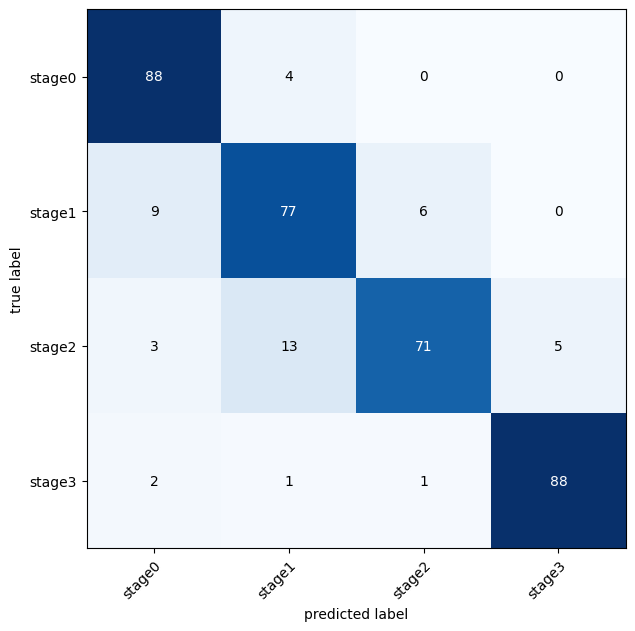

In [32]:
from tqdm.auto import tqdm
y_preds = []
model_efficient_b3.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader2, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_efficient_b3(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model_efficient_b3 = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=4, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model_efficient_b3,
                         target=test_data2.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names2,
    figsize=(10, 7)
);

In [33]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")

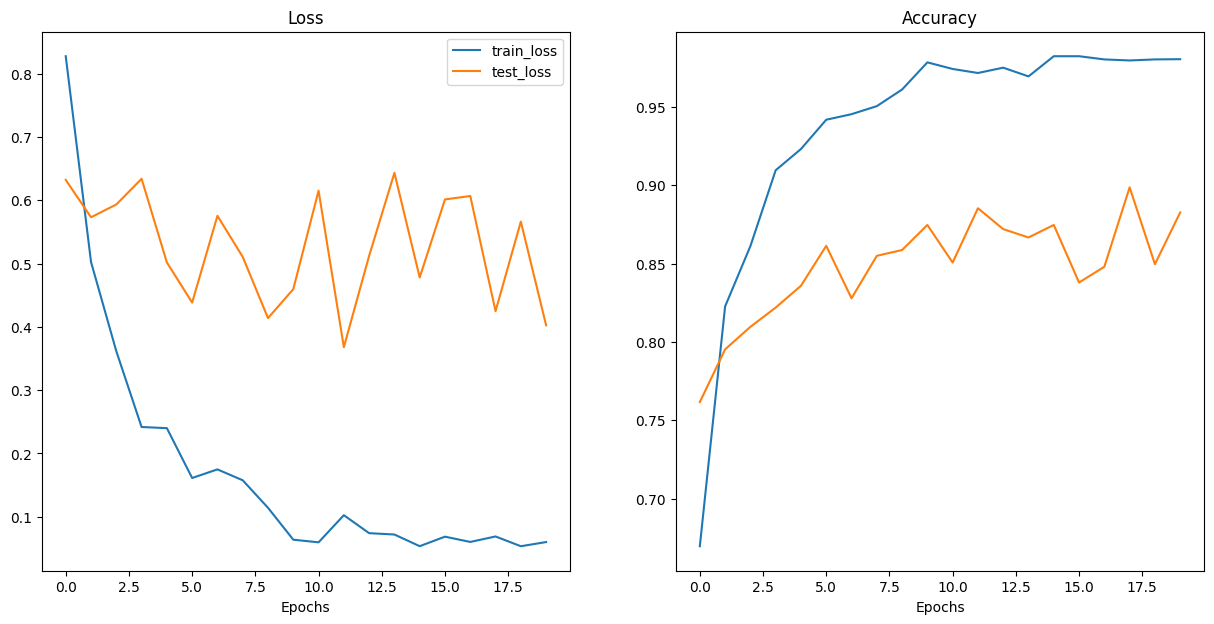

In [34]:
plot_loss_curves(results_eff_3)

In [35]:
import torch.utils.checkpoint as checkpoint
import torchvision
import torch
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights_regnet = torchvision.models.RegNet_Y_32GF_Weights.DEFAULT
model_regnet = torchvision.models.regnet_y_32gf(weights=weights_regnet).to(device)
class CheckpointedRegNet(nn.Module):
    def __init__(self, model):
        super(CheckpointedRegNet, self).__init__()
        self.model = model
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x.requires_grad_()
        # Apply gradient checkpointing on blocks that are memory intensive
        x = checkpoint.checkpoint(self.model.stem, x)
        for block in self.model.trunk_output.children():
            x = checkpoint.checkpoint(block, x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = checkpoint.checkpoint(self.model.fc, x)
        return x
    def __getattr__(self, name):
        """
        This function ensures that if an attribute is not found in the
        CheckpointedRegNet instance itself, it is looked up in the wrapped model (self.model).
        """
        try:
          return super().__getattr__(name)
        except AttributeError:
          return getattr(self.model, name)

# Replace the original model with the checkpointed version
model_regnet = CheckpointedRegNet(model_regnet)

Downloading: "https://download.pytorch.org/models/regnet_y_32gf-8db6d4b5.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_32gf-8db6d4b5.pth
100%|██████████| 554M/554M [00:12<00:00, 46.0MB/s]


In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer_model_regnet = torch.optim.Adam(model_regnet.parameters())

In [38]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results_regnet = engine.train(model=model_regnet,
                       train_dataloader=train_dataloader2,
                       test_dataloader=test_dataloader2,
                       optimizer=optimizer_model_regnet,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2908 | train_acc: 0.5870 | test_loss: 1.1215 | test_acc: 0.5163
Epoch: 2 | train_loss: 0.7268 | train_acc: 0.6967 | test_loss: 0.6800 | test_acc: 0.7253
Epoch: 3 | train_loss: 0.5825 | train_acc: 0.7614 | test_loss: 0.7219 | test_acc: 0.7314
Epoch: 4 | train_loss: 0.4039 | train_acc: 0.8438 | test_loss: 0.6609 | test_acc: 0.7846
Epoch: 5 | train_loss: 0.3241 | train_acc: 0.8760 | test_loss: 1.2856 | test_acc: 0.6104
Epoch: 6 | train_loss: 0.3959 | train_acc: 0.8581 | test_loss: 0.9389 | test_acc: 0.6662
Epoch: 7 | train_loss: 0.2556 | train_acc: 0.9062 | test_loss: 1.1301 | test_acc: 0.6754
Epoch: 8 | train_loss: 0.1317 | train_acc: 0.9520 | test_loss: 0.8439 | test_acc: 0.7372
Epoch: 9 | train_loss: 0.0980 | train_acc: 0.9665 | test_loss: 0.8054 | test_acc: 0.7612
Epoch: 10 | train_loss: 0.1722 | train_acc: 0.9410 | test_loss: 1.3943 | test_acc: 0.6465
Epoch: 11 | train_loss: 0.1475 | train_acc: 0.9492 | test_loss: 0.9394 | test_acc: 0.7313
Epoch: 12 | train_l

In [39]:
torch.save(model_efficient_b3.state_dict(), f'model_efficentnet_b3.pth')

Making predictions:   0%|          | 0/15 [00:00<?, ?it/s]

mlxtend version: 0.23.1


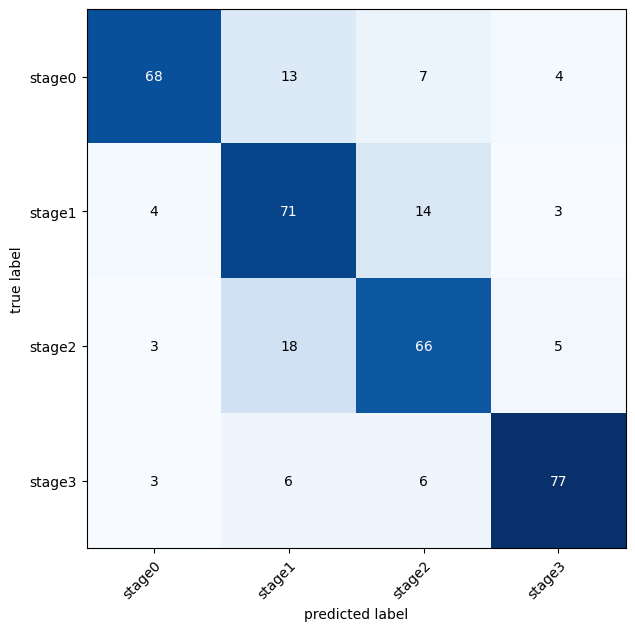

In [40]:
from tqdm.auto import tqdm
y_preds = []
model_regnet.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader2, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_regnet(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model_regnet = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=4, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model_regnet,
                         target=test_data2.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names2,
    figsize=(10, 7)
);

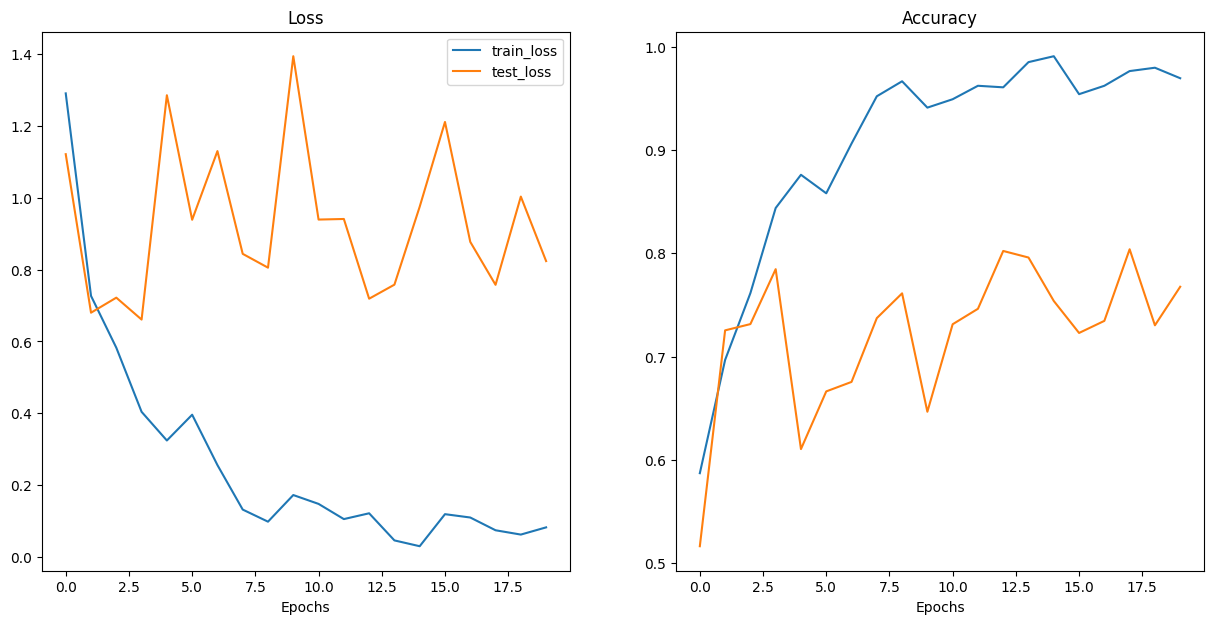

In [41]:
plot_loss_curves(results_regnet)

In [45]:
import torchvision
weights_eff_b4 = torchvision.models.EfficientNet_B4_Weights.DEFAULT
model_efficient_b4 = torchvision.models.efficientnet_b4(weights=weights_eff_b4).to(device)
model_efficient_b4.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1792,
                    out_features=4,
                    bias=True)).to(device)

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer_model_eff_b4 = torch.optim.Adam(model_efficient_b4.parameters())

In [47]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results_eff_4 = engine.train(model=model_efficient_b4,
                       train_dataloader=train_dataloader2,
                       test_dataloader=test_dataloader2,
                       optimizer=optimizer_model_eff_b4,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9310 | train_acc: 0.6250 | test_loss: 0.6816 | test_acc: 0.6939
Epoch: 2 | train_loss: 0.4092 | train_acc: 0.8461 | test_loss: 0.5183 | test_acc: 0.7979
Epoch: 3 | train_loss: 0.1994 | train_acc: 0.9281 | test_loss: 0.7311 | test_acc: 0.7990
Epoch: 4 | train_loss: 0.1937 | train_acc: 0.9379 | test_loss: 0.5189 | test_acc: 0.8299
Epoch: 5 | train_loss: 0.1095 | train_acc: 0.9614 | test_loss: 0.5254 | test_acc: 0.8453
Epoch: 6 | train_loss: 0.0874 | train_acc: 0.9722 | test_loss: 0.5117 | test_acc: 0.8693
Epoch: 7 | train_loss: 0.0644 | train_acc: 0.9798 | test_loss: 0.5296 | test_acc: 0.8443
Epoch: 8 | train_loss: 0.0843 | train_acc: 0.9696 | test_loss: 0.6865 | test_acc: 0.8363
Epoch: 9 | train_loss: 0.0622 | train_acc: 0.9800 | test_loss: 0.7505 | test_acc: 0.8256
Epoch: 10 | train_loss: 0.0761 | train_acc: 0.9722 | test_loss: 0.6660 | test_acc: 0.8293
Epoch: 11 | train_loss: 0.0488 | train_acc: 0.9817 | test_loss: 0.5972 | test_acc: 0.8427
Epoch: 12 | train_l

Making predictions:   0%|          | 0/15 [00:00<?, ?it/s]

mlxtend version: 0.23.1


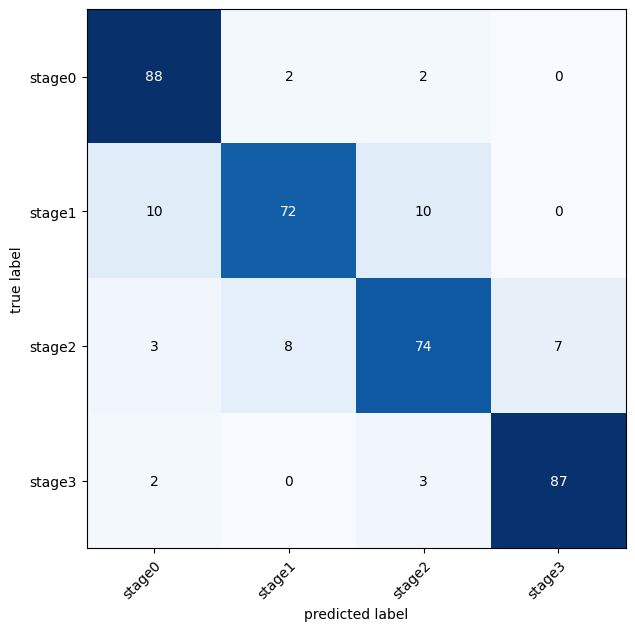

In [48]:
from tqdm.auto import tqdm
y_preds = []
model_efficient_b4.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader2, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_efficient_b4(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model_efficient_b4 = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=4, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model_efficient_b4,
                         target=test_data2.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names2,
    figsize=(10, 7)
);

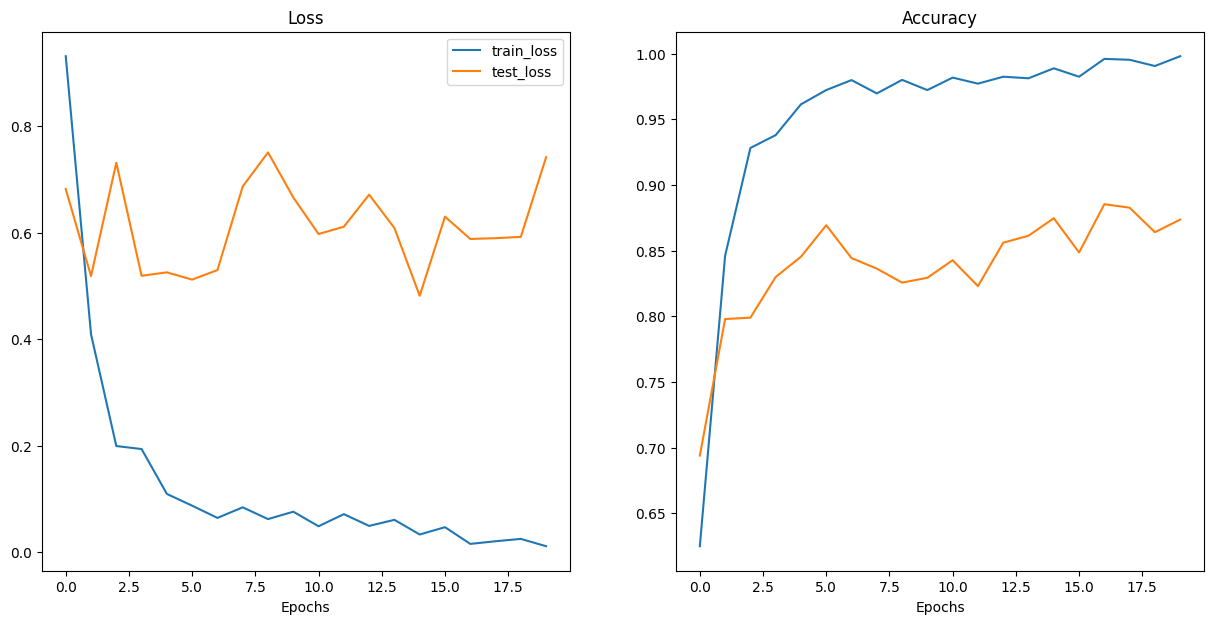

In [49]:
plot_loss_curves(results_eff_4)

In [51]:
import torchvision
weights_eff_b4_frz = torchvision.models.EfficientNet_B4_Weights.DEFAULT
model_efficient_b4_frz = torchvision.models.efficientnet_b4(weights=weights_eff_b4_frz).to(device)
for param in model_efficient_b4_frz.features.parameters():
        param.requires_grad = False
model_efficient_b4_frz.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1792,
                    out_features=4,
                    bias=True)).to(device)

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer_model_eff_b4_frz = torch.optim.Adam(model_efficient_b4_frz.parameters())


In [55]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results_eff_4_frz = engine.train(model=model_efficient_b4_frz,
                       train_dataloader=train_dataloader2,
                       test_dataloader=test_dataloader2,
                       optimizer=optimizer_model_eff_b4_frz,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2518 | train_acc: 0.4870 | test_loss: 1.1592 | test_acc: 0.5259
Epoch: 2 | train_loss: 1.0797 | train_acc: 0.5835 | test_loss: 1.0475 | test_acc: 0.5867
Epoch: 3 | train_loss: 1.0069 | train_acc: 0.6070 | test_loss: 0.9797 | test_acc: 0.6400
Epoch: 4 | train_loss: 0.9502 | train_acc: 0.6387 | test_loss: 0.9461 | test_acc: 0.6363
Epoch: 5 | train_loss: 0.9131 | train_acc: 0.6428 | test_loss: 0.9061 | test_acc: 0.6230
Epoch: 6 | train_loss: 0.8939 | train_acc: 0.6505 | test_loss: 0.8916 | test_acc: 0.6656
Epoch: 7 | train_loss: 0.8528 | train_acc: 0.6691 | test_loss: 0.8827 | test_acc: 0.6550
Epoch: 8 | train_loss: 0.8542 | train_acc: 0.6738 | test_loss: 0.8670 | test_acc: 0.6550
Epoch: 9 | train_loss: 0.8325 | train_acc: 0.6770 | test_loss: 0.8570 | test_acc: 0.6630
Epoch: 10 | train_loss: 0.8153 | train_acc: 0.6882 | test_loss: 0.8459 | test_acc: 0.6656
Epoch: 11 | train_loss: 0.8099 | train_acc: 0.6796 | test_loss: 0.8436 | test_acc: 0.6523
Epoch: 12 | train_l

In [ ]:
from tqdm.auto import tqdm
y_preds = []
model_efficient_b4_frz.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader2, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_efficient_b4_frz(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model_efficient_b4_frz = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=4, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model_efficient_b4_frz,
                         target=test_data2.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names2,
    figsize=(10, 7)
);

In [ ]:
plot_loss_curves(results_eff_4_frz)

In [56]:
best_model_path = "/content/model_efficentnet_b3.pth"
best_model = model_efficient_b3
best_model.load_state_dict(torch.load(best_model_path))

<ipython-input-56-cb0f293e16b6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [92]:
from typing import List, Tuple
from PIL import Image
import re
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    name = re.sub('[/contnet/]' , '' , image_path)
    name = re.sub('[.jpg]' , '' , name)
    img = Image.open(image_path)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    model.to(device)
    model.eval()
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)

      target_image_pred = model(transformed_image.to(device))
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"name: {name} \nPred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

In [61]:
!gdown 1p42D7YuzgwkzSzfyAULfLFZHFYADVOKO
!gdown 12osAlEDa-dLXU0TDjMlOjc0rYWe_C2pe
!gdown 1iJWUFfd2SPIz0Xsyb8aMC27gf0Hgeadx
!gdown 1MmqwxbtxpWdUotGTjrQ4mrtWw7hFFGCT
!gdown 14dFmc4cKeIMcmO6VaaVunkjop5DZAWHm
!gdown 1bNPWJvJUX0R7TryhS3d3ifrwxxxOKjg_
!gdown 1EOb0JZli5AXTSXbWY9aOHRdIGtVDdc6r
!gdown 1X3dbNtZDZkWKPV18QNE18UzIDRWP3m5A

Downloading...
From: https://drive.google.com/uc?id=1p42D7YuzgwkzSzfyAULfLFZHFYADVOKO
To: /content/162_F_GA26_BW850_PA39_DG4_PF0_D3_S03_17.jpg
100% 756k/756k [00:00<00:00, 97.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=12osAlEDa-dLXU0TDjMlOjc0rYWe_C2pe
To: /content/146_M_GA23_BW590_PA37_DG4_PF0_D3_S04_30.jpg
100% 740k/740k [00:00<00:00, 152MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iJWUFfd2SPIz0Xsyb8aMC27gf0Hgeadx
To: /content/069_M_GA30_BW1100_PA32_DG1_PF0_D1_S01_1.jpg
100% 43.0k/43.0k [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MmqwxbtxpWdUotGTjrQ4mrtWw7hFFGCT
To: /content/066_F_GA26_BW810_PA31_DG1_PF0_D1_S01_7.jpg
100% 41.6k/41.6k [00:00<00:00, 93.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=14dFmc4cKeIMcmO6VaaVunkjop5DZAWHm
To: /content/031_M_GA25_BW910_PA40_DG2_PF0_D1_S08_7.jpg
100% 51.0k/51.0k [00:00<00:00, 98.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bNPWJvJUX0R7TryhS3d3ifrwxxxOKjg_
To

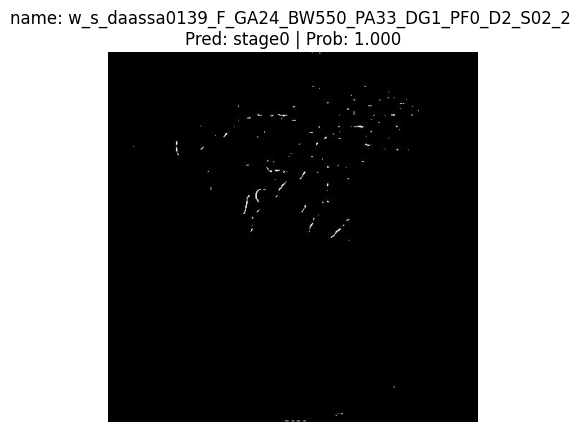

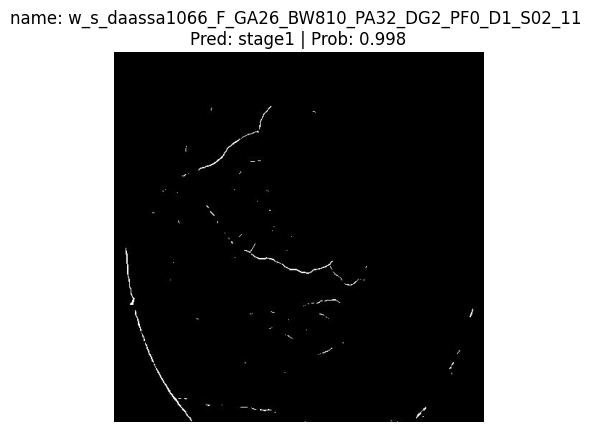

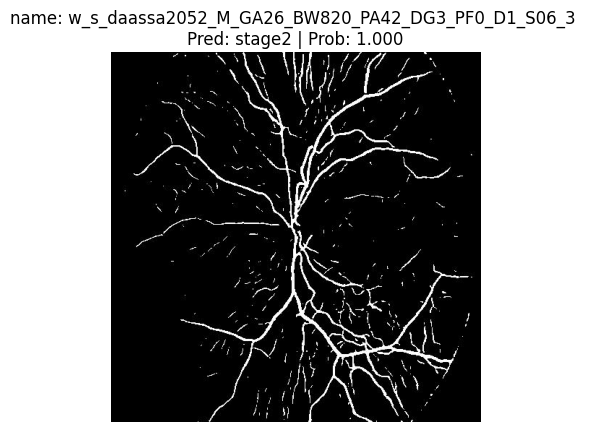

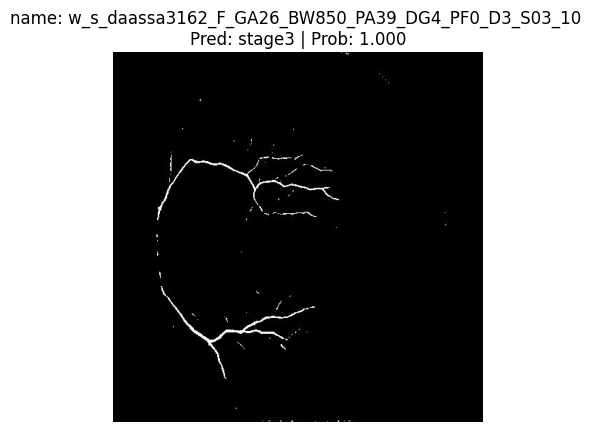

In [96]:
from pathlib import Path
# list(Path(test_images).glob("*/*.jpg"))
test_image_path_sample = ['/content/new_test_dataset/stage0/139_F_GA24_BW550_PA33_DG1_PF0_D2_S02_2.jpg' , '/content/new_test_dataset/stage1/066_F_GA26_BW810_PA32_DG2_PF0_D1_S02_11.jpg' , '/content/new_test_dataset/stage2/052_M_GA26_BW820_PA42_DG3_PF0_D1_S06_3.jpg' , '/content/new_test_dataset/stage3/162_F_GA26_BW850_PA39_DG4_PF0_D3_S03_10.jpg']
for image_path in test_image_path_sample:
  pred_and_plot_image(model=best_model,
                      image_path=image_path,
                      class_names=class_names2,
                      image_size=(224, 224))

In [70]:
ptt = '/content/mahdi.jpg'



In [87]:
import re
ptt_new = re.sub('[/content/]' , '' , ptt)
ptt_new = re.sub('[.jpg]' , '' , ptt_new)

In [88]:
ptt_new

'mahdi'

In [100]:
import torchvision
weights_eff_b2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_efficient_b2 = torchvision.models.efficientnet_b2(weights=weights_eff_b2).to(device)
model_efficient_b2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=4,
                    bias=True)).to(device)

In [101]:
loss_fn = nn.CrossEntropyLoss()
optimizer_model_eff_b2 = torch.optim.Adam(model_efficient_b2.parameters())

In [102]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results_eff_2 = engine.train(model=model_efficient_b2,
                       train_dataloader=train_dataloader2,
                       test_dataloader=test_dataloader2,
                       optimizer=optimizer_model_eff_b2,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8995 | train_acc: 0.6291 | test_loss: 0.7249 | test_acc: 0.7164
Epoch: 2 | train_loss: 0.5566 | train_acc: 0.7935 | test_loss: 0.5132 | test_acc: 0.8262
Epoch: 3 | train_loss: 0.4139 | train_acc: 0.8457 | test_loss: 0.7193 | test_acc: 0.7616
Epoch: 4 | train_loss: 0.3120 | train_acc: 0.8730 | test_loss: 0.5086 | test_acc: 0.8028
Epoch: 5 | train_loss: 0.2138 | train_acc: 0.9292 | test_loss: 0.5534 | test_acc: 0.8289
Epoch: 6 | train_loss: 0.2423 | train_acc: 0.9174 | test_loss: 0.5534 | test_acc: 0.8246
Epoch: 7 | train_loss: 0.1387 | train_acc: 0.9537 | test_loss: 0.4061 | test_acc: 0.8630
Epoch: 8 | train_loss: 0.1554 | train_acc: 0.9431 | test_loss: 0.5891 | test_acc: 0.8433
Epoch: 9 | train_loss: 0.0925 | train_acc: 0.9664 | test_loss: 0.4585 | test_acc: 0.8710
Epoch: 10 | train_loss: 0.1117 | train_acc: 0.9622 | test_loss: 0.7521 | test_acc: 0.8348
Epoch: 11 | train_loss: 0.1297 | train_acc: 0.9574 | test_loss: 0.5271 | test_acc: 0.8465
Epoch: 12 | train_l

Making predictions:   0%|          | 0/15 [00:00<?, ?it/s]

mlxtend version: 0.23.1


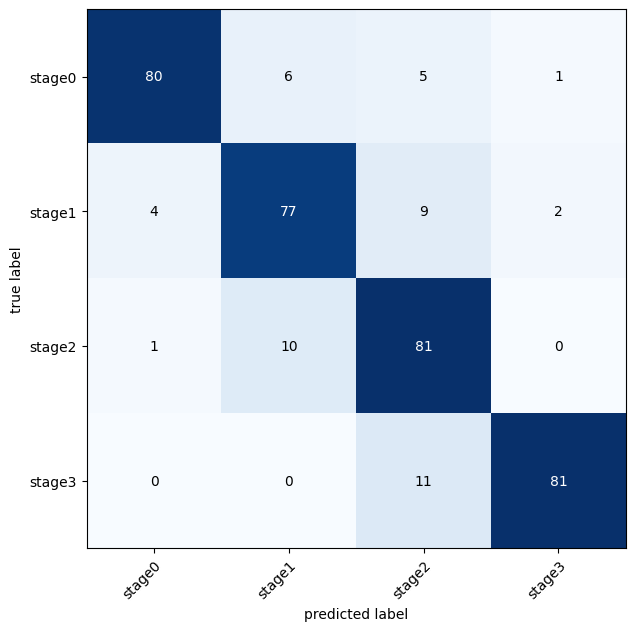

In [103]:
from tqdm.auto import tqdm
y_preds = []
model_efficient_b2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader2, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_efficient_b2(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model_efficient_b2 = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=4, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model_efficient_b2,
                         target=test_data2.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names2,
    figsize=(10, 7)
);

In [107]:
import torchvision
weights_eff_b2_frz = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_eff_b2_frz = torchvision.models.efficientnet_b2(weights=weights_eff_b2_frz).to(device)
total_layers_model_eff_b2_frz = sum(1 for _ in model_eff_b2_frz.parameters())
percent_freeze_model_eff_b2_frz = 0.7
num_layers_freeze_model_eff_b2_frz = int(percent_freeze_model_eff_b2_frz*total_layers_model_eff_b2_frz)
frozen_layers_model_eff_b2_frz = 0
for name , param in model_eff_b2_frz.named_parameters():
  if "classifier" not in name:
    if frozen_layers_model_eff_b2_frz < num_layers_freeze_model_eff_b2_frz:
      param.requires_grad = False
      frozen_layers_model_eff_b2_frz += 1
    else:
      break

In [108]:
loss_fn = nn.CrossEntropyLoss()
optimizer_model_eff_b2_frz = torch.optim.Adam(model_eff_b2_frz.parameters())

In [109]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results_eff_2 = engine.train(model=model_eff_b2_frz,
                       train_dataloader=train_dataloader2,
                       test_dataloader=test_dataloader2,
                       optimizer=optimizer_model_eff_b2_frz,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4304 | train_acc: 0.5938 | test_loss: 0.6542 | test_acc: 0.7265
Epoch: 2 | train_loss: 0.5305 | train_acc: 0.7953 | test_loss: 0.7119 | test_acc: 0.7413
Epoch: 3 | train_loss: 0.3749 | train_acc: 0.8666 | test_loss: 0.9650 | test_acc: 0.7313
Epoch: 4 | train_loss: 0.3028 | train_acc: 0.8803 | test_loss: 0.5625 | test_acc: 0.8096
Epoch: 5 | train_loss: 0.1987 | train_acc: 0.9330 | test_loss: 0.5993 | test_acc: 0.8203
Epoch: 6 | train_loss: 0.1930 | train_acc: 0.9408 | test_loss: 0.8168 | test_acc: 0.8053
Epoch: 7 | train_loss: 0.1548 | train_acc: 0.9476 | test_loss: 0.7490 | test_acc: 0.7973
Epoch: 8 | train_loss: 0.1690 | train_acc: 0.9474 | test_loss: 0.6852 | test_acc: 0.7862
Epoch: 9 | train_loss: 0.1564 | train_acc: 0.9452 | test_loss: 0.7818 | test_acc: 0.8225
Epoch: 10 | train_loss: 0.1092 | train_acc: 0.9615 | test_loss: 0.9350 | test_acc: 0.7963
Epoch: 11 | train_loss: 0.1345 | train_acc: 0.9539 | test_loss: 0.8036 | test_acc: 0.7893
Epoch: 12 | train_l

Making predictions:   0%|          | 0/15 [00:00<?, ?it/s]

mlxtend version: 0.23.1


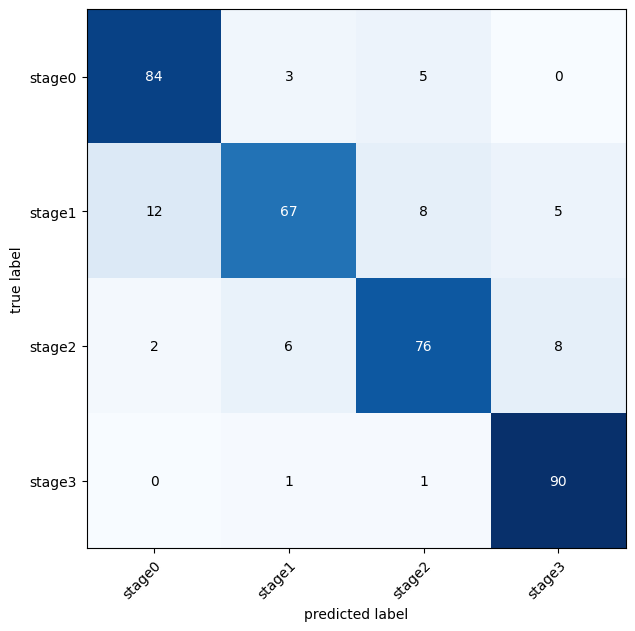

In [110]:
from tqdm.auto import tqdm
y_preds = []
model_eff_b2_frz.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader2, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_eff_b2_frz(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model_eff_b2_frz = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=4, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model_eff_b2_frz,
                         target=test_data2.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names2,
    figsize=(10, 7)
);

In [114]:
import torchvision
weights_eff_b5 = torchvision.models.EfficientNet_B5_Weights.DEFAULT
model_efficient_b5 = torchvision.models.efficientnet_b5(weights=weights_eff_b5).to(device)
model_efficient_b5.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=2048,
                    out_features=4,
                    bias=True)).to(device)

In [115]:
loss_fn = nn.CrossEntropyLoss()
optimizer_model_eff_b5 = torch.optim.Adam(model_efficient_b5.parameters())

In [116]:
from module_funcs import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results_eff_5 = engine.train(model=model_efficient_b5,
                       train_dataloader=train_dataloader2,
                       test_dataloader=test_dataloader2,
                       optimizer=optimizer_model_eff_b5,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 72.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 1.06 MiB is free. Process 2666 has 14.74 GiB memory in use. Of the allocated memory 13.72 GiB is allocated by PyTorch, and 904.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from tqdm.auto import tqdm
y_preds = []
model_efficient_b5.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader2, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_efficient_b5(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor_model_efficient_b5 = torch.cat(y_preds)
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=4, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor_model_efficient_b5,
                         target=test_data2.targets)


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names2,
    figsize=(10, 7)
);